### Check Dependencies 

In [1]:
import importlib

def check_library_first():
    # Define the required libraries
    libraries = ['numpy', 'matplotlib', 'seaborn', 'statsmodels', 'docx','tsfeatures']
    # Iterate over the libraries
    for library in libraries:
        try:
            # Try importing the library
            importlib.import_module(library)
            print(f"{library} is already installed.")
        except ImportError:
            # If import fails, install the library
            print(f"{library} is not installed. Installing...")
            try:
                import pip
                pip.main(['install', library])
                print(f"{library} has been successfully installed.")
            except Exception as e:
                print(f"Error occurred while installing {library}: {str(e)}")
    return None
check_library_first()

numpy is already installed.
matplotlib is already installed.
seaborn is already installed.
statsmodels is already installed.
docx is already installed.
tsfeatures is already installed.


### Import the libraries 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from datetime import datetime
from dateutil import relativedelta
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import figure
from scipy.stats import ttest_ind,ttest_1samp, ttest_rel, wilcoxon,mannwhitneyu
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.formula.api import ols
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('float_format', '{:f}'.format)
plt.rcParams['figure.figsize'] = [14,7]
sns.set(style = 'darkgrid')
import warnings
warnings.filterwarnings("ignore")
color='xkcd:lightish blue'
import docx
from docx.shared import Inches
import time
import logging
import os
# importing config parser for reading config.ini file
import configparser

## Config


In [3]:
# # columns 
# # Forecast Grain	Modified Sales - After Outlier treatment	Calendar Month
# # Part Number	Plant Code	Year Month - YYYYMM	Sales Quantity
# # Part Number	Company	Plant	Calendar Month ID	Sales Quantity
# product1 = 'Active Material'
# product2 = 'Ship to party'
# product3 = None
# date = 'ISO Year Week'
# sales = 'Net Billing Qty'
# frequency = 'Weekly'
# if_only_sales = 'Yes'
# # datetime_as_featues = 'yes'
# date_formate = 'YYYYWW'
# lastdate = 202241
# zscore = 2
# customer_name = 'NutriAsia'
# path = "/Users/umeshnagar/Downloads/Customer/" +  customer_name
# filename = path + '/Data/ACategory_product.csv'  
# # filename = 'Cortex_Input_Preprocessed_Monthly_Sales_History_04-22-2022-23-56-51.csv' # Exxon
# # filename = 'Sales_EMDIBP_Validation_08-11-2022-10-31-49.csv' # IBP small grains
# ABC_year_customize = 'No' # Yes or no if user want last 1 year or 2 years of sales
# how_many_subplot = 10
# skiprowsin_csv = 0
# seasoanlity_threshold = 0.75
# trend_threshold = 0.4
# n_cluster = 5
# repeate_count = 10
# EDAfilename = '_EDA.docx'
# last_range_outlier = 12


In [4]:
product1 = 'Product'
product2 = None
product3 = None
date = 'Date'
sales = 'Quantity'
frequency = 'Monthly'
if_only_sales = 'Yes'
date_formate = 'YYYYMM'
lastdate = 202212
zscore = 2
customer_name = 'ABC'
path = "/Users/umeshnagar/myproject/"
filename = '/Users/umeshnagar/myproject/SampleSalesData.csv' 
ABC_year_customize = 'No' # Yes or no if user want last 1 year or 2 years of quantity
how_many_subplot = 10
skiprowsin_csv = 0
seasoanlity_threshold = 0.75
trend_threshold = 0.4
n_cluster = 5
repeate_count = 10
EDAfilename = 'sample_EDA.docx' # to store the images and eda document
last_range_outlier = 12

In [6]:
# creating the object of configparser
configsales_data = configparser.ConfigParser()
# reading data
configsales_data.read("../ConfigEDA.ini")
# app configuration data
EDA_CONSTANT = configsales_data["values"]
# for valuessales_data in EDA_CONSTANT:
#     print(f"{valuessales_data} = {EDA_CONSTANT.get(valuessales_data)}")


['../ConfigEDA.ini']

In [7]:
start_time = time.time()

In [8]:
if frequency == 'Daily':
    date_count = 30 * 30
    date_high_count = 40 * 30
    yearly_freq = 365
elif frequency == 'Monthly':
    date_count = 18
    date_high_count = 40
    yearly_freq = 12
elif frequency == 'Weekly':
    date_count = 80
    date_high_count = 100
    yearly_freq = 52


In [9]:
count_number = 1
def file_check_and_title_for_EDA_DOC():
    doc = docx.Document()
    if os.path.exists(path + customer_name + '_EDA.docx'):
        os.remove(path + customer_name + '_EDA.docx')
        doc.add_paragraph("File with same name has overwritten...")
    doc.add_heading(customer_name + " Exploratory Data Analysis" + "\n\n", 0)
    return doc
doc=file_check_and_title_for_EDA_DOC()

In [10]:
def assign_datatype():
    doc.add_heading(f'{count_number} Basic details\n', 1)
    if type(product1) == str and type(product2) == str and type(product3) == str :
        dtype = {product1 : str, product2 : str, product3 : str}
        number_of_the_products = 3
        doc.add_paragraph(f'a. Number of product columns are {number_of_the_products}')
    elif type(product1) == str and type(product2) == str and product3 == None :
        dtype = {product1 : str, product2 : str}
        number_of_the_products = 2
        doc.add_paragraph(f'a. Number of product columns are {number_of_the_products}')

    elif type(product1) == str and product2 == None and product3 == None :
        dtype = {product1 : str} 
        number_of_the_products = 1
        doc.add_paragraph(f'a. Number of product column is {number_of_the_products}')
    return dtype, number_of_the_products


In [11]:
try:
    if os.path.exists(filename):
        dtype,number_of_the_products= assign_datatype()
        sales_data = pd.read_csv(filename,dtype = dtype, skiprows = skiprowsin_csv)
        sales_data[date] = sales_data[date].map(float).fillna(0).map(int)
        sales_data.head()
        count_number += 1
        orignal_data = sales_data.copy(deep=True)
except FileNotFoundError:
    print(f'file not found {filename}')
    doc.add_paragraph('File {} not found'.format(filename))


Product    Date  Quantity
0  Detol-Pune  201910    808630
1  Detol-Pune  201911    828300
2  Detol-Pune  201912    612450
3  Detol-Pune  202001    970670
4  Detol-Pune  202002   1174800

In [12]:
doc.add_paragraph('b.Total rows are {} and columns are {}.'.format(sales_data.shape[0],sales_data.shape[1]))


In [13]:
def combine_product_into_single(data1, number_of_the_products ):
    columns = data1.columns
    if number_of_the_products == 3:
        data1['product'] =  data1[product1] + '-' + data1[product2] + '-' + data1[product3]
        data1.drop([product1,product2,product3], axis = 1, inplace = True)
    elif number_of_the_products == 2:
        data1['product'] =  data1[product1] + '-' + data1[product2]
        data1.drop([product1,product2], axis = 1, inplace = True)
    elif number_of_the_products == 1:
        data1['product'] =  data1[product1]
    return data1

data = combine_product_into_single(sales_data, number_of_the_products = number_of_the_products)


In [14]:
def sort_grainwise(data):
    data.sort_values(['product', date], ascending=[True,True],inplace=True)
    return data.reset_index(drop=True)
data = sort_grainwise(sales_data)
data.head()

Product    Date  Quantity     product
0  Book-Delhi  201910     30480  Book-Delhi
1  Book-Delhi  201911     32730  Book-Delhi
2  Book-Delhi  201912     63680  Book-Delhi
3  Book-Delhi  202001     65010  Book-Delhi
4  Book-Delhi  202002     32610  Book-Delhi

In [15]:
def total_product(data):
    total_products = data['product'].drop_duplicates().reset_index(drop = True)
    doc.add_paragraph("c. Total number of products are - {}".format(len(total_products)))

    return total_products
all_products = total_product(data)

In [16]:
def get_time_info(data1, date):
    '''
    param:dataframe
    return datetime converted dataframe
    '''
    data1 = data.copy()
    if frequency == 'Daily':
        data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6]
        data1['new_date'] = pd.to_datetime(data1['new_date']).dt.strftime('%Y-%m-%d')
        start_date = min(data1['new_date'])
        end_date = max(data1['new_date'])
        doc.add_paragraph('Time duration of sales are from {} to {}'.format(str(start_date),str(end_date)))
        date = relativedelta.relativedelta(pd.to_datetime(start_date), pd.to_datetime(end_date))
        doc.add_paragraph('Total years {}, months {} and days {} in time series->'.format(abs(date.years), abs(date.months),abs(date.days)))
        doc.add_paragraph('Total number of the Months are -> {}'.format(abs(date.years * 12 + date.months + date.days/30)))
        doc.add_paragraph('Total number of the Weeks are -> {}'.format(abs(date.years * 53 + date.months * 4 + date.days/4)))

    elif frequency == 'Monthly':
        if date_formate == 'YYYYMM':
            data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6]
            data1['new_date'] = pd.to_datetime(data1['new_date'].astype(str).add('-0'), format = "%Y-%m-%w")
            start_date = min(data1['new_date'])
            end_date = max(data1['new_date'])
            doc.add_paragraph('d.1 Time duration of sales from {} to {}'.format(str(start_date.date()),str(end_date.date())))
            date = relativedelta.relativedelta(pd.to_datetime(start_date), pd.to_datetime(end_date))
            doc.add_paragraph('d.2 Total years {}, months {} and days {} in time series'.format(abs(date.years), abs(date.months),abs(date.days)))
            doc.add_paragraph('d.3 Total number of the Months are %d'%(abs(date.years * 12 + date.months + date.days/30)))
            doc.add_paragraph('d.4 Total number of the Weeks are %d'%(abs(date.years * 53 + date.months * 4 + date.days/4)))

    elif frequency == 'Weekly':
        if date_formate == 'YYYYWW':
            data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6]
            data1['new_date'] = pd.to_datetime(data1['new_date'].astype(str).add('-0'), format = "%Y-%W-%w")
            start_date = min(data1['new_date'])
            end_date = max(data1['new_date'])
            doc.add_paragraph('Time duration of sales from {} to {}'.format(str(start_date.date()),str(end_date.date())))
            date = relativedelta.relativedelta(pd.to_datetime(start_date), pd.to_datetime(end_date))
            doc.add_paragraph('Total years {}, months {} and days {} in time series'.format(abs(date.years), abs(date.months),abs(date.days)))
            doc.add_paragraph('Total number of the Months are -> %d'%(abs(date.years * 12 + date.months + date.days/30)))
            doc.add_paragraph('Total number of the Weeks are -> %d'%(abs(date.years * 53 + date.months * 4 + date.days/4)))
    return data1


In [17]:
data1 = get_time_info(data, date)
def assign_product_name():
    global product 
    product = 'product'
assign_product_name()

In [18]:
data_mean = data1.groupby(product)[sales].mean().reset_index()
max_row = data_mean[data_mean[sales] == max(data_mean[sales])].reset_index()
doc.add_paragraph(f'e.1 Max avg sale {round(float(max_row[sales]),2)} and product is {str(max_row[product][0])}')


In [19]:
# data_mean = data1.groupby(product)[sales].mean().reset_index()
min_row = data_mean[data_mean[sales] == min(data_mean[sales])].head(1).reset_index()
doc.add_paragraph(f'e.2 Min avg sale {round(float(min_row[sales]),2)} and product is -> {str(min_row[product][0])}')

In [20]:
data1.head()

Product    Date  Quantity     product   new_date
0  Book-Delhi  201910     30480  Book-Delhi 2019-10-01
1  Book-Delhi  201911     32730  Book-Delhi 2019-11-01
2  Book-Delhi  201912     63680  Book-Delhi 2019-12-01
3  Book-Delhi  202001     65010  Book-Delhi 2020-01-01
4  Book-Delhi  202002     32610  Book-Delhi 2020-02-01

In [21]:
def get_end_of_sale(data):
#     data['new_date'] = data[date].map(str).str[0:4] + '-' + data[date].map(str).str[4:6] # removed while doing weekly run
#     data['new_date'] = pd.to_datetime(data['new_date'],format='%Y-%m-%d') # removed while doing weekly run
    box_data = data.groupby(['new_date'])[sales].agg(sales = 'sum').reset_index()
    sales_upto = box_data[box_data['sales'] == 0]
    if sales_upto.shape[0] == 0:
        d = datetime.strftime(max(data['new_date'].dt.date), '%b %Y')
        doc.add_paragraph(f'e3. Last Date of Time Series Data is {d}')
        return str(max(data['new_date'].dt.date))
    else:
        sales_upto = sales_upto['new_date'].values[0]
        doc.add_paragraph(f'e3.Last Date of Sales ->{sales_upto - 1}')

    return int((pd.to_datetime(str(sales_upto), format = '%Y-%m-%d') - pd.DateOffset(months = 1)).strftime(format = '%Y-%m-%d'))
last_sale_date = get_end_of_sale(data1)
last_sale_date

'2023-03-01'

In [22]:
data1.head()

Product    Date  Quantity     product   new_date
0  Book-Delhi  201910     30480  Book-Delhi 2019-10-01
1  Book-Delhi  201911     32730  Book-Delhi 2019-11-01
2  Book-Delhi  201912     63680  Book-Delhi 2019-12-01
3  Book-Delhi  202001     65010  Book-Delhi 2020-01-01
4  Book-Delhi  202002     32610  Book-Delhi 2020-02-01

In [30]:
def ABC_analysis(data, lastdate = None,imagefile='image.png'):
    
#     'new_date' = ''new_date''
#     lastdate = 202112
#     data['new_date'] = data.loc[:,'new_date'].str[:4] + '-' + data.loc[:,'new_date'].str[4:6] 
#     
    if frequency == 'Monthly' and lastdate is not None:
        lastdate1 = str(lastdate)[:4] + '-' + str(lastdate)[4:6] + '-01'
        print(lastdate1)
        lastdate1 = pd.to_datetime(lastdate1, format='%Y-%m-%d') # .strftime('%Y%m')
        one_year_data = data[(data['new_date'] >= (pd.to_datetime(get_end_of_sale(data), format = '%Y-%m-%d') - 
                                          pd.DateOffset(months = 12)).strftime(format = '%Y-%m-%d')) & 
                         (data['new_date'] <= lastdate1)] 
    elif frequency == 'Monthly' and lastdate is None:
        lastdate1 = str(lastdate)[:4] + '-' + str(lastdate)[4:6]  + '-01'
        lastdate1 = pd.to_datetime(lastdate1, format='%Y-%m-%d') # .strftime('%Y%m')
        one_year_data = data[(data['new_date'] >= (pd.to_datetime(get_end_of_sale(data), format = '%Y-%m-%d') - 
                                          pd.DateOffset(months = 12)).strftime(format = '%Y-%m-%d'))] 
                   
    elif frequency == 'Weekly'and lastdate is not None :
        lastdate1 = str(lastdate)[:4] + '-' + str(lastdate)[4:6] + '-0'
        lastdate1 = pd.to_datetime(lastdate1, format='%Y-%W-%w') # .strftime('%Y%m')
        one_year_data = data[(data['new_date'] >= (pd.to_datetime(get_end_of_sale(data), format = '%Y-%m-%d') - 
                                          pd.DateOffset(weeks = 52)).strftime(format = '%Y-%m-%d')) & 
                         (data['new_date'] <= lastdate1)] 
    elif frequency == 'Weekly'and lastdate is None :
        lastdate1 = str(lastdate)[:4] + '-' + str(lastdate)[4:6] + '-0'
        lastdate1 = pd.to_datetime(lastdate1, format='%Y-%W-%w') # .strftime('%Y%m')
        one_year_data = data[(data['new_date'] >= (pd.to_datetime(get_end_of_sale(data), format = '%Y-%m-%d') - 
                                          pd.DateOffset(weeks = 52)).strftime(format = '%Y-%m-%d'))] 
    elif frequency == 'Daily'and lastdate is not None :
        lastdate1 = pd.to_datetime(lastdate, format='%Y-%m-%d') # .strftime('%Y%m')
        one_year_data = data[(data['new_date'] >= (pd.to_datetime(get_end_of_sale(data), format = '%Y-%m-%d') - 
                                          pd.DateOffset(days = 365)).strftime(format = '%Y-%m-%d')) & 
                                         (data['new_date'] <= lastdate1)] 
    elif frequency == 'Daily'and lastdate is None :
        lastdate1 = pd.to_datetime(lastdate1, format='%Y-%m-%d') # .strftime('%Y%m')
        one_year_data = data[(data['new_date'] >= (pd.to_datetime(get_end_of_sale(data), format = '%Y-%m-%d') - 
                                          pd.DateOffset(days = 365)).strftime(format = '%Y-%m-%d'))]    
    
    if ABC_year_customize == 'No' :
        one_year_data = data.copy(deep=True)
    sales_sum = one_year_data[sales].sum()
    grain_sum = one_year_data.groupby([product])[sales].agg(sum_of_sales = 'sum').reset_index()
    data_merged = one_year_data.merge(grain_sum, on =[product], how = 'inner')
    data_merged['total_sum'] = sales_sum
    first_data = data_merged.groupby([product]).first().reset_index() 
    first_data["sum_of_sales"] = first_data['sum_of_sales'].astype(float)
    first_data["total_sum"] = first_data["total_sum"].astype(float)
    first_data = first_data.sort_values(by = ["sum_of_sales"],ascending=False).reset_index(drop = True)
    first_data["Contribution"] = first_data["sum_of_sales"]/first_data["total_sum"]
    first_data["Cumulative"] = first_data['Contribution'].cumsum()
    first_data["Cumulative"]  = first_data["Cumulative"]  * 100
    first_data.loc[first_data['Cumulative'] <= 80,'Vol'] = 'A'
    first_data.loc[(first_data['Cumulative'] > 80 ) & (first_data['Cumulative'] <= 95 ),'Vol'] = 'B'
    first_data.loc[first_data['Cumulative'] > 95,'Vol'] = 'C'
    pic = plt.plot(first_data["Cumulative"])
    plt.title("Cumulative sum is 100 %")
    plt.xlabel('Product')
    plt.ylabel("Cumulative %")
#     doc.add_paragraph(first_data["Vol"].value_counts())
    grain_list_low = first_data[[product,'Vol']]
    high_vol_product = list(first_data[first_data['Vol']== 'A'][product])
    mid_vol_product = list(first_data[first_data['Vol']== 'B'][product])
    low_vol_product = list(first_data[first_data['Vol']== 'C'][product])
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_heading(f'{count_number}.ABC Analysis',1)
    doc.add_picture(path + imagefile, width = Inches(6))

    return first_data[[product,'Contribution','Cumulative','Vol']], high_vol_product, mid_vol_product, low_vol_product

2022-12-01


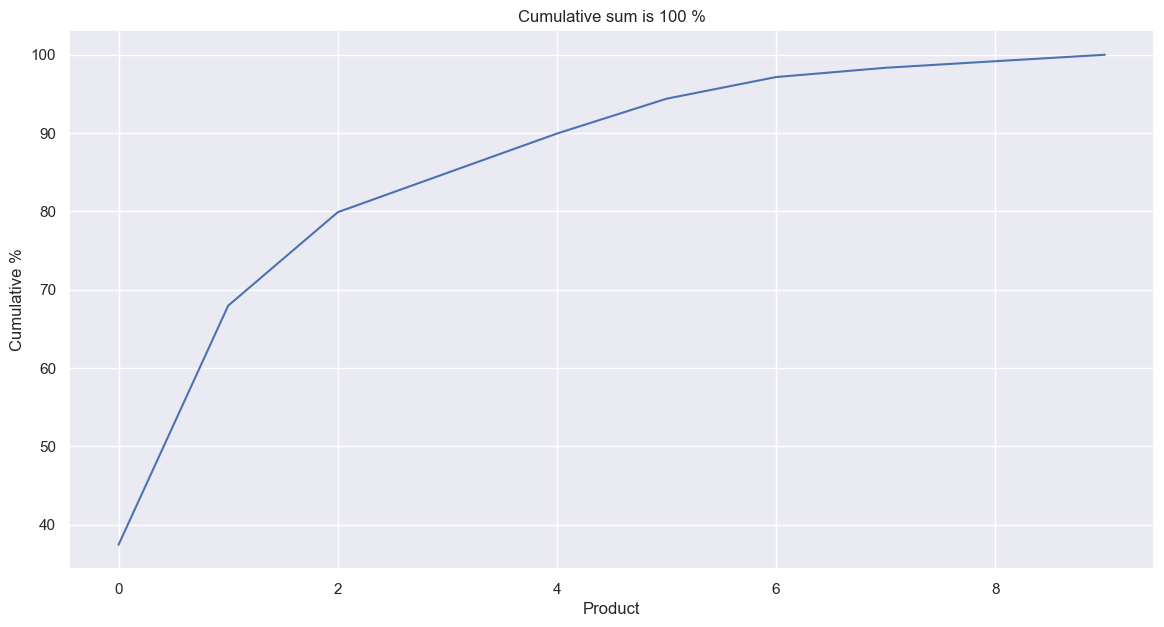

In [31]:
# lastdata = end_of_sale(data1)
ABC_result,high_vol_product, mid_vol_product, low_vol_product = ABC_analysis(data1, lastdate=lastdate,imagefile='ABC_CumulativeChart.png')
doc.add_paragraph('Total grains destribution (80,95,100)')
doc.add_paragraph('\nNumber of grain in A catetory are {}'.format(len(high_vol_product)))
doc.add_paragraph('Number of grain in B catetory are {}'.format(len(mid_vol_product)))
doc.add_paragraph('Number of grain in C catetory are {}'.format(len(low_vol_product)))
count_number +=1



In [32]:
def plot_bar(data1, categorical_col, counting_columns, title,imagefile='image.png') :
    fig, ax = plt.subplots()
    data_forplot = data1.groupby([categorical_col])[counting_columns].count().reset_index()
    bar_plot = plt.bar(data_forplot[categorical_col], data_forplot[counting_columns], color='g')
    total = float(len(data1))
    bar_label = round(data_forplot[counting_columns],2) # this should be count to be doc.add_paragraphed
    def autolabel(rects):
        for idx,rect in enumerate(bar_plot):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, 1.01*height,
                    bar_label[idx],
                    ha='center', va='bottom', rotation=0)

    autolabel(bar_plot)
    plt.title(title)
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))
    return None

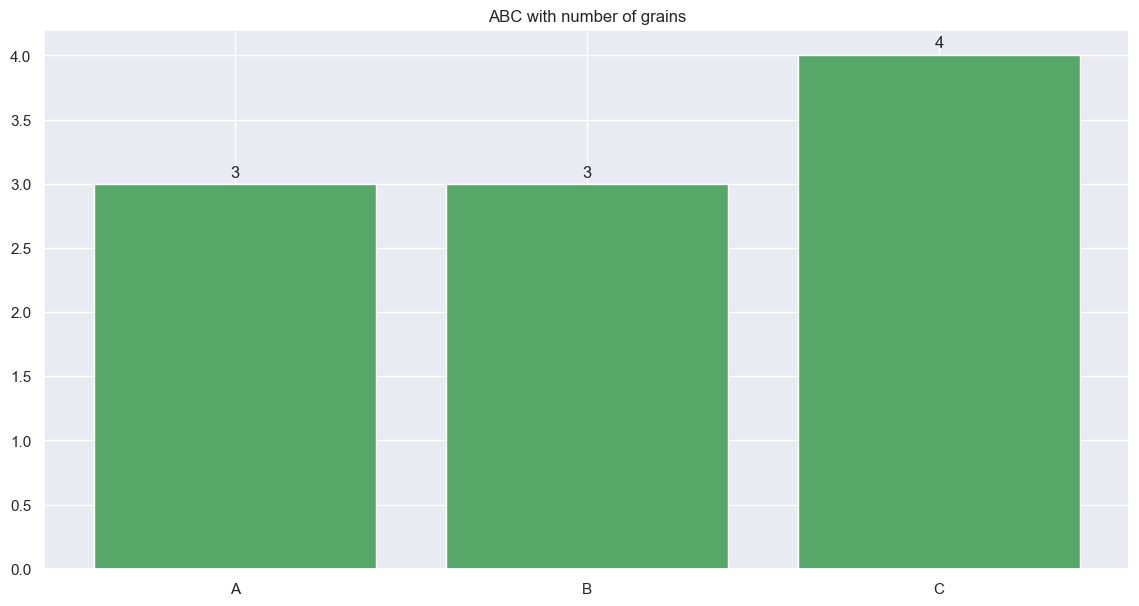

In [33]:
plot_bar(data1 = ABC_result, categorical_col='Vol', counting_columns='product', title='ABC with number of grains', imagefile='ABC with number of grains.png')



In [34]:
# select only high volumn grains 
def vol_category(data, ABC_catetory):
    
    high_volumn_data = data[data[product].isin(list(ABC_result[ABC_result['Vol'].isin([ABC_catetory])][product]))].reset_index(drop=True)
    high_vgrains = list(high_volumn_data[product].drop_duplicates())
    if len(high_vgrains) < 10:
        high_vgrains = high_vgrains[:len(high_vgrains)]
    else:
        high_vgrains = high_vgrains[:10]
    return high_volumn_data, high_vgrains

high_volumn_data, high_vgrains = vol_category(data, ABC_catetory = 'A')
mid_volumn_data, mid_vgrains = vol_category(data, ABC_catetory = 'B')
low_volumn_data, low_vgrains = vol_category(data, ABC_catetory = 'C')


### Bar plot


In [35]:
def get_user_defined_plot(data,title, xlabel= product, ylabel=sales, lift_text= 1,text_formating = False, color='xkcd:lightish blue', round_digit = 2,imagefile='image.png'):
    """
    params:ylabel - for name of ylabel
    xlabel - for name of xlabel
    text_formating - convert large number of text into million (M), K formatting
    round_digit = to disply text on each bar chart and rounding of digit
    """
#     plt.rcParams['figure.figsize'] = [12,8]
    plt.rcParams["axes.linewidth"]  = 1.25
    fig, ax = plt.subplots()
    bar_plot = plt.bar(data[product], data[ylabel], color=color)
    plt.xlabel(product)
    bar_label = round(data[ylabel],2)
    if xlabel is None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(product)
    if ylabel is None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(ylabel)
    plt.title(title)
    
    bar_label = round(data[ylabel],2)
    def autolabel(rects):
        for idx,rect in enumerate(bar_plot):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    bar_label[idx],
                    ha='center', va='bottom', rotation=0)

    autolabel(bar_plot)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.rc('xtick', labelsize=8)
    plt.xticks(rotation = 90);
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))



In [36]:
def get_top_product_sales(data1, gainslist=high_vgrains, bartitle='High Vol products',imagefile = 'image.png'):
    top_10 = data1[data1[product].isin(gainslist)].reset_index(drop=True)
    data_sum = top_10.groupby(product)[sales].sum().reset_index()
    top_10_data = data_sum.nlargest(10, columns = sales).reset_index(drop=True)
    top_10_data['flag'] = bartitle
    get_user_defined_plot(top_10_data,bartitle,lift_text = 30 ,text_formating=True, imagefile=imagefile)
    
    return top_10_data

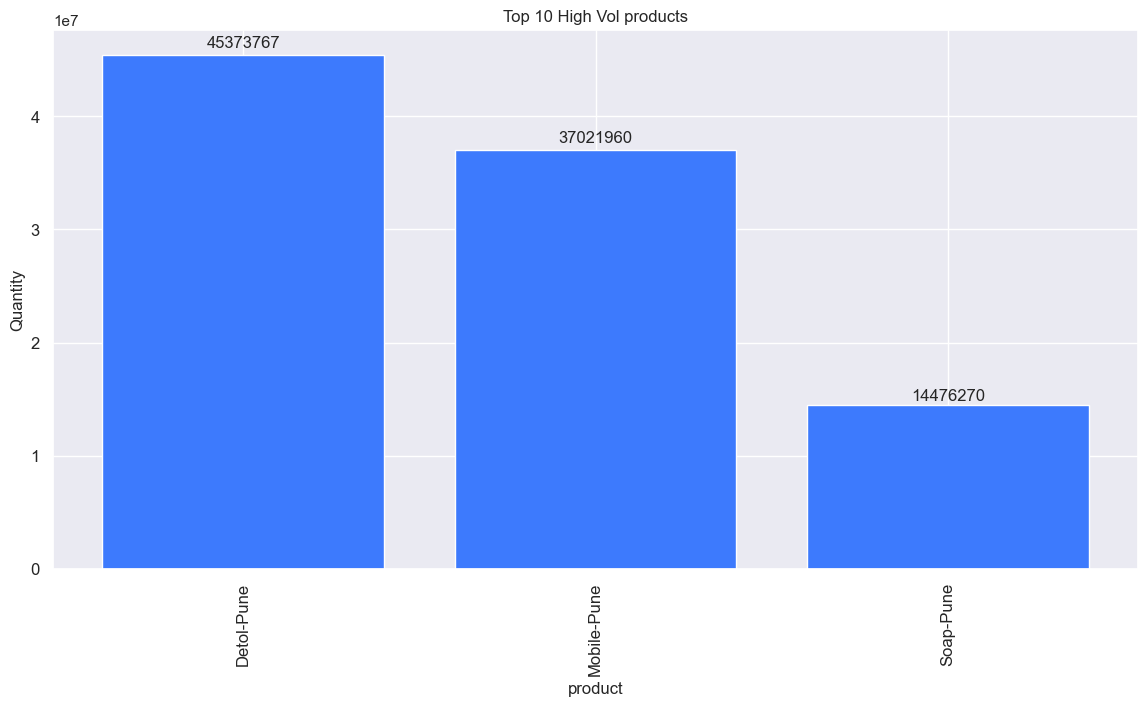

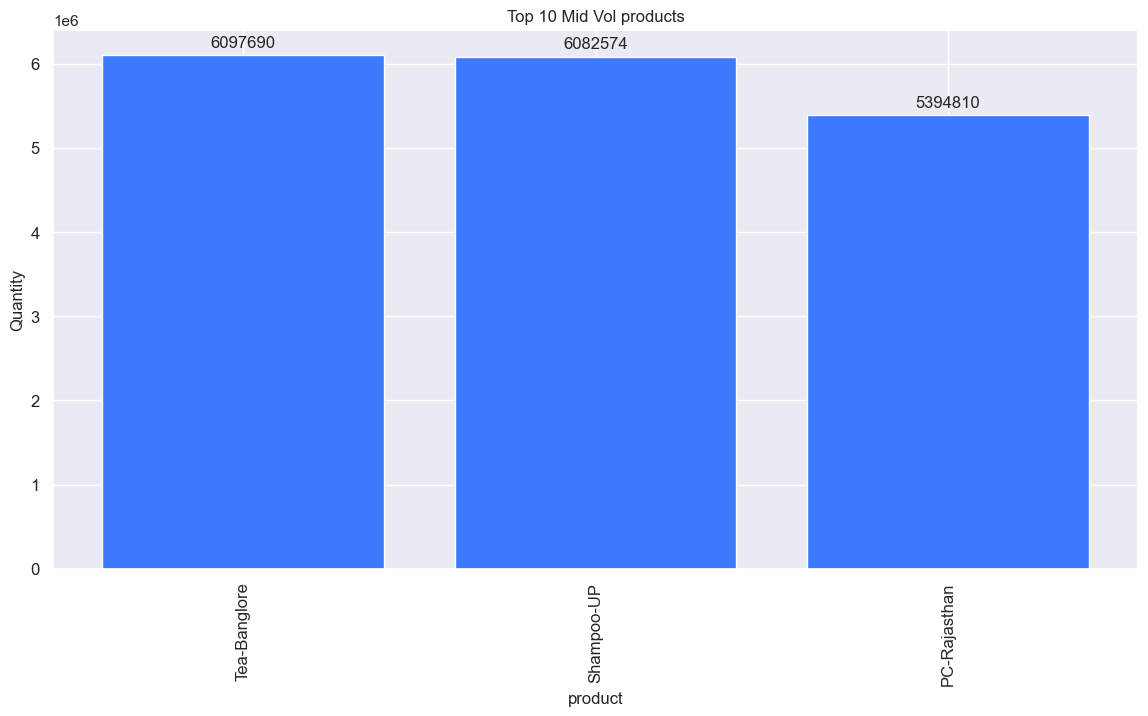

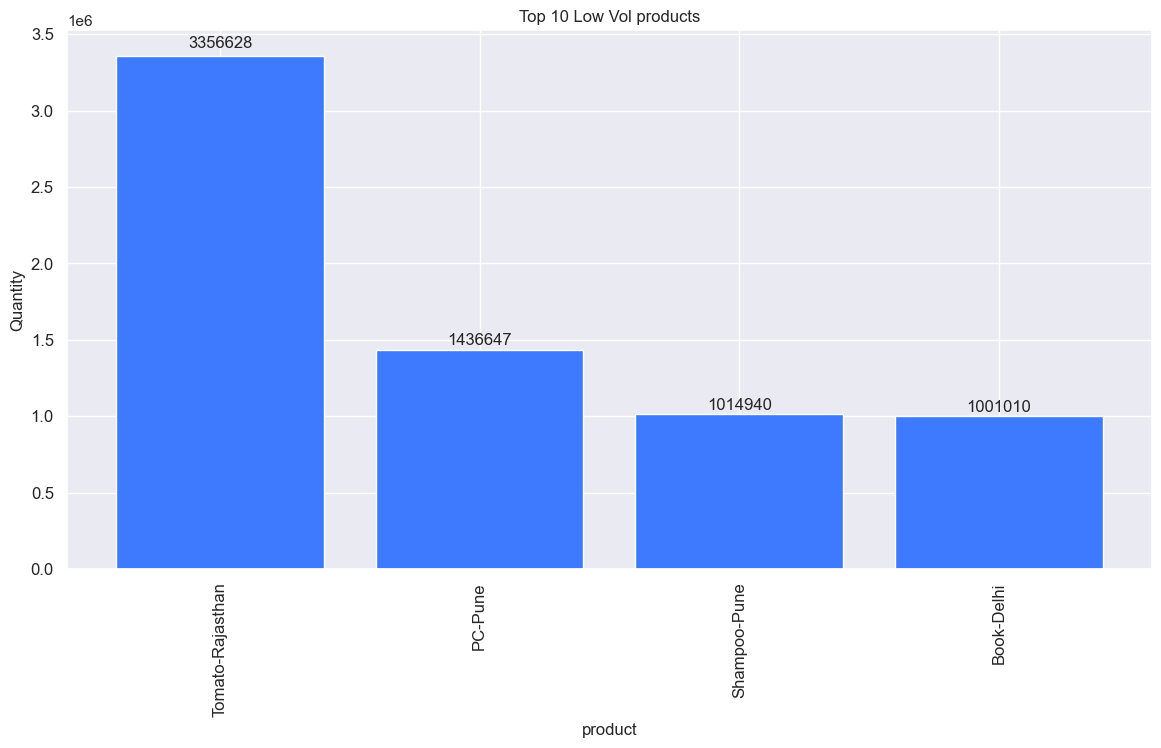

In [37]:
top_10_data = get_top_product_sales(data1,gainslist = high_vgrains, bartitle = 'Top 10 High Vol products',imagefile = 'Top 10 High Vol products.png')
mid_10_data = get_top_product_sales(data1, gainslist = mid_vgrains, bartitle = 'Top 10 Mid Vol products',imagefile = 'Top 10 Mid Vol products.png')
low_10_data = get_top_product_sales(data1, gainslist = low_vgrains, bartitle = 'Top 10 Low Vol products',imagefile = 'Top 10 Low Vol products.png')

In [38]:
# select only high volumn grains 
def get_category(data, category_data = None, filter_col = '', filter_condtion = '',measure_filter_col = None):
    category_data.rename(columns={'unique_id' : product},inplace=True)
    selected_data = data[data[product].isin(list(category_data[category_data[filter_col] == filter_condtion][product]))].reset_index(drop=True)
    selected_grains = list(selected_data[product].drop_duplicates())
    if measure_filter_col is not None:
        if len(selected_grains) > 10 :
            key_grain = category_data[category_data[filter_col] == filter_condtion][[product, measure_filter_col]][:how_many_subplot]
        else:
            key_grain = category_data[category_data[filter_col] == filter_condtion][[product, measure_filter_col]]
            
    elif len(selected_grains) < 10:
        selected_grains = selected_grains[:len(selected_grains)]
        key_grain = category_data[category_data[filter_col] == filter_condtion][[product, filter_col]]

    else:
        selected_grains = selected_grains[:how_many_subplot + 1]
        selected_data = data[data[product].isin(selected_grains)].reset_index(drop=True)
        key_grain = category_data[category_data[filter_col] == filter_condtion][[product, filter_col]]

    return selected_data, selected_grains, key_grain


In [39]:
### libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_manysubplot(data1, title = '', density_plot_flag = False, title_df = pd.DataFrame(), title_filter_col = None, imagefile = 'image.png'):
    '''
    Data1 : Original DataFrame
    title_df : Take grain from the df
    title_filter_col : doc.add_paragraph value on the chart
    '''
    # Initialize the figure style
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(15,15))
    from matplotlib.dates import DateFormatter
    import matplotlib.dates as mdates
    months = mdates.MonthLocator()  # every month
    # create a color palette
    palette = plt.get_cmap('Set1')
    if title_df.shape[0] == 0:
        all_uniq_product = list(data1[product].unique())
        title_filter_col = ''

    else:
        all_uniq_product = list(title_df[product].unique())

    count = len(all_uniq_product)
    
#     data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6] # removed 2.1
#     data1['new_date'] = pd.to_datetime(data1['new_date'],format='%Y-%m-%d') # removed 2.1

    # multiple line plot
    for idx, one_product in enumerate(all_uniq_product[:how_many_subplot],start = 1):
        if title_df.shape[0] == 0:
            orig_value = ''
        else:
            orig_value = title_df[title_df[product] == one_product][title_filter_col].values[0]
        if type(orig_value) == int or type(orig_value) == float:
            title_value = str(round(orig_value,2))
        else:
            title_value = str(orig_value)
            
        ax = plt.subplot(5,5, idx)
        data2 = data1[data1['product'].isin([one_product])];
        plt.plot(data2['new_date'], data2[sales]);
        plt.title(one_product,loc='center', fontsize=10) # x=.6, y=0.85
        if frequency == 'Monthly' :
            date_form = DateFormatter("%y/%m");
        elif frequency == 'Weekly' :
            date_form = DateFormatter("%y/%W");
        elif frequency == 'Daily' :
            date_form = DateFormatter("%y/%m/%d");
        ax.xaxis.set_major_formatter(date_form)
        plt.xticks(rotation = 45);
        plt.title(title + "\n" + one_product + "\n" + title_filter_col + "- "  + title_value)
        fig.tight_layout() # used to maintain space between subplots
    plt.savefig(path + imagefile,bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))

    plt.show();

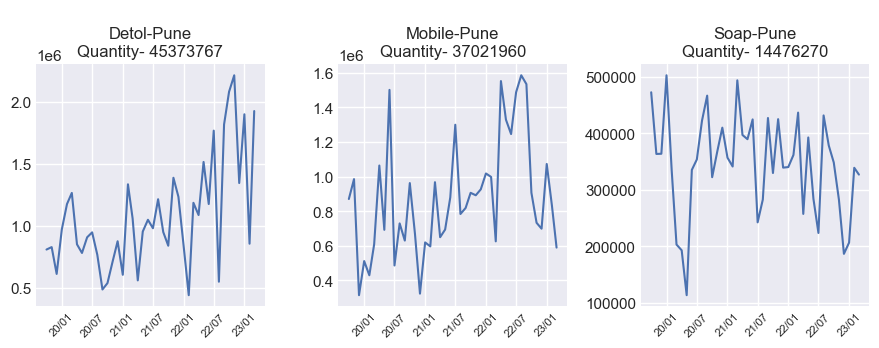

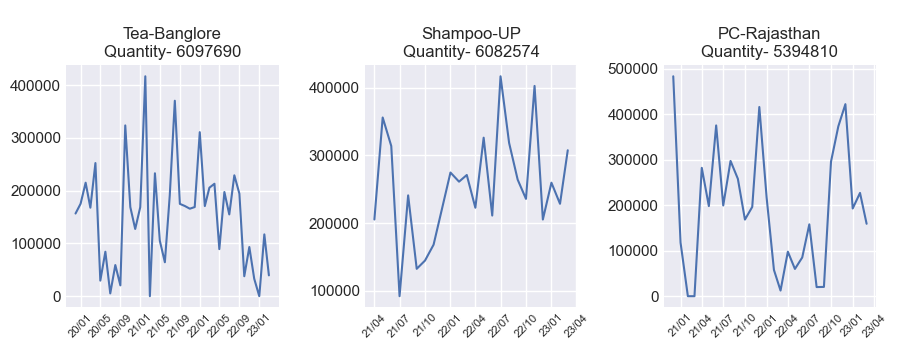

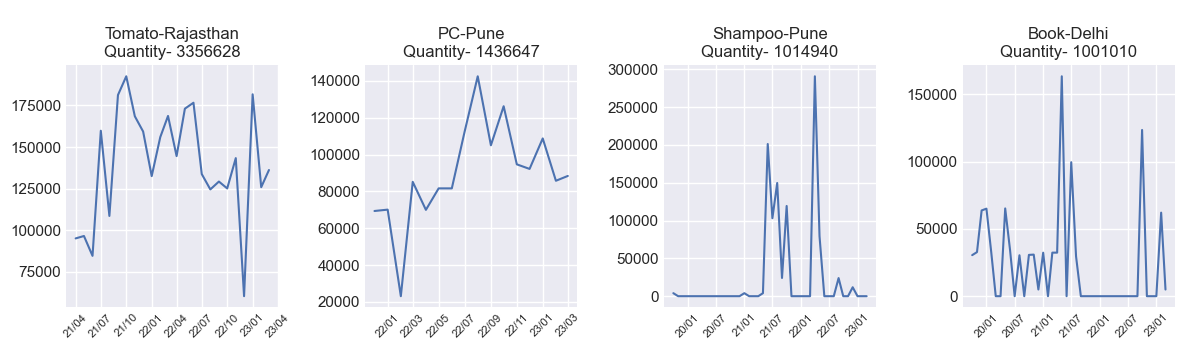

In [40]:
doc.add_paragraph("High Vol Data\n")
highv_data, highv_grains, highv_key_grain = get_category(data1,  
                                                                category_data = top_10_data, 
                                                                filter_col = 'flag', filter_condtion= 'Top 10 High Vol products', 
                                                                measure_filter_col = sales)
plot_manysubplot(data1=highv_data , title_df = highv_key_grain , title_filter_col = sales, imagefile='Subplot Top 10 High Vol products.png')

doc.add_paragraph("Mid Vol Data\n")
midv_data, midv_grains, midv_key_grain = get_category(data1,  
                                                                category_data = mid_10_data, 
                                                                filter_col = 'flag', filter_condtion= 'Top 10 Mid Vol products', 
                                                                measure_filter_col = sales)
plot_manysubplot(data1=midv_data , title_df = midv_key_grain , title_filter_col = sales, imagefile='Subplot Top 10 mid Vol products.png')

doc.add_paragraph("Low Vol Data\n")
lowv_data, lowv_grains, lowv_key_grain = get_category(data1,  
                                                                category_data = low_10_data, 
                                                                filter_col = 'flag', filter_condtion= 'Top 10 Low Vol products', 
                                                                measure_filter_col = sales)
plot_manysubplot(data1=lowv_data , title_df = lowv_key_grain , title_filter_col = sales, imagefile='Subplot Top 10 Low Vol products.png')



### Check for any missing grains

In [41]:
# check if any missing values (nan/na)
def get_missing_parametes(data):
    doc.add_heading(f"{count_number}.Sales Missing Values",1)
    missing_sales = data[data[sales].isna()]
    missing_prod = data[data[product].isna()]
    missing_month = data[data[date].isna()]
    if missing_sales.shape[0] > 0 and missing_prod.shape[0] > 0 and missing_month.shape[0] > 0:
        doc.add_paragraph('Missing Values : Below is the chart for missing values')

        missing_items = missing_sales[product].drop_duplicates()
        msno.heatmap(data)
        msno.dendrogram(data)
        msno.bar(data)
    else:
        doc.add_paragraph('No missing values found')
    return None

In [42]:
get_missing_parametes(data)
count_number += 1


In [43]:
### Nulls in Categorial values

In [44]:
### Number of Categorical features

In [45]:
def return_empty_df(data):
    if data.empty:
        name =[x for x in globals() if globals()[x] is data][0]
        print('Dataframe is empty - ', name)
        doc.add_paragraph(f'Dataframe is empty - {name}')
    return None

### Skew

In [46]:

### libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_manydensitysubplot(data1, title = '', density_plot_flag = False, imagefile = 'image.png'):

    # Initialize the figure style
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(15,15))
    from matplotlib.dates import DateFormatter
    import matplotlib.dates as mdates
    months = mdates.MonthLocator()  # every month
    # create a color palette
    palette = plt.get_cmap('Set1')
    all_uniq_product = list(data1[product].unique())
    count = len(all_uniq_product)
    data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6]
    data1['new_date'] = pd.to_datetime(data1['new_date'],format='%Y-%m-%d')
    data1.new_date = pd.to_datetime(pd.to_datetime(data1["new_date"]).dt.strftime('%Y-%m'))
    # multiple line plot
    data1.new_date = pd.to_datetime(pd.to_datetime(data1["new_date"]).dt.strftime('%Y-%m'))
    from scipy.stats import norm
    for idx, one_product in enumerate(all_uniq_product[:10],start = 1):
        ax = plt.subplot(5,5, idx)
        doc.add_paragraph(ax)
        data2 = data1[data1['product'].isin([one_product])];
        sns.distplot(data2[sales], hist=True, kde=False ,fit = norm,  # kde - Whether to plot a gaussian kernel density estimate.
             bins=int(10), color = color, # distplot =  kdeplot() +  rugplot()
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}) 
        plt.title(one_product,loc='center', fontsize=10) # x=.6, y=0.85
        plt.title(title + "\n" + one_product)
        fig.tight_layout() # used to maintain space between subplots
    plt.show();
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))
    count_number +=1
    return None

In [47]:
def get_devide_in_bins(data, self_divide = False, what_bins = None, number_of_bins=5, chart = None, bin_points=None, label=None,imagefile = 'image.png'):
    '''
    params:data, self_divide = auto dividation in bins,if false then default is 10 bins. Starting from 10 to max 100
    what_bins = column for bin,
    chart = chat type for title
    bin_points : assing a label for bins
    '''
    data1 = data.copy(deep = True)
    fig, ax = plt.subplots()
    if self_divide and bin_points is not None:
        if not label :
            data1['binned'] = pd.cut(data1[what_bins], bin_points, duplicates='drop')
            count_grain_bin= data1.groupby(['binned'])[product].nunique().reset_index()
            count_grain_bin.binned = count_grain_bin.binned.astype(str)
        elif label :
            data1['binned'] = pd.cut(data1[what_bins], bin_points, duplicates='drop',labels = label)
            count_grain_bin= data1.groupby(['binned'])[product].nunique().reset_index()
            count_grain_bin.binned = count_grain_bin.binned.astype(str)
    elif self_divide and number_of_bins is None:
        data1['binned'] = pd.cut(data1[what_bins], number_of_bins, duplicates='drop')
        count_grain_bin= data1.groupby(['binned'])[product].nunique().reset_index()
        count_grain_bin.binned = count_grain_bin.binned.astype(str)
    else:
        bins = [0, 10, 20, 30,40,50,60,70,80,90,100, data1[what_bins].max()]
        data1['binned'] = pd.cut(data1[what_bins], bins, include_lowest=True, duplicates='drop')
        count_grain_bin= data1.groupby(['binned'])['product'].nunique().reset_index()
        count_grain_bin.binned = count_grain_bin.binned.astype(str)
        count_grain_bin.binned = ["10", '20','30','40','50','60','70','80','90','100','>100']
    count_grain_bin['binned'] =  count_grain_bin['binned'].astype(str)
    plt.rcParams['figure.figsize'] = [12,7]
    bar_plot=plt.bar(count_grain_bin["binned"], count_grain_bin[product], color='g')
    total = float(len(data1))
    bar_label = round(count_grain_bin[product],2) # this should be count to be doc.add_paragraphed
    def autolabel(rects):
        for idx,rect in enumerate(bar_plot):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2, 1.01*height,
                    bar_label[idx],
                    ha='center', va='bottom', rotation=0)

    autolabel(bar_plot)
    plt.title(chart +' vs Grains')
    plt.ylabel('Grain Count')
    plt.xlabel('Bin Distribution')
    plt.rc('xtick',labelsize=10);
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))
    return None



In [48]:
def get_skew_kurtosis(data):
    doc.add_heading(f"{count_number}.Skewness",1)
    skewed_data = data.groupby([product])[sales].skew().round(3).reset_index().rename(columns  = {sales : 'skew_number'})
    skewed_data['skewness'] = 'Normal'
    skewed_data.loc[skewed_data['skew_number'] <-1, 'skewness'] = 'left_skewed'
    skewed_data.loc[skewed_data['skew_number'] > 1, 'skewness'] = 'right_skewed'
    doc.add_paragraph("          Ideal skewness is less than -1 or greater than 1, the distribution is highly skewed. If " +  
          "skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed."+ 
          "If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.The Ideal values "+  
          "kurtosis between -2 and +2 are considered acceptable")
    return skewed_data[[product,'skew_number','skewness']]


In [49]:
skewed_data = get_skew_kurtosis(data)
skewed_data.head()

product  skew_number      skewness
0    Book-Delhi     2.104000  right_skewed
1    Detol-Pune     0.917000        Normal
2   Mobile-Pune     0.608000        Normal
3       PC-Pune    -0.402000        Normal
4  PC-Rajasthan     0.380000        Normal

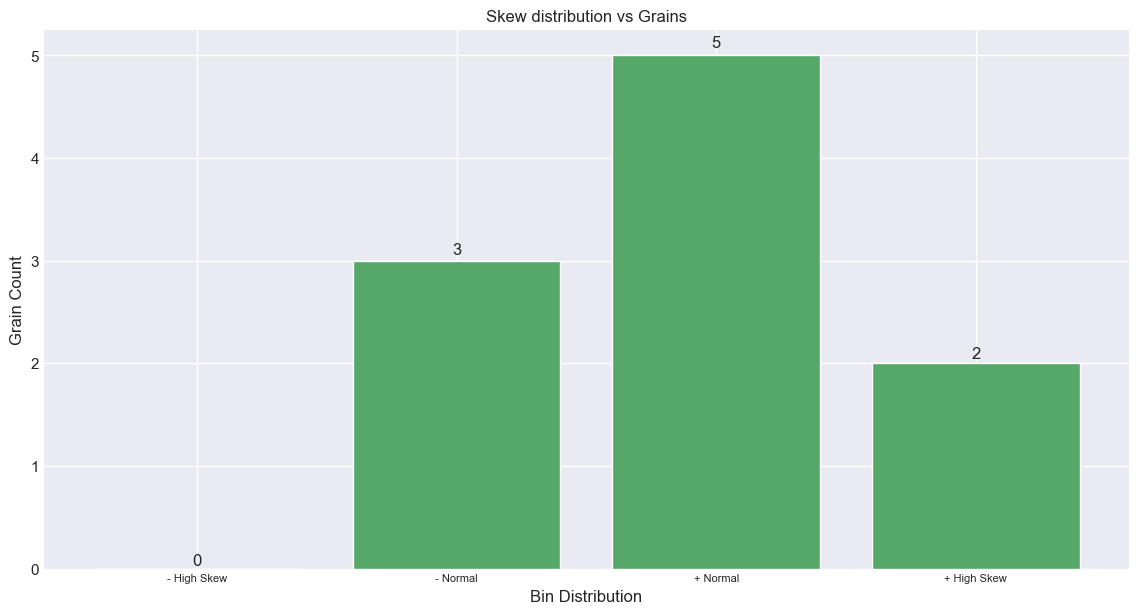

In [50]:
get_devide_in_bins(skewed_data,self_divide=True,what_bins = 'skew_number', 
                   chart='Skew distribution',bin_points=[-np.inf,-1,0,1, +np.inf],
                   label=['- High Skew','- Normal','+ Normal','+ High Skew'], imagefile='Skew distribution.png')

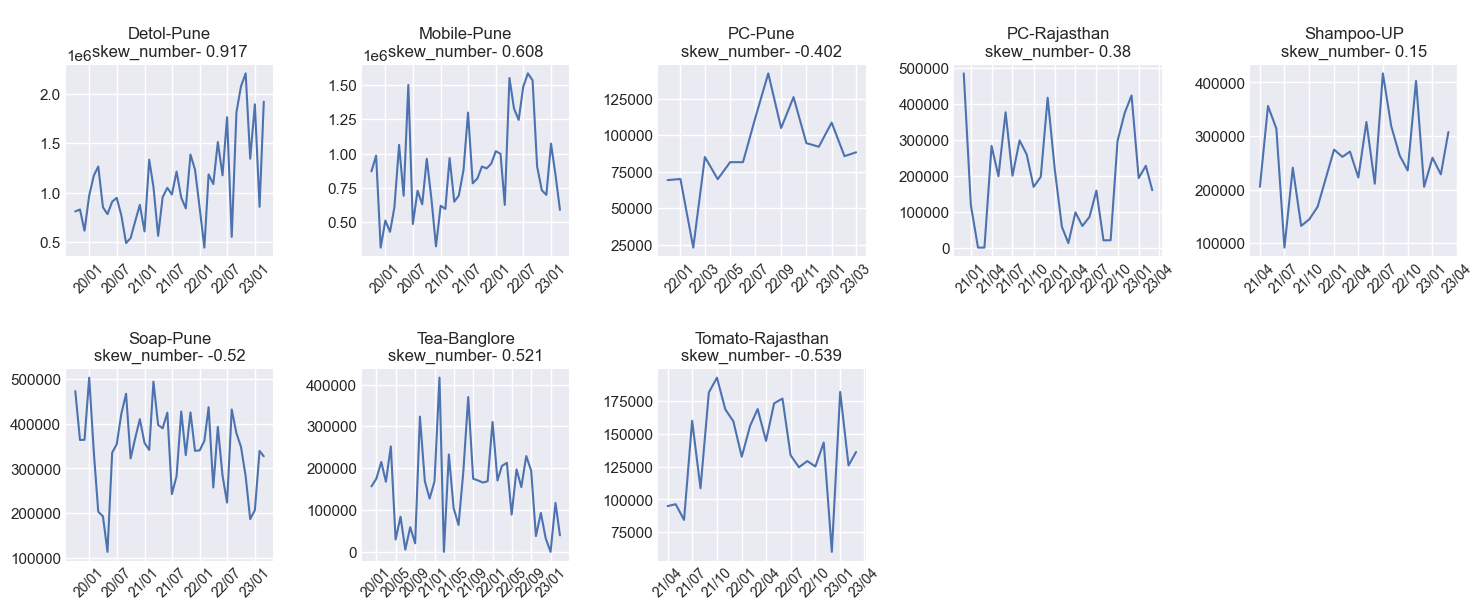

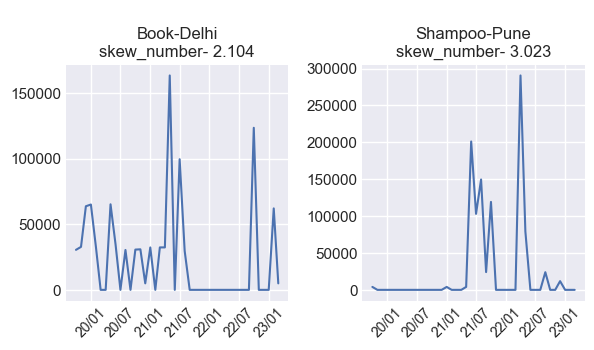

Dataframe is empty -  left_skewed_data


In [51]:
doc.add_paragraph("No Skew/Normal Data\n")

normal_data, normal_grains, normal_key_grain = get_category(data1,  
                                                                category_data = skewed_data, 
                                                                filter_col = 'skewness', filter_condtion= 'Normal', 
                                                                measure_filter_col = 'skew_number')
if normal_data.empty:
    doc.add_paragraph(f'{return_empty_df(normal_data)}')
else: 
    plot_manysubplot(data1=normal_data , title_df = normal_key_grain , title_filter_col = 'skew_number',imagefile='no_skew.png');


doc.add_paragraph("Right Skewed Data\n")
right_skewed_data, right_skewed_grains, right_skewed_key_grain = get_category(data1,  
                                                                category_data = skewed_data, 
                                                                filter_col = 'skewness', filter_condtion= 'right_skewed', 
                                                                measure_filter_col = 'skew_number')
if right_skewed_data.empty:
    doc.add_paragraph(f'{return_empty_df(right_skewed_data)}')
else: 
    plot_manysubplot(data1=right_skewed_data , title_df = right_skewed_key_grain , title_filter_col = 'skew_number',imagefile='right_skew.png')
# plot_manydensitysubplot(right_skewed_data,title ='Right skewed data');


doc.add_paragraph("Left Skewed Data\n")
left_skewed_data, left_skewed_grains, left_skewed_key_grain = get_category(data1,  
                                                                category_data = skewed_data, 
                                                                filter_col = 'skewness', filter_condtion= 'left_skewed', 
                                                                measure_filter_col = 'skew_number')
if left_skewed_data.empty:
    doc.add_paragraph(f'{return_empty_df(left_skewed_data)}')
else: 
    plot_manysubplot(data1=left_skewed_data , title_df = left_skewed_key_grain , title_filter_col = 'skew_number',imagefile='left_skew.png')
# plot_manydensitysubplot(left_skewed_data,title ='Left skewed data');



In [52]:
# plot_manysubplot(neg_skew_data, title = 'Right Skewed', density_plot_flag=True)


In [53]:
# def check_desity_destribution(data, grain = None):
#     # kde : Whether to plot a gaussian kernel density estimate.
#     # norm : maximum likelihood gaussian distribution fit
#     from scipy.stats import norm
#     if grain is not None:
#         one = data.loc[data[product] ==  grain][sales]
#     else:
#         one = data.groupby(product)[sales].mean().reset_index()[sales]
# #      one = data.copy(deep = True)[sales]
#     fig, ax = plt.subplots(figsize=(10,6))
#     sns.distplot(one, hist=True, kde=False ,fit = norm,  # kde - Whether to plot a gaussian kernel density estimate.
#              bins=int(10), color = color, # distplot =  kdeplot() +  rugplot()
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 3})
#     plt.legend(['norm'])

### Ploting Highly Skewed Product Time Series

### Creating Time features

In [54]:
data1.head()

Product    Date  Quantity     product   new_date
0  Book-Delhi  201910     30480  Book-Delhi 2019-10-01
1  Book-Delhi  201911     32730  Book-Delhi 2019-11-01
2  Book-Delhi  201912     63680  Book-Delhi 2019-12-01
3  Book-Delhi  202001     65010  Book-Delhi 2020-01-01
4  Book-Delhi  202002     32610  Book-Delhi 2020-02-01

In [55]:
#data[dates] = pd.to_datetime(data[date])
def creating_date_features(data):
    doc.add_heading(f'{count_number}.Creating Time Series Feature',1)
    doc.add_paragraph(f'Day, Dayofyear, dayofweek, month, year, weekofyear, start date and end date')
    data1 = data.copy(deep = True)
#     data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6] # removed 2.1
#     data1['new_date'] = pd.to_datetime(data1['new_date'],format='%Y-%m-%d') # removed 2.1
    data1['dayofmonth'] = data1['new_date'].dt.day
    data1['dayofyear'] = data1['new_date'].dt.dayofyear
    data1['dayofweek'] = data1['new_date'].dt.dayofweek
    data1['month'] = data1['new_date'].dt.month
    data1['year'] = data1['new_date'].dt.year
    data1['weekofyear'] = data1['new_date'].dt.weekofyear
    data1['is_month_start'] = (data1['new_date'].dt.is_month_start).astype(int)
    data1['is_month_end'] = (data1['new_date'].dt.is_month_end).astype(int)
    return data1

In [56]:
# data1 = data.copy()
data_with_date_feature = creating_date_features(data1)
data_with_date_feature.head()
count_number += 1

Product    Date  Quantity     product   new_date  dayofmonth  dayofyear  \
0  Book-Delhi  201910     30480  Book-Delhi 2019-10-01           1        274   
1  Book-Delhi  201911     32730  Book-Delhi 2019-11-01           1        305   
2  Book-Delhi  201912     63680  Book-Delhi 2019-12-01           1        335   
3  Book-Delhi  202001     65010  Book-Delhi 2020-01-01           1          1   
4  Book-Delhi  202002     32610  Book-Delhi 2020-02-01           1         32   

   dayofweek  month  year  weekofyear  is_month_start  is_month_end  
0          1     10  2019          40               1             0  
1          4     11  2019          44               1             0  
2          6     12  2019          48               1             0  
3          2      1  2020           1               1             0  
4          5      2  2020           5               1             0

In [57]:
def combined_charts(pv_table, title='seasonality', x_label = None,imagefile = 'image.png'):
    plt.get_cmap('gist_rainbow')
    plt.plot(pv_table)
    plt.legend(pv_table.columns)
    plt.title(title)
    plt.ylabel('Agg sales')
    plt.xlabel(x_label)
    plt.show()
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))
    

### Aggregate plots 
### --> Monthly plot

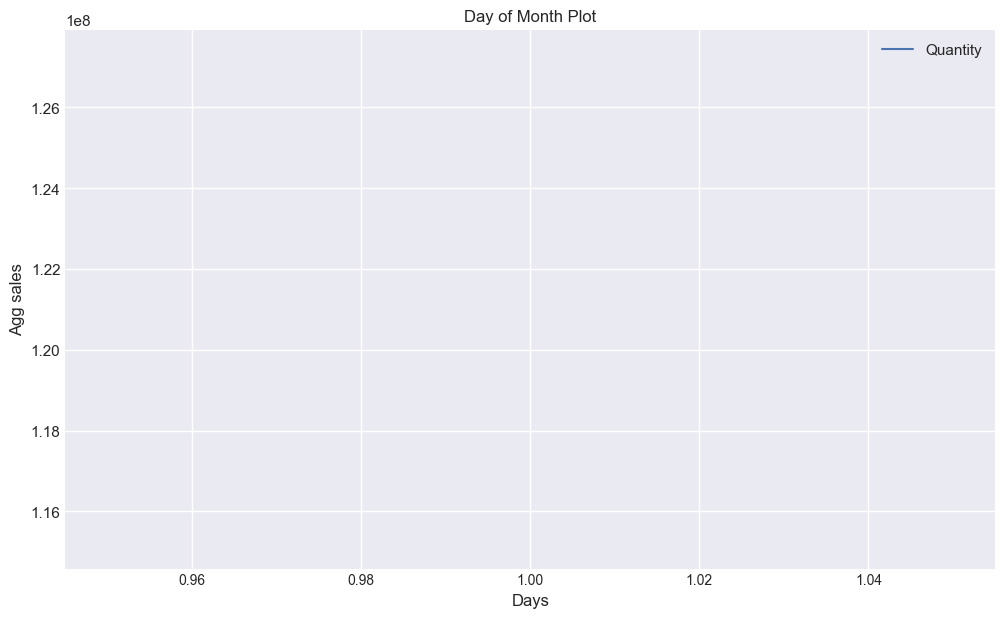

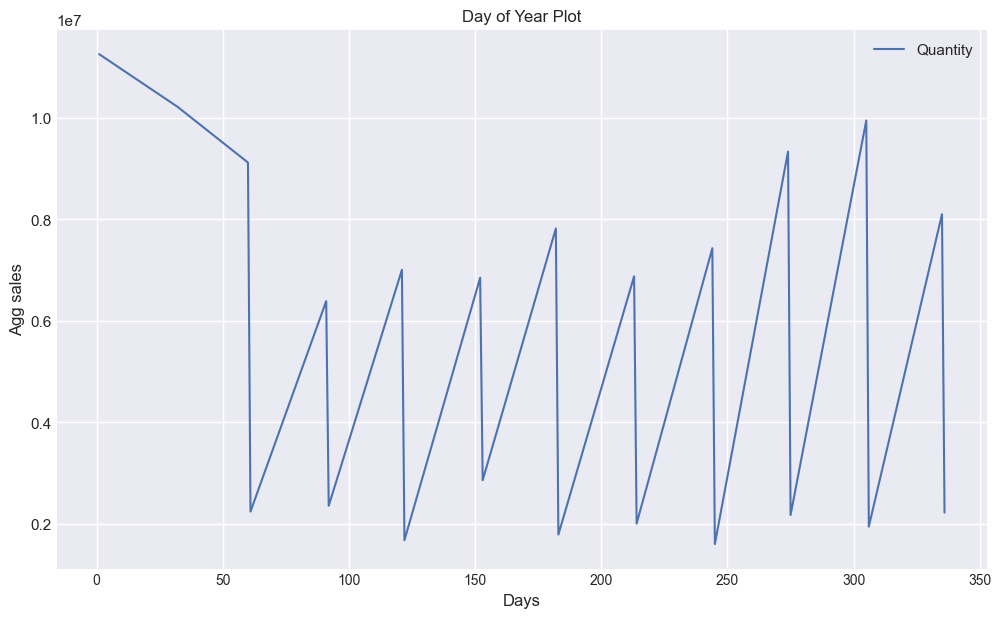

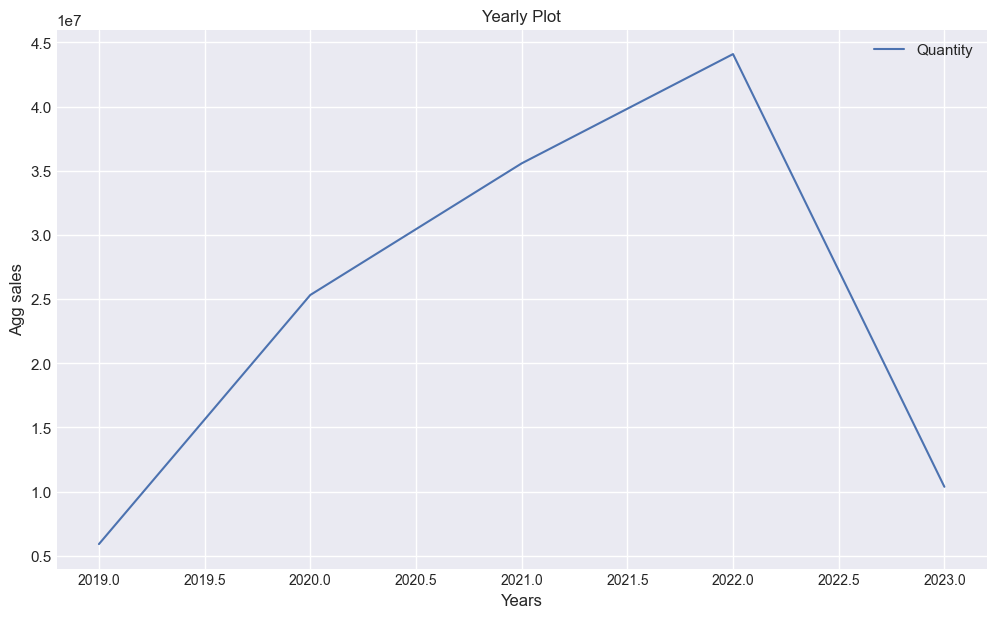

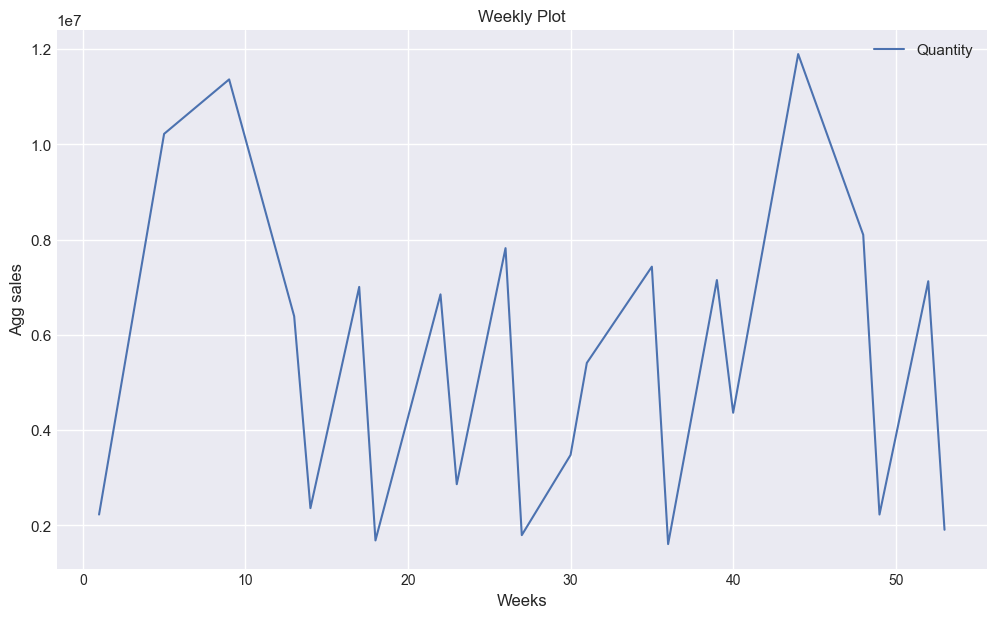

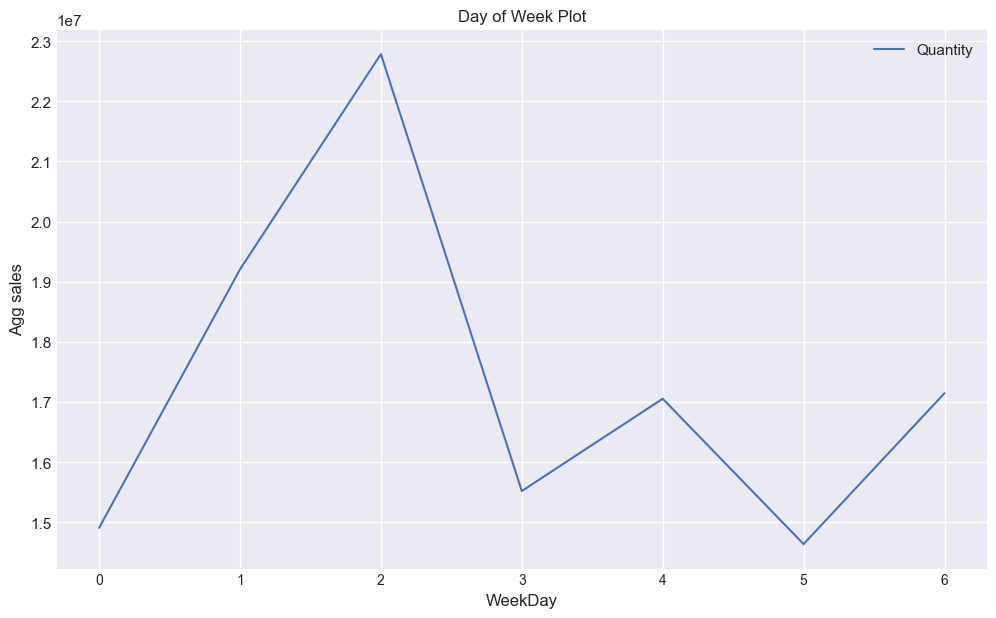

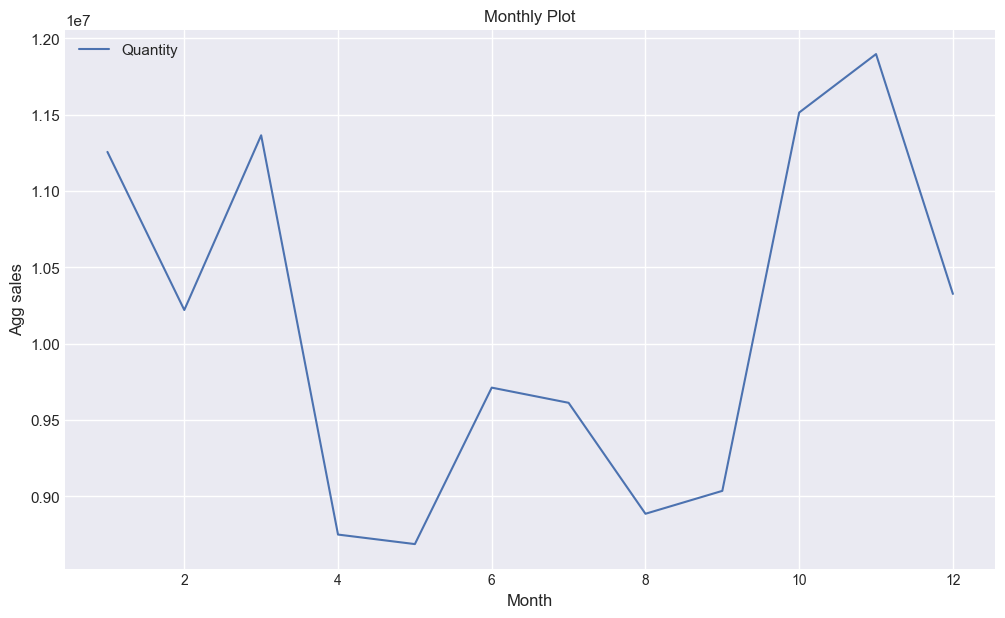

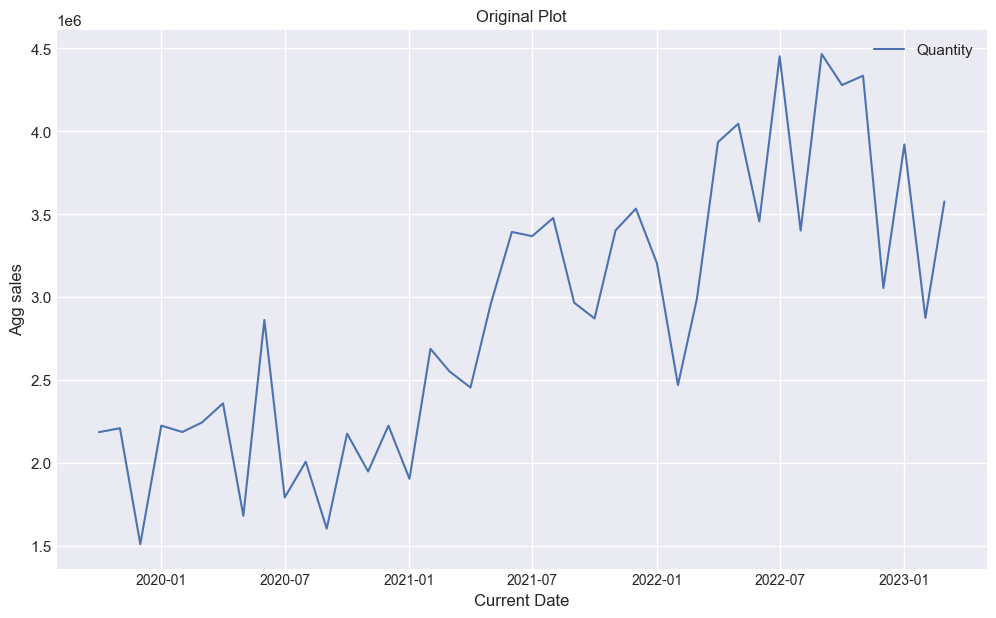

<Figure size 1200x700 with 0 Axes>

In [58]:
def monthly_yearly_weekly_chart(data):
    month_day_agg = data.groupby(['dayofmonth'])[[sales]].sum()
    daily_agg = data.groupby(['dayofyear'])[[sales]].sum()
    weekday_agg = data.groupby(['dayofweek'])[[sales]].sum()
    month_agg = data.groupby(['month'])[[sales]].sum()
    year_agg = data.groupby(['year'])[[sales]].sum()
    weekofyear_agg = data.groupby(['weekofyear'])[[sales]].sum()
    original_agg = data.groupby(['new_date'])[[sales]].sum()
    combined_charts(month_day_agg, 'Day of Month Plot', x_label = 'Days',imagefile='Day_of_Month_Plot.png')
    combined_charts(daily_agg, 'Day of Year Plot', x_label = 'Days',imagefile='Day_of_year_Plot.png')
    combined_charts(year_agg, 'Yearly Plot', x_label = 'Years',imagefile='Yearly_Plot.png')
    combined_charts(weekofyear_agg, 'Weekly Plot', x_label = 'Weeks',imagefile='Weekly_Plot.png')
    combined_charts(weekday_agg, 'Day of Week Plot', x_label = 'WeekDay',imagefile='Day_of_Week_Plot.png')
    combined_charts(month_agg, 'Monthly Plot', x_label = 'Month',imagefile='Monthly_Plot.png')
    combined_charts(original_agg, 'Original Plot', x_label = 'Current Date',imagefile='CurrentDate_Plot.png')

monthly_yearly_weekly_chart(data_with_date_feature)

In [59]:
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    gpby = df.groupby(gpby_cols)
    newdf = pd.DataFrame()
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = df.merge(aggdf, on=gpby_cols, how='left')
        df = newdf.copy(deep = True)
    return newdf

In [60]:
agg_funcs = {'month_sum': np.sum, 'month_mean' : np.mean}
gpby_cols = ['month', product]
df_month_featues = create_sales_agg_monthwise_features(data_with_date_feature,gpby_cols,target_col = sales, agg_funcs = agg_funcs)
df_month_featues.head()

Product    Date  Quantity     product   new_date  dayofmonth  dayofyear  \
0  Book-Delhi  201910     30480  Book-Delhi 2019-10-01           1        274   
1  Book-Delhi  201911     32730  Book-Delhi 2019-11-01           1        305   
2  Book-Delhi  201912     63680  Book-Delhi 2019-12-01           1        335   
3  Book-Delhi  202001     65010  Book-Delhi 2020-01-01           1          1   
4  Book-Delhi  202002     32610  Book-Delhi 2020-02-01           1         32   

   dayofweek  month  year  weekofyear  is_month_start  is_month_end  \
0          1     10  2019          40               1             0   
1          4     11  2019          44               1             0   
2          6     12  2019          48               1             0   
3          2      1  2020           1               1             0   
4          5      2  2020           5               1             0   

   Quantity_month_sum  Quantity_month_mean  
0              184600         46150.000000  
1               63610         15902.500000  
2               68650         17162.500000  
3               97310         24327.500000  
4               94660         23665.000000

### Overall Time series plot with agg monthly

In [61]:
def plot_all(data, grain = None, sales = sales, title = 'Time Series Plot', imagefile = 'image.png'):
    if grain is not None:
        one = data.loc[data[product] ==  grain]
    else:
        one = data.copy(deep = True)
        one = one.groupby([date])[sales].agg(Sales ='sum').reset_index() 
        sales='Sales'
    one[date] = one.loc[:,date].astype(str)
#    if len(one[date].iloc[0]) == 10: # removed 2.1
#         one[date] = one.loc[:,date].str[:4] + '-' + one.loc[:,date].str[5:7]  removed 2.1
#    else: # removed 2.1
#         one[date] = one.loc[:,date].str[:4] + '-' + one.loc[:,date].str[4:6]  removed 2.1
#     one[date] = pd.to_datetime(one[date]).dt.strftime('%Y-%m') # removed 2.1
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(one[date], one[sales],label = sales)
    date_size = len(one[date])
    plt.xticks([str(one[date].values[i]) for i in range(len(one[date])) if i%3 == 1], rotation=45)
    plt.xlabel("Date")
    plt.ylabel('Qty',)
    #plt.xticks(l)
    #plt.rc('xtick', labelsize=8)
    plt.rc('xtick',labelsize = 12)
    if grain is not None:
        ax = plt.title('Grain - '+ str(grain) +'\n',y = .88,fontsize = 14 )
    else:
        ax = plt.title(title)
    ax = plt.legend(loc = 'best')

    pic = plt.savefig(path + imagefile, bbox_inches='tight');
    doc.add_picture(path + imagefile, width = Inches(6));
    plt.show();

In [62]:
def create_sales_agg_weekwise_features(df, gpby_cols, target_col, agg_funcs):
    gpby = df.groupby(gpby_cols)
    newdf = pd.DataFrame()
    for agg_name, agg_func in agg_funcs.items():
        doc.add_paragraph(agg_name)
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = df.merge(aggdf, on=gpby_cols, how='left')
        df = newdf.copy(deep = True)

    return newdf

In [63]:
agg_funcs = {"week_sum" : np.sum, 'week_mean' : np.mean}
gpby_cols = ['dayofweek', product]
new_week_features = create_sales_agg_monthwise_features(data_with_date_feature,gpby_cols,target_col = sales, agg_funcs = agg_funcs)
new_week_features.head(2)
count_number +=1


Product    Date  Quantity     product   new_date  dayofmonth  dayofyear  \
0  Book-Delhi  201910     30480  Book-Delhi 2019-10-01           1        274   
1  Book-Delhi  201911     32730  Book-Delhi 2019-11-01           1        305   

   dayofweek  month  year  weekofyear  is_month_start  is_month_end  \
0          1     10  2019          40               1             0   
1          4     11  2019          44               1             0   

   Quantity_week_sum  Quantity_week_mean  
0              35450         5064.285714  
1             130200        21700.000000

In [64]:

# plot_all(new_week_features,sales = sales + '_week_sum', title = 'Sales with agg sum ', imagefile='Sales with agg sum.png') # removed 2.1
# plot_all(new_week_features,sales = sales + '_week_mean', title = 'Sales with agg mean ', imagefile='Sales with agg sum.png') # removed 2.1
    

In [65]:
# data = {"Team": ["Red Sox", "Red Sox", "Red Sox", "Red Sox", "Red Sox", "Red Sox", "Yankees", "Yankees", "Yankees", "Yankees", "Yankees", "Yankees"],
# 		"Pos": ["Pitcher", "Pitcher", "Pitcher", "Not Pitcher", "Not Pitcher", "Not Pitcher", "Pitcher", "Pitcher", "Pitcher", "Not Pitcher", "Not Pitcher", "Not Pitcher"],
# 		"Age": [24, 28, 40, 22, 29, 33, 31, 26, 21, 36, 25, 31]}
# df = pd.DataFrame(data)
# doc.add_paragraph(df)
# grouped_single = df.groupby('Team',as_index = False).Age.agg(['mean', 'min', 'max'])

# doc.add_paragraph(grouped_single)

In [66]:
def get_date_datetime(date):
    date_new = str(date)[:4] + '-' + str(date)[4:6] 
    lastdate_new = pd.to_datetime(date_new, format='%Y-%m-%d')
    return lastdate_new

### Outlier detection

In [67]:

### libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_outlier_subplot(data1, title = 'Plot', density_plot_flag = False, imagefile = 'image.png'):
    # Initialize the figure style
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(15,15))
    # create a color palette
    palette = plt.get_cmap('Set1')
    all_uniq_product = list(data1[product].unique())
    count = len(all_uniq_product)
#     data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6] # removed 2.1
#     data1['new_date'] = pd.to_datetime(data1['new_date'],format='%Y-%m-%d') # removed 2.1
#     data1.new_date = pd.to_datetime(pd.to_datetime(data1["new_date"]).dt.strftime('%Y-%m')) # removed 2.1
    # multiple line plot
#     data1.new_date = pd.to_datetime(pd.to_datetime(data1["new_date"]).dt.strftime('%Y-%m')) # removed 2.1
    from scipy.stats import norm
    for idx, one_product in enumerate(all_uniq_product[:10],start = 1):
        ax = plt.subplot(5,5, idx)
        data2 = data1[data1['product'].isin([one_product])];
        data2[sales].plot(kind = 'box')
        plt.title(one_product,loc='center', fontsize=10) # x=.6, y=0.85
        plt.title(title + "\n" + one_product)
        fig.tight_layout() # used to maintain space between subplots
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))
    plt.show();



#     for idx, one_product in enumerate(all_uniq_product[:how_many_subplot],start = 1):
#         if title_df.shape[0] == 0:
#             orig_value = ''
#         else:
#             orig_value = title_df[title_df[product] == one_product][title_filter_col].values[0]
#         if type(orig_value) == int or type(orig_value) == float:
#             title_value = str(round(orig_value,2))
#         else:
#             title_value = str(orig_value)

#         ax = plt.subplot(5,5, idx)
#         data2 = data1[data1['product'].isin([one_product])];
#         plt.plot(data2['new_date'], data2[sales]);
#         plt.title(one_product,loc='center', fontsize=10) # x=.6, y=0.85
#         date_form = DateFormatter("%y/%m");
#         ax.xaxis.set_major_formatter(date_form)
#         plt.xticks(rotation = 45);
#         plt.title(title + "\n" + one_product + "\n" + title_filter_col + "- "  + title_value)
#         fig.tight_layout() # used to maintain space between subplots
#     plt.savefig(path + imagefile,bbox_inches='tight')
#     doc.add_picture(path + imagefile, width = Inches(6))

#     plt.show();

### Box plot for 20 outlier data with line plot

In [68]:
# if high_outlier_data.empty and low_outlier_data.empty:
#     doc.add_paragraph("No upper and lower outlier found")
# elif high_outlier_data.empty :
#     doc.add_paragraph("No upper outlier found") 
#     plot_outlier_subplot(low_outlier_data, title = 'Lower Outlier plot')
#     plot_manysubplot(low_outlier_data, title='Line plot')
# elif low_outlier_data.empty:
#     doc.add_paragraph("No lower outlier found")
#     plot_outlier_subplot(high_outlier_data, title = 'Upper Outlier plot')
#     plot_manysubplot(high_outlier_data, title='Line plot')


In [69]:
# def fill_with_mean_zscore(x, zscore):
#     x[sales] = np.where(x['z_score'] > zscore,sales, x[sales].mean())
#     return x


### Outlier using Zscore

In [70]:
from scipy import stats
def outlier_zscore(data,zscore = None):
    data_zscore = pd.concat([data[[product,date]],data.groupby([product])[sales].transform
                             (lambda x : stats.zscore(x, nan_policy = 'omit'))],axis = 1)
    data_zscore = data_zscore.rename(columns = {sales:'z_score'})
    data_zscore = pd.concat([data_zscore,data[sales]], axis = 1)  
    # remove nan in z score (Na in z)
    if data_zscore['z_score'].isna().any():
        na_z_grains = data_zscore[data_zscore['z_score'].isna()][product]
        doc.add_paragraph('Nan is present in Zscore for grains - {}\n '.format(len(na_z_grains)))
        doc.add_paragraph("List of NA Zscore grains - {}".format(list(na_z_grains)))
        data_zscore = data_zscore[~data_zscore['z_score'].isna()]  
    def outlier(x, zscore):
        if any(x['z_score'] >= zscore):
            x['z_outlier'] = 'Upper Outlier' # this is true
            x['flag_oulier'] = True
            x['no_of_outlier'] = int(sum(x['z_score'].values >= zscore))
        elif any(x['z_score'] <= -zscore):
            x['z_outlier'] = 'Lower Outlier' # this is true
            x['flag_oulier'] = True
            x['no_of_outlier'] = sum(x['z_score'].values <= -zscore)

        elif any(x['z_score'] <= -zscore) and any(x['z_score'] >= zscore):
            x['z_outlier'] = 'Lower and Upper Outlier' # this is true
            x['flag_oulier'] = True
            x['no_of_outlier'] = sum(x['z_score'].values <= -zscore and x['z_score'].values >= zscore)
        else:
            x['z_outlier'] = 'No outlier'
            x['flag_oulier'] = False
            x['no_of_outlier'] = 0
        return x
    

    data_zscore = data_zscore.groupby([product]).apply(lambda x : outlier(x, zscore)) 
    doc.add_heading(f"{count_number}.Outlier",1)
    data_zscore_1= data_zscore[data_zscore['z_outlier'].isin(['Upper Outlier','Lower Outlier'])]
    list_data_zscore_1 = data_zscore_1[product].drop_duplicates()
    doc.add_paragraph('Product {} has Zscore greater/less then {}, treated as outliers'.format(len(list_data_zscore_1),zscore))
    max_zscore = data_zscore[data_zscore.z_score == max(data_zscore.z_score)]
    min_zscore = data_zscore[data_zscore.z_score == min(data_zscore.z_score)]
    doc.add_paragraph("Min Zscore {} is belong to {} product".format(round(min(data_zscore.z_score),2), min_zscore[product].values[0]))
    doc.add_paragraph("Max Zscore {} is belong to {} product".format(round(max(data_zscore.z_score),2), max_zscore[product].values[0]))

    return data_zscore[[product,'z_outlier','flag_oulier','no_of_outlier']].drop_duplicates().reset_index(drop=True)


In [71]:

zscore_data = outlier_zscore(data1, zscore = 3)
count_number +=1

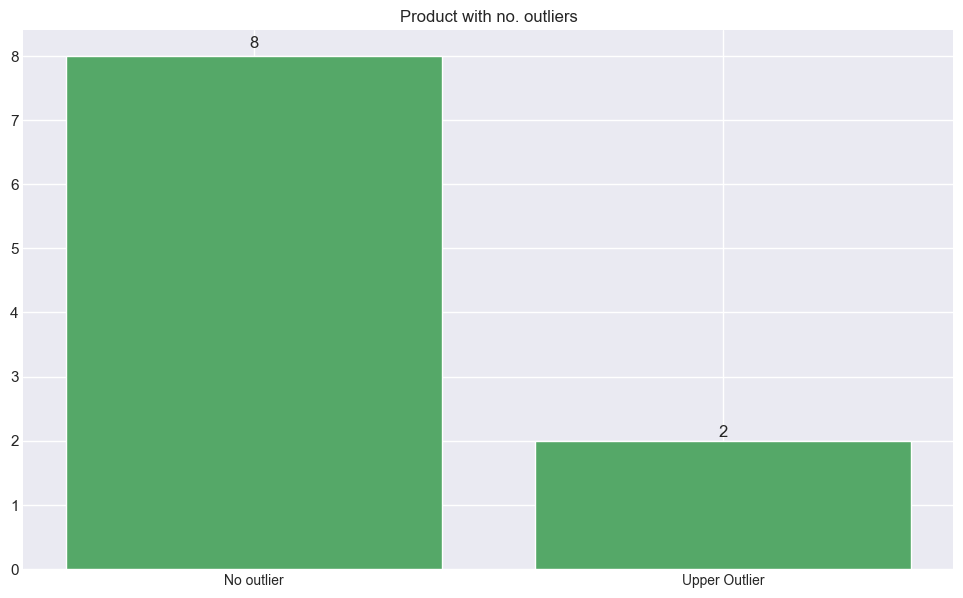

In [72]:
plot_bar(
    zscore_data,
    categorical_col='z_outlier',
    counting_columns='product',
    title='Product with no. outliers',imagefile='Product with nooutliers.png')

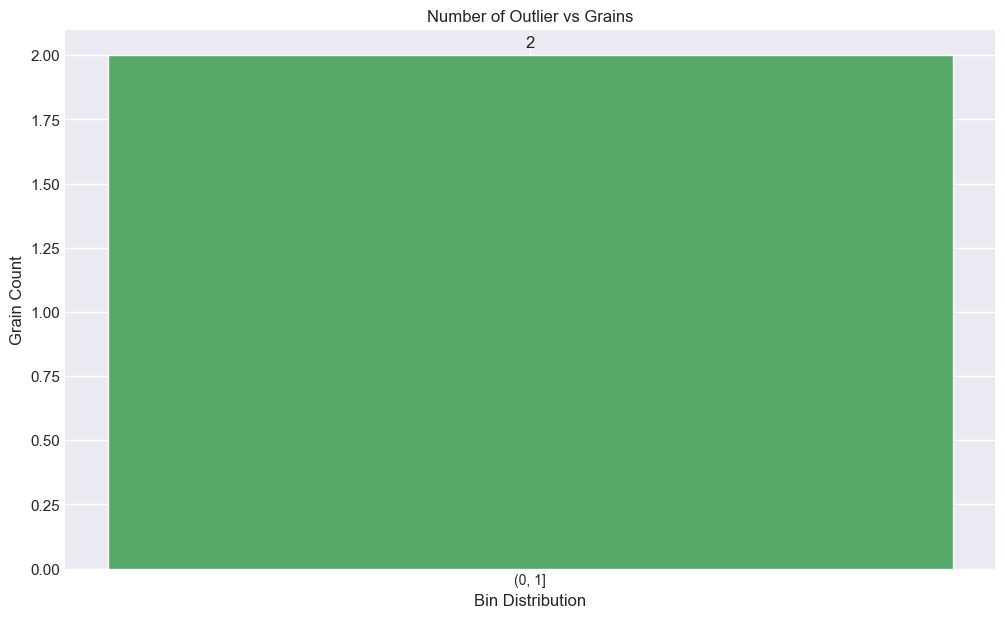

In [73]:
get_devide_in_bins(
        zscore_data,
        self_divide=True,
        what_bins='no_of_outlier',
        bin_points=[min(zscore_data.no_of_outlier),int(max(zscore_data.no_of_outlier)*(1/4)),
                    int(max(zscore_data.no_of_outlier)*(2/4)), int(max(zscore_data.no_of_outlier)*(3/4)), max(zscore_data.no_of_outlier) ],
        chart='Number of Outlier', imagefile='Number of Outlier.png')

In [74]:
# select only high volumn grains 
def zoutlier_category(data, category_data = zscore_data, filter_col = '', filter_condtion = ''):
    
    selected_data = data[data[product].isin(list(category_data[category_data[filter_col] == filter_condtion][product]))].reset_index(drop=True)
    selected_grains = list(selected_data[product].drop_duplicates())
    if len(selected_grains) < 10:
        selected_grains = selected_grains[:len(selected_grains)]
    else:
        selected_grains = selected_grains[:10]
    return selected_data, selected_grains

high_outlier_data, high_outliergrains = zoutlier_category(data1,  category_data = zscore_data, filter_col = 'z_outlier', filter_condtion= 'Upper Outlier')
low_outlier_data, low_outliergrains = zoutlier_category(data1,  category_data = zscore_data ,filter_col = 'z_outlier', filter_condtion= 'Lower Outlier')# low_volumn_data, low_vgrains = vol_category(data, ABC_catetory = 'C')
high_outlier_data.head(2)

Product    Date  Quantity     product   new_date
0  Book-Delhi  201910     30480  Book-Delhi 2019-10-01
1  Book-Delhi  201911     32730  Book-Delhi 2019-11-01

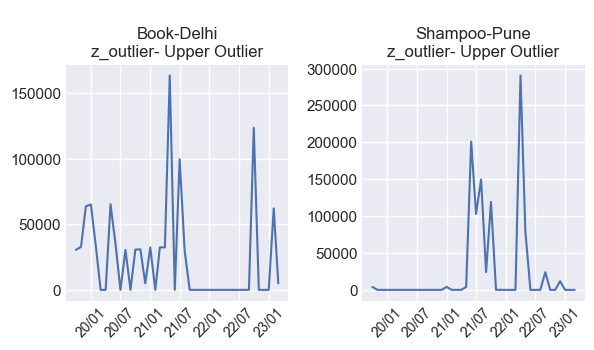

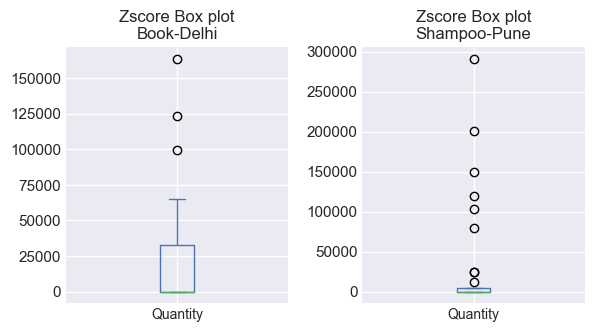

In [75]:
zscore_data_false, zscore_grains, zscore_key_grain = get_category(data1,  
                                                                category_data = zscore_data, 
                                                                filter_col = 'flag_oulier', filter_condtion= True, 
                                                                measure_filter_col = 'z_outlier')

if high_outlier_data.empty and low_outlier_data.empty:
    doc.add_paragraph("No upper and lower outlier found")
else:
    plot_manysubplot(data1 = zscore_data_false, title='', title_df = zscore_key_grain , title_filter_col = 'z_outlier',imagefile='z_outlier.png')
    plot_outlier_subplot(data1 = zscore_data_false, title='Zscore Box plot',imagefile='Zscore Box plot.png')


### Overall box plot

In [76]:
def box_plot(data, grain = None, plot_type = 'uni', feature = '', imagefile='image.png'): # features can be month, year, day, promotion etc.
    if grain is not None:
        one_product = data.loc[data[product] ==  grain]
    else:
        one_product = data.copy(deep = True)
        grain = 'Overall'
    if plot_type == 'uni' :
        f, ax = plt.subplots(figsize=(8, 6))
        sns.boxplot(y = sales, data = data)
    elif plot_type == 'bi'and feature != '':
        #sale_feature_bar = pd.concat([one_product[sales],one_product[feature]],axis = 1)
        f, ax = plt.subplots(figsize=(10, 8))
        fig = sns.boxplot(x = feature, y =sales, data = one_product)
#         fig.axis(ymin = 0, ymax = 800000); # to chnage the yrange
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel("Product {}".format(grain))
    plt.ylabel('Qty')
    ax = plt.title('Product - '+ str(grain) +', '+str(feature)+ ' plot ' +'\n',y = .88,fontsize = 14 )
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))

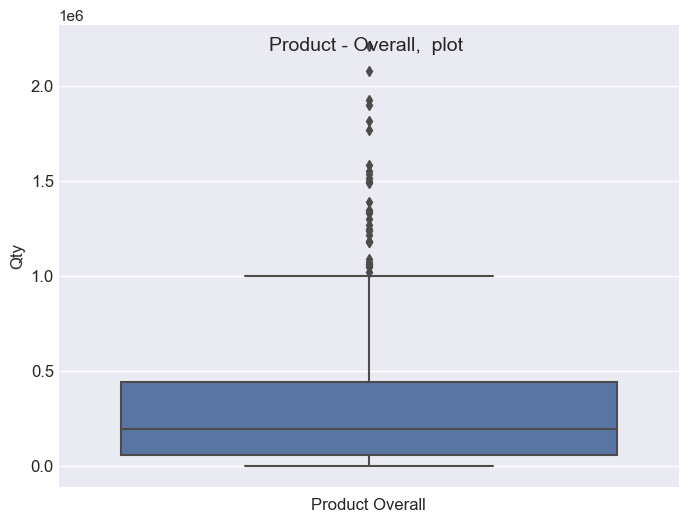

In [77]:
box_plot(data1,grain = None, plot_type='uni',imagefile='Overall BoxPlot.png') # bi and uni

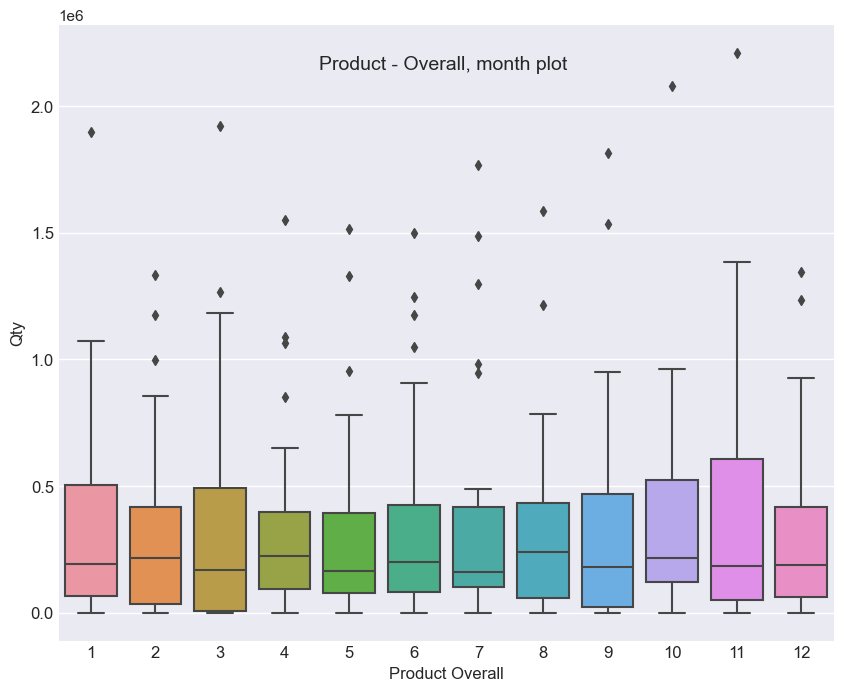

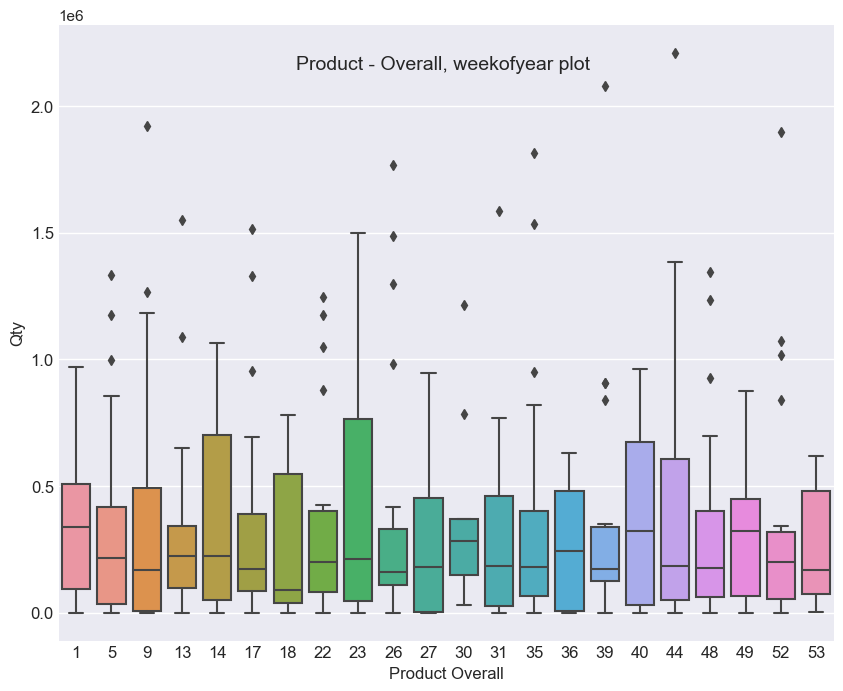

In [78]:
box_plot(data_with_date_feature, grain =  None, plot_type='bi',feature='month', imagefile='Monthwise_box.png') # bi and uni

box_plot(data_with_date_feature, grain =  None, plot_type='bi',feature='weekofyear', imagefile='Monthwise_box.png') # bi and uni


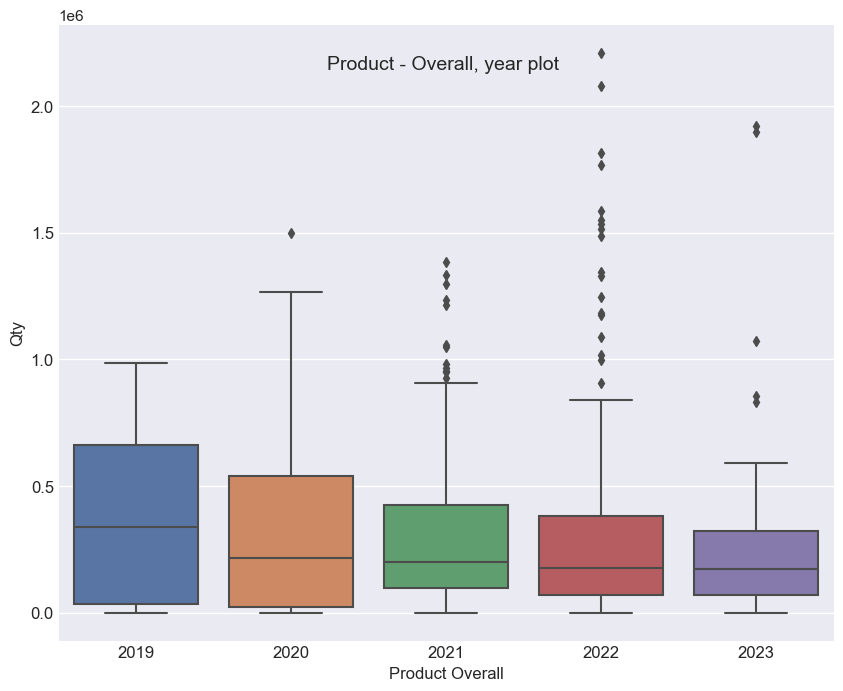

In [79]:
box_plot(data_with_date_feature, grain =  None, plot_type='bi',feature='year', imagefile='yearlywise_boxplot.png') # bi and unins.

### Date points segmetations

In [80]:
def segmentation_data_points(data,imagefile='image.png'):
    doc.add_heading(f"{count_number}.XYZ Segmentation",1)
    #count_data_thresh = data.groupby(['Grain1']).YYYYMM.agg({'total_count':'count'}).reset_index()
    count_data = data.groupby([product])[date].agg(total_date_count='count').reset_index()
    data_with_count = data.merge(count_data, on = [product], how = 'inner')
    data_with_count.loc[data_with_count['total_date_count'] <= date_count,'data_points_flag'] = 'Z'
    data_with_count.loc[(data_with_count['total_date_count'] > date_count) & (data_with_count['total_date_count'] <= date_high_count),'data_points_flag'] = 'Y'
    data_with_count.loc[data_with_count['total_date_count'] > date_high_count,'data_points_flag'] = 'X'
    d = len(data_with_count.drop_duplicates([product]))
    doc.add_paragraph(f"Total Products {len(data_with_count.drop_duplicates([product]))}")
    doc.add_paragraph(f'***** Number of the Products (20, 40, >40)*****') 
    data_with_count = data_with_count.groupby([product]).first().reset_index() 
    doc.add_paragraph(f'{data_with_count["data_points_flag"].value_counts()}')
    #doc.add_paragraph(len(data_with_count.drop_duplicates(['Grain1'])) + len(data_with_count.drop_duplicates(['Grain1'])) + len(H_freq.drop_duplicates(['Grain1'])))
    plt.xlabel("Time points")
    plt.ylabel("Products")
    plt.hist(x = count_data["total_date_count"],bins = 25,color=color)
    plt.title('Date points destribution vs Grains');
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))
  
    return data_with_count[[product, 'total_date_count','data_points_flag']]


product  total_date_count data_points_flag
0  Book-Delhi                42                X
1  Detol-Pune                42                X

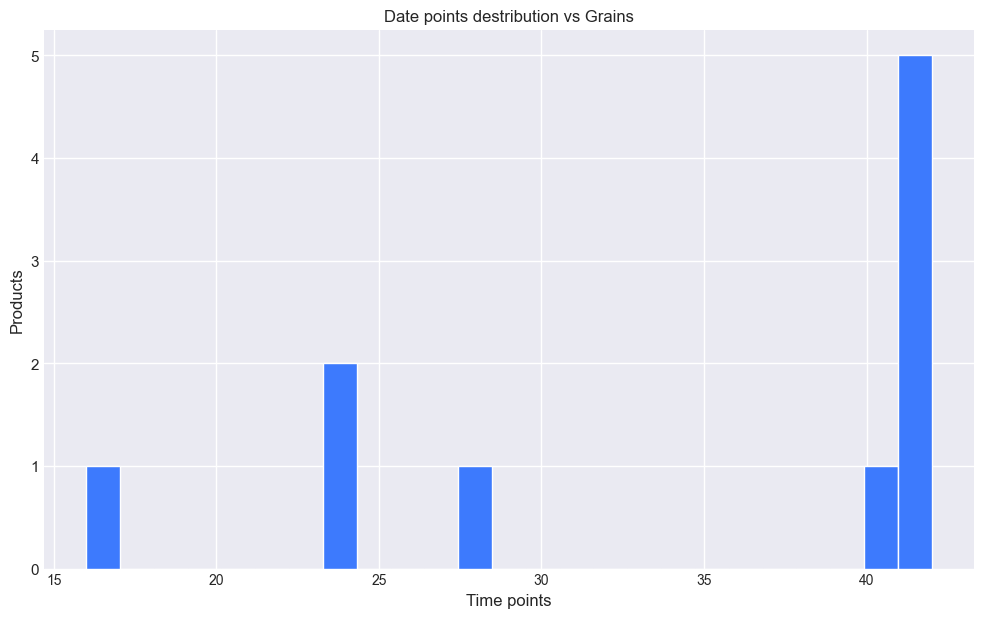

In [81]:
data_with_count = segmentation_data_points(data, imagefile='XYZ.png')
data_with_count.head(2)
count_number +=1

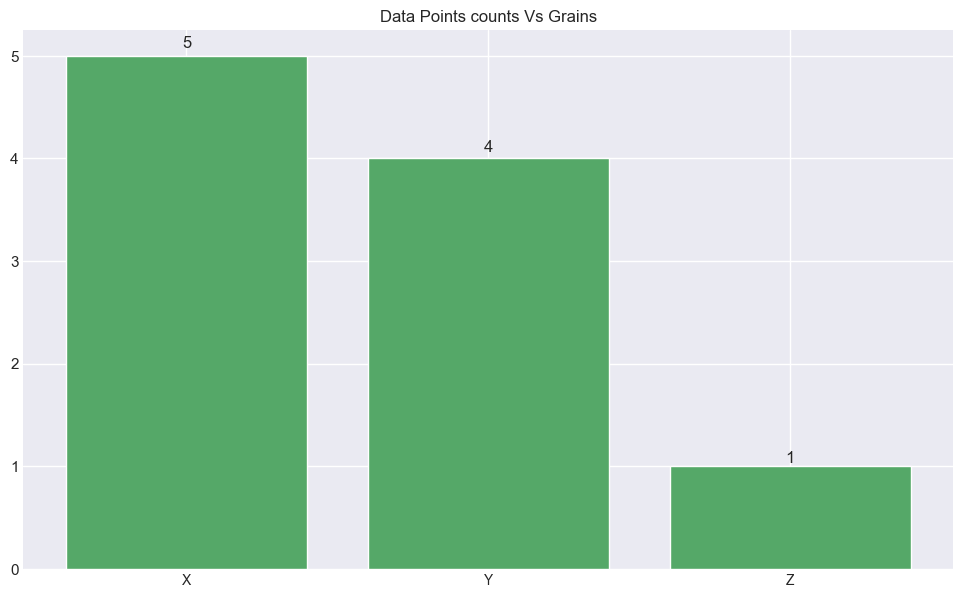

In [82]:
plot_bar(data_with_count,'data_points_flag',product, title='Data Points counts Vs Grains',imagefile='Data Points counts Vs Grains.png')


## XYZ

In [83]:
def get_abc_xyz(data_with_count, ABC_result):
    doc.add_heading(f"{count_number}.ABC-XYZ Segmentation\n\n")
    abc_xyz = data_with_count.merge(ABC_result, on = [product], how = 'inner')
    abc_xyz['abc-xyz'] =  abc_xyz['data_points_flag'] + "-" +  abc_xyz['Vol']
    abc_xyz_count = abc_xyz.groupby([product]).first().reset_index() 
    doc.add_paragraph(f'{abc_xyz_count["abc-xyz"].value_counts(ascending = False)}')
    #doc.add_paragraph(len(data_with_count.drop_duplicates(['Grain1'])) + len(data_with_count.drop_duplicates(['Grain1'])) + len(H_freq.drop_duplicates(['Grain1'])))
    return abc_xyz, abc_xyz_count

data_abcxyz, abc_xyz_count = get_abc_xyz(data_with_count, ABC_result)
data_abcxyz.head(2)
count_number += 1


product  total_date_count data_points_flag  Contribution  Cumulative  \
0  Book-Delhi                42                X      0.008255  100.000000   
1  Detol-Pune                42                X      0.374197   37.419720   

  Vol abc-xyz  
0   C     X-C  
1   A     X-A

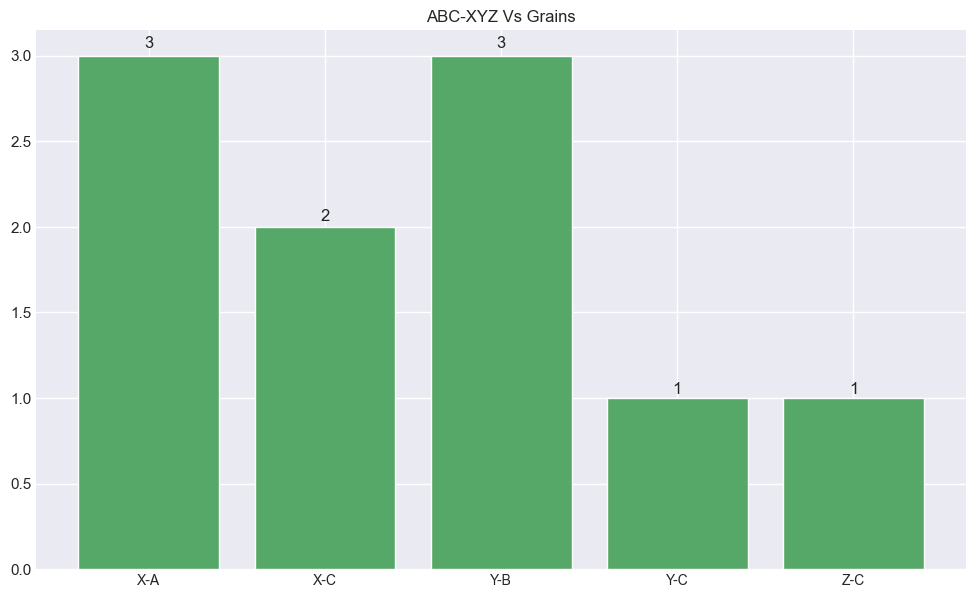

In [84]:
plot_bar(abc_xyz_count,'abc-xyz',product, title='ABC-XYZ Vs Grains', imagefile='ABC-XYZ Vs Grains.png')

### Check COV (flatness)

In [85]:
def segmentataion_COV(data,imagefile='image.png'):
    doc.add_heading(f"{count_number}.COV\n",1)
    sales_mean_std = data.groupby([product])[sales].agg(sales_std_cov ='std',sales_mean = 'mean').reset_index()
    sales_mean_std['COV'] = sales_mean_std["sales_std_cov"] / sales_mean_std["sales_mean"] 
    #sales_mean_std['COV_points'] = 0
    sales_mean_std.loc[sales_mean_std['COV'] <= .5,'COV_points'] = 'L_COV'
    sales_mean_std.loc[(sales_mean_std['COV'] > .5) & (sales_mean_std['COV'] <= 2),'COV_points'] = 'M_COV'
    sales_mean_std.loc[sales_mean_std['COV'] > 2,'COV_points'] = 'H_COV'
    sales_mean_std['binned_cov'] = pd.cut(sales_mean_std['COV'],[0,0.5,2.5,np.inf])
    count_grain_bin_sales = sales_mean_std.groupby(['binned_cov'])[product].count().reset_index()
    count_grain_bin_sales["binned_cov"] = count_grain_bin_sales["binned_cov"].astype(str)
    fig, ax = plt.subplots()
    if any(sales_mean_std['COV'].isna()):
        na_grain_list = list(sales_mean_std[sales_mean_std['COV'].isna()][product])
        doc.add_paragraph(f"Following grains having NA in COV {len(na_grain_list)} and {na_grain_list}")
        sales_mean_std = sales_mean_std[~sales_mean_std[product].isin(na_grain_list)]
    d_max = round(max(sales_mean_std['COV']),2)
    d_min = round(min(sales_mean_std['COV']),2)
    doc.add_paragraph(f'Max COV of sales is {d_max}')
    doc.add_paragraph(f'Min COV of sales is {d_min}')
    plt.rcParams['figure.figsize'] = [12,8]
    bar_plot = plt.bar(count_grain_bin_sales['binned_cov'],count_grain_bin_sales[product],label = 'Low',width = .3, color=color)
    plt.xlabel('COV Bins')
    plt.ylabel('Grain Count')
    plt.title('Grain couns with Sales volatility')
    plt.rc('xtick', labelsize=8);
    
    bar_label = round(count_grain_bin_sales[product],2)
    def autolabel(rects):
        for idx,rect in enumerate(bar_plot):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    bar_label[idx],
                    ha='center', va='bottom', rotation=0)
    autolabel(bar_plot)
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))

    return sales_mean_std

product  sales_std_cov     sales_mean      COV COV_points  binned_cov
0  Book-Delhi   36781.977879   23833.571429 1.543284      M_COV  (0.5, 2.5]
1  Detol-Pune  443470.434579 1080327.785714 0.410496      L_COV  (0.0, 0.5]

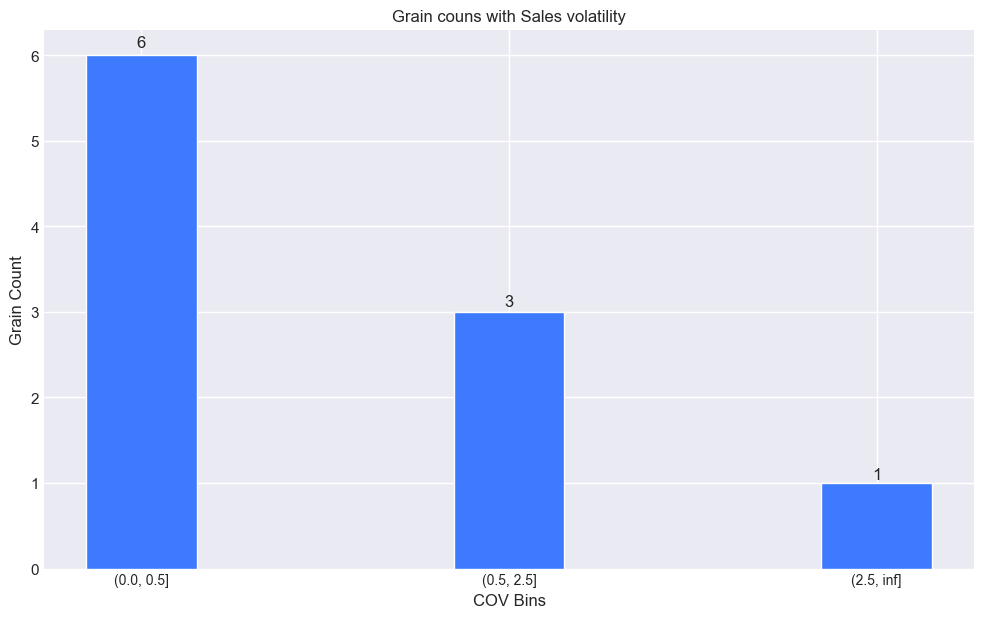

In [86]:
sales_cov_segment = segmentataion_COV(data,imagefile='COV.png')
sales_cov_segment.head(2)
count_number += 1


In [87]:
# select only high volumn grains 
def cov_category(data, category_data = zscore_data, filter_col = '', filter_condtion = '',measure_filter_col = None):
    
    selected_data = data[data[product].isin(list(category_data[category_data[filter_col] == filter_condtion][product]))].reset_index(drop=True)
    selected_grains = list(selected_data[product].drop_duplicates())
    if measure_filter_col is not None:
        key_grain = category_data[category_data[filter_col] == filter_condtion][[product, measure_filter_col]]
    if len(selected_grains) < 10:
        selected_grains = selected_grains[:len(selected_grains)]
    else:
        selected_grains = selected_grains[:10]
        selected_data = data[data[product].isin(selected_grains)].reset_index(drop=True)

    return selected_data, selected_grains, key_grain
mid_COV_data, mid_COVgrains, mid_COV_key_grain  = cov_category(data1,  category_data = sales_cov_segment, filter_col = 'COV_points', filter_condtion= 'M_COV', measure_filter_col = 'COV')
low_COV_data, low_COV_grains, low_COV_key_grain = cov_category(data1,  category_data = sales_cov_segment ,filter_col = 'COV_points', filter_condtion= 'L_COV', measure_filter_col = 'COV' )
high_COV_data, high_COV_grains, high_COV_key_grain = cov_category(data1,  category_data = sales_cov_segment ,filter_col = 'COV_points', filter_condtion= 'H_COV', measure_filter_col = 'COV' )



In [88]:
high_COV_data.empty

False

In [89]:
# ### libraries
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# def plot_manysubplot(data1, title = '', density_plot_flag = False, title_df = None, title_filter_col = None):
#     '''
#     Data1 : Original DataFrame
#     title_df : Take grain from the df
#     title_filter_col : doc.add_paragraph value on the chart
    
#     '''
#     # Initialize the figure style
#     plt.style.use('seaborn-darkgrid')
#     fig = plt.figure(figsize=(15,15))
#     from matplotlib.dates import DateFormatter
#     import matplotlib.dates as mdates
#     months = mdates.MonthLocator()  # every month
#     # create a color palette
#     palette = plt.get_cmap('Set1')
#     all_uniq_product = list(title_df[product].unique())
#     count = len(all_uniq_product)
#     data1['new_date'] = data1[date].map(str).str[0:4] + '-' + data1[date].map(str).str[4:6]
#     data1['new_date'] = pd.to_datetime(data1['new_date'],format='%Y-%m-%d')
#     data1.new_date = pd.to_datetime(pd.to_datetime(data1["new_date"]).dt.strftime('%Y-%m'))
#     # multiple line plot
#     data1.new_date = pd.to_datetime(pd.to_datetime(data1["new_date"]).dt.strftime('%Y-%m'))

#     for idx, one_product in enumerate(all_uniq_product,start = 1):
# #         title_value = title_df[title_df[product] == one_product][title_filter_col][0]
#         orig_value = title_df[title_df[product] == one_product][title_filter_col].values[0]
#         if type(orig_value) == int or type(orig_value) == float:
#             title_value = str(round(orig_value,2))
#         else:
#             title_value = str(orig_value)

#         ax = plt.subplot(5,5, idx)
#         data2 = data1[data1['product'].isin([one_product])];
#         plt.plot(data2['new_date'], data2[sales]);
#         plt.title(one_product,loc='center', fontsize=10) # x=.6, y=0.85
#         date_form = DateFormatter("%y/%m");
#         ax.xaxis.set_major_formatter(date_form)
#         plt.xticks(rotation = 45);
#         plt.title(title + "\n" + one_product + "\n" + title_filter_col + "- "  + title_value)
#         fig.tight_layout() # used to maintain space between subplots
#     plt.show();

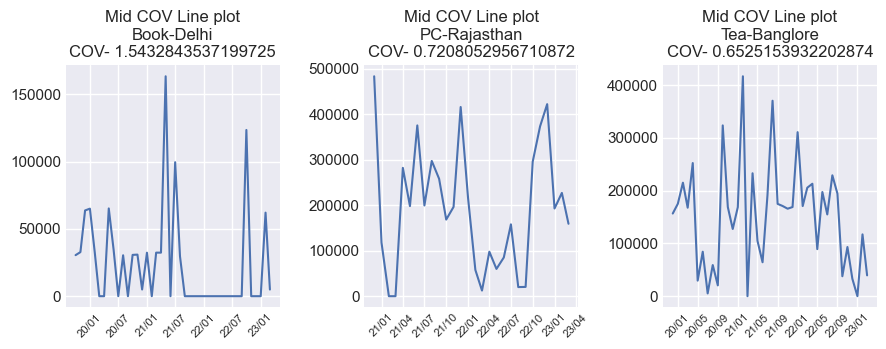

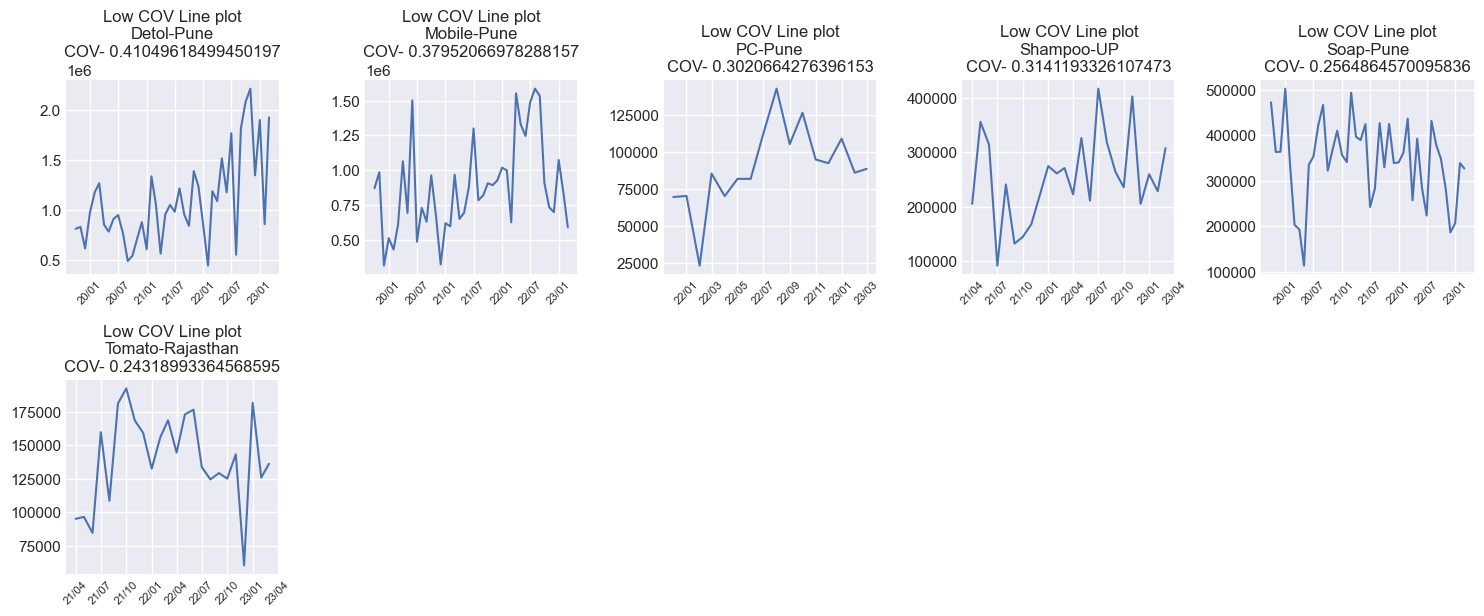

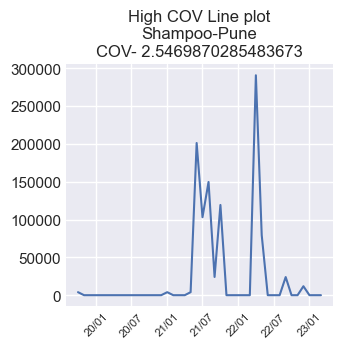

In [90]:
if mid_COV_data.empty:
    doc.add_paragraph("Mid COV Plots")
    doc.add_paragraph(return_empty_df(mid_COV_data))
else:
    doc.add_paragraph("Mid COV Plots")
    plot_manysubplot(data1 = mid_COV_data, title='Mid COV Line plot', title_df = mid_COV_key_grain, title_filter_col = 'COV',imagefile='Mid COV Plot.png')
doc.add_paragraph("\n\n")

doc.add_paragraph("Low COV Plots")
if low_COV_data.empty:
    doc.add_paragraph(return_empty_df(low_COV_data))
else:
    plot_manysubplot(data1 = low_COV_data, title='Low COV Line plot', title_df = low_COV_key_grain, title_filter_col = 'COV',imagefile='Low COV Plots.png')

     
doc.add_paragraph("High COV Plots")
if high_COV_data.empty:
    doc.add_paragraph(f'{return_empty_df(high_COV_data)}')
else:
    plot_manysubplot(data1 = high_COV_data, title='High COV Line plot', title_df = high_COV_key_grain, title_filter_col = 'COV',imagefile='High COV Plots.png')

     
        

### Correlation between sales, features

In [91]:
def create_feature_column(data):
    doc.add_heading(f"{count_number}.Features Correlation\n\n",1)
    numeric_features = data.select_dtypes(include = [np.number])
    categorical_features = data.select_dtypes(include = [object])
    if all(categorical_features.isin(['product'])):
        categorical_features = categorical_features.drop(['product'],axis = 1)
    if (categorical_features.shape[1] > 1) and (numeric_features.shape[1] > 1):
        doc.add_paragraph("Numerical features are {} and shape of the data {}".format(list(numeric_features.columns),numeric_features.shape))    
        doc.add_paragraph("\nCategorical features are {} and shape of the data {}".format(list(categorical_features.columns),categorical_features.shape))
        return numeric_features, categorical_features
    elif (numeric_features.shape[1] == 1) and (categorical_features.shape[1] > 1):
        doc.add_paragraph("\nCategorical features are {} and shape of the data {}".format(list(categorical_features.columns),categorical_features.shape))
        doc.add_paragraph('\n---- No Numeric feature ----')
        return None, categorical_features
    elif (numeric_features.shape[1] > 1) and (categorical_features.shape[1] <=1 ):
        doc.add_paragraph("Numerical features are {} and shape of the data {}".format(list(numeric_features.columns),numeric_features.shape))    
        doc.add_paragraph('\n----- No Categorical features ----')
        return numeric_features, None
    else:
        return None, None
    

In [92]:
numeric_features, categorical_features = create_feature_column(data_with_date_feature)
count_number += 1


In [93]:
def plot_heatmape(cm, cols_names, cols):
    fig,ax0 = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
    cm = np.corrcoef(data_with_date_feature[cols_names].values.T).round(2)
    sns.heatmap(cm, vmax = .8,linewidths= 
                    0.01,square=True,annot=True,cmap='viridis',
                linecolor='white', xticklabels=cols_names, annot_kws = 
                {'size' : 14}, yticklabels = cols_names, ax = ax0).set_title(cols)

In [94]:
def correlation_heatmap(data, numeric_features=None, categorical_features = None,imagefile='image.png'):
#     if n_large_corr_col is not None:
#         correlation = numeric_features.corr()
#         cols = correlation.nlargest(n_large_corr_col,sales)
#         cols_names = cols[sales].index
#         cm = np.corrcoef(data[cols_names].values.T)
#         plot_heatmape(cm,cols, cols_names)
    if numeric_features is not None:
        correlation = numeric_features.corr()
        cols_names = correlation[sales].index
        cm = np.corrcoef(data[cols_names].values.T)
        correlation[sales].sort_values(ascending = False)
        plot_heatmape(cm,cols_names, cols="Correlation with Categorical features")
    if categorical_features is not None:
        correlation = categorical_features.corr()
        cols_names = correlation[sales].index
        cm = np.corrcoef(data1[cols_names].values.T)
        correlation[sales].sort_values(ascending = False)
        plot_heatmape(cm,cols_names,cols = "Correlation with Categorical features")
    pic = plt.savefig(path + imagefile, bbox_inches='tight')
    doc.add_picture(path + imagefile, width = Inches(6))

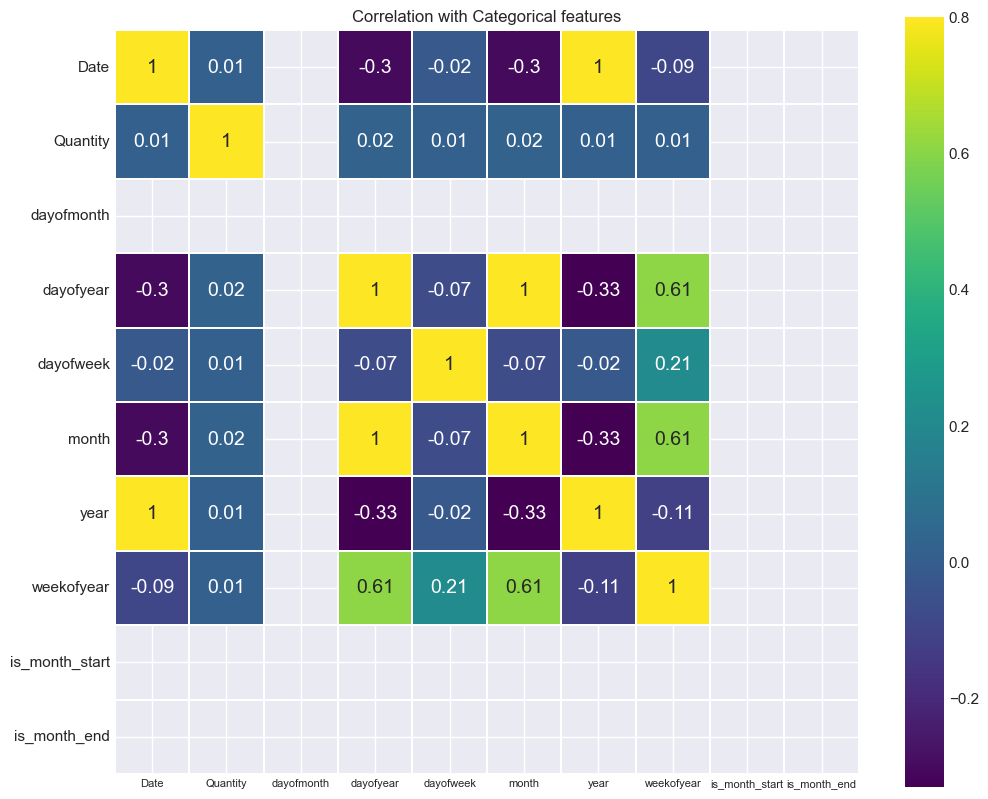

In [95]:
correlation_heatmap(data_with_date_feature, numeric_features,imagefile='correlation_heatmap.png')
# categorical_features.head()

### Negative Data Check

In [96]:
sales_data.head()

Product    Date  Quantity     product
300  Book-Delhi  201910     30480  Book-Delhi
301  Book-Delhi  201911     32730  Book-Delhi
302  Book-Delhi  201912     63680  Book-Delhi
303  Book-Delhi  202001     65010  Book-Delhi
304  Book-Delhi  202002     32610  Book-Delhi

In [97]:
def get_negative_data(data1):
    doc.add_heading(f"{count_number}.Negative Sales Check",1)
    if any(data1[sales]) < 0:
        doc.add_paragraph('Negative values are present in sales')
        data1['Negative Sales'] = 'No'
        data1.loc[data1[sales] < 0, 'Negative Sales'] = 'Yes'
        return data1[[product,'Negative Sales']].drop_duplicates()
    else:
        doc.add_paragraph('No Negative values in sales')
        data1['Negative Sales'] = 'No'
        data1.loc[data1[sales] < 0, 'Negative Sales'] = 'Yes'
        return data1[[product,'Negative Sales']].drop_duplicates()
negative_sales = get_negative_data(sales_data)
count_number += 1


In [98]:
# check = data.select_dtypes(include=['int64','float64'])
# if check.shape[0] != []:
#     doc.add_paragraph('Numeric')
# else:
#     doc.add_paragraph('No')

# data.head(2)._get_numeric_data()

In [99]:
def plot(data, features = None, time_as_features = False, bar=False):
    if time_as_features :
        for i in range(len(features.columns)):
            doc.add_paragraph(features.columns[i])
            if features.columns[i] != sales:
                cat_fea_col = features.columns[i]
                sale_qual = data.pivot_table(index = cat_fea_col,values=sales, aggfunc=np.mean)
                #sale_qual
                sale_qual = sale_qual.reset_index()
                if bar == True:
                    plt.bar(sale_qual[cat_fea_col],sale_qual[sales])
                else:
                    plt.scatter(sale_qual[cat_fea_col],sale_qual[sales],edgecolors='white')
                plt.ylabel(sales)
                plt.xlabel(cat_fea_col)
                plt.title('Sales with {}'.format(cat_fea_col))
                plt.legend([sales,cat_fea_col])
                plt.show();
    else:
        doc.add_paragraph('No other feature are available')

In [100]:
num_feature = data1.select_dtypes(include=['int64','float64','int','float'])
cat_feature = data1.select_dtypes(include=['object'])

In [101]:
# def some_plots(data):
# #     numeric_features, categorical_features = create_feature_column(data)
# #     plot(data,categorical_features, time_as_features=True, bar=True)
#     plot(data1,features = num_feature, time_as_features=True, bar=False)
# some_plots(data1)

### Checking Heteroscedasticity (ref -https://www.statology.org/white-test-in-python/)

In [102]:
list_of_hter = []
def get_heteroscedasticity(data, product1 = None):
    if product1 is not None:
        data = data[data[product] == product1]
    else:
        data = data.copy()
    from sklearn.linear_model import LinearRegression
    from scipy import stats
    y = data[sales]
    x = data[['dayofmonth','dayofyear','dayofweek','year']]
    lm = LinearRegression()
    lm.fit(x, y)
    err = (y - lm.predict(x))**2
    lm.fit(x, err)
    pred_err = lm.predict(x)
    ss_tot = sum((err - np. mean(err))**2)
    ss_res = sum((err - pred_err)**2)
    try:
        if ss_tot == 0:
            ss_tot = 1
        r2 = 1 - (ss_res / ss_tot)
    except ZeroDivisionError:
        doc.add_paragraph('Zero divisino Error')
    n_samples = y.shape[0]
    LM = n_samples * r2
    chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
    pval = chisqprob(LM, x.shape[1])
    condition = (pval <= 0.05)
    list_of_hter.append(pval)
    if pval <= 0.05:
        test_result = 'Heteroskedasticity'
    else:
        test_result = 'No heteroskedasticity'
    data['Heteroskedasticity'] = condition
    data['p_value'] = pval
    data.drop([product],axis = 1,inplace=True)
#     data = data.reset_index() 
    data = data[['Heteroskedasticity','p_value']].drop_duplicates().reset_index(drop=True)
    return data[['Heteroskedasticity','p_value']]

In [103]:
def apply_heteroscedasticity ():
    doc.add_heading(f"{count_number}.Heteroscedasticity",1)
    doc.add_paragraph("17.-->  Heteroscedasticity \n\n Heteroscedasticity refers to the unequal scatter of residuals at different"\
          "levels of a response variable, which violates the assumption that the residuals are equally scattered "\
          "at each level of the response variable.\n"\
          "     Heteroscedasticity is mainly due to the presence of outlier in the data. "\
          "Outlier in Heteroscedasticity means that the observations that are either small or large with "\
          "respect to the other observations are present in the sample. Heteroscedasticity is also caused "\
          "due to omission of variables from the model.")
    data_with_hetrodacity = data_with_date_feature.groupby([product]).apply(lambda x : get_heteroscedasticity(x))
    return data_with_hetrodacity.reset_index(drop=True,level= 1)

data_with_hetrodacity = apply_heteroscedasticity().reset_index()
count_number += 1

data_with_hetrodacity.head(2)

product  Heteroskedasticity  p_value
0  Book-Delhi               False 0.459446
1  Detol-Pune               False 0.077182

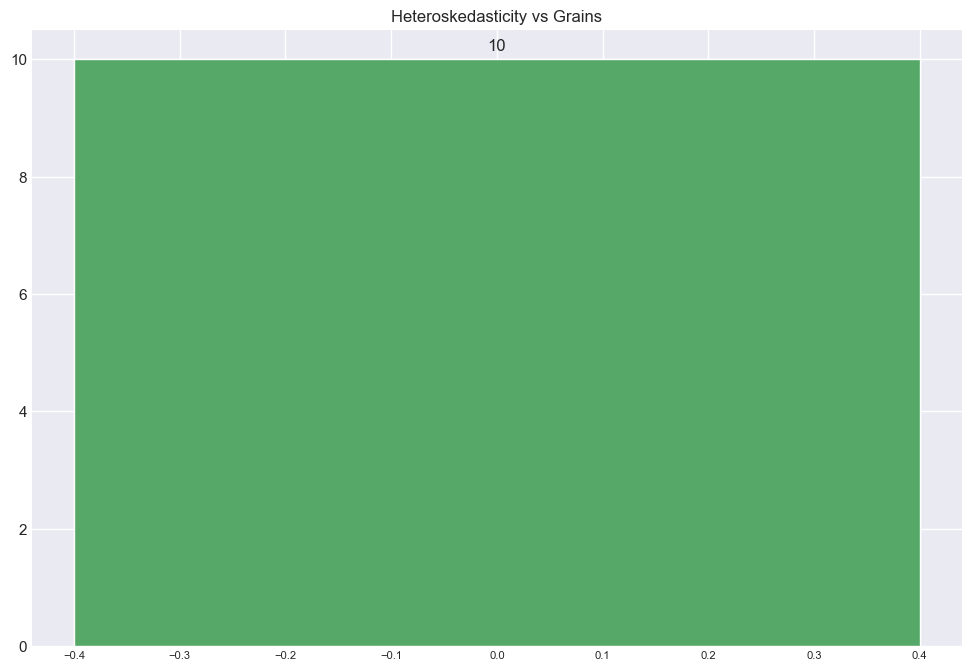

In [104]:
plot_bar(data_with_hetrodacity, 'Heteroskedasticity',product, title = 'Heteroskedasticity vs Grains',imagefile='Heteroskedasticity vs Grains.png')

# plot_bar(abc_xyz_count,'abc-xyz',product, title='ABC-XYZ Vs Grains', imagefile='ABC-XYZ Vs Grains.png')




In [105]:
# select only high volumn grains 
def get_category(data, category_data = zscore_data, filter_col = '', filter_condtion = '',measure_filter_col = None):
    category_data.rename(columns={'unique_id' : product},inplace=True)
    selected_data = data[data[product].isin(list(category_data[category_data[filter_col] == filter_condtion][product]))].reset_index(drop=True)
    selected_grains = list(selected_data[product].drop_duplicates())
    if measure_filter_col is not None:
        if len(selected_grains) > 10 :
            key_grain = category_data[category_data[filter_col] == filter_condtion][[product, measure_filter_col]][:how_many_subplot]
#             doc.add_paragraph(key_grain.head(2))
        else:
            key_grain = category_data[category_data[filter_col] == filter_condtion][[product, measure_filter_col]]
#             doc.add_paragraph(key_grain.head(2))
            
    elif len(selected_grains) < 10:
        selected_grains = selected_grains[:len(selected_grains)]
        key_grain = category_data[category_data[filter_col] == filter_condtion][[product, filter_col]]

    else:
        selected_grains = selected_grains[:how_many_subplot + 1]
        selected_data = data[data[product].isin(selected_grains)].reset_index(drop=True)
        key_grain = category_data[category_data[filter_col] == filter_condtion][[product, filter_col]]

    return selected_data, selected_grains, key_grain



In [106]:
false_hdcty_data, false_hdcty_grains, false_hdcty_key_grain  = get_category(data1,  
                                                                category_data = data_with_hetrodacity, 
                                                                filter_col = 'Heteroskedasticity', filter_condtion= False, 
                                                                measure_filter_col = 'p_value')

true_hdcty_data, true_hdcty_grains, true_hdcty_key_grain  = get_category(data1,  
                                                                category_data = data_with_hetrodacity, 
                                                                filter_col = 'Heteroskedasticity', filter_condtion= True, 
                                                                measure_filter_col = 'p_value')
            
            
            

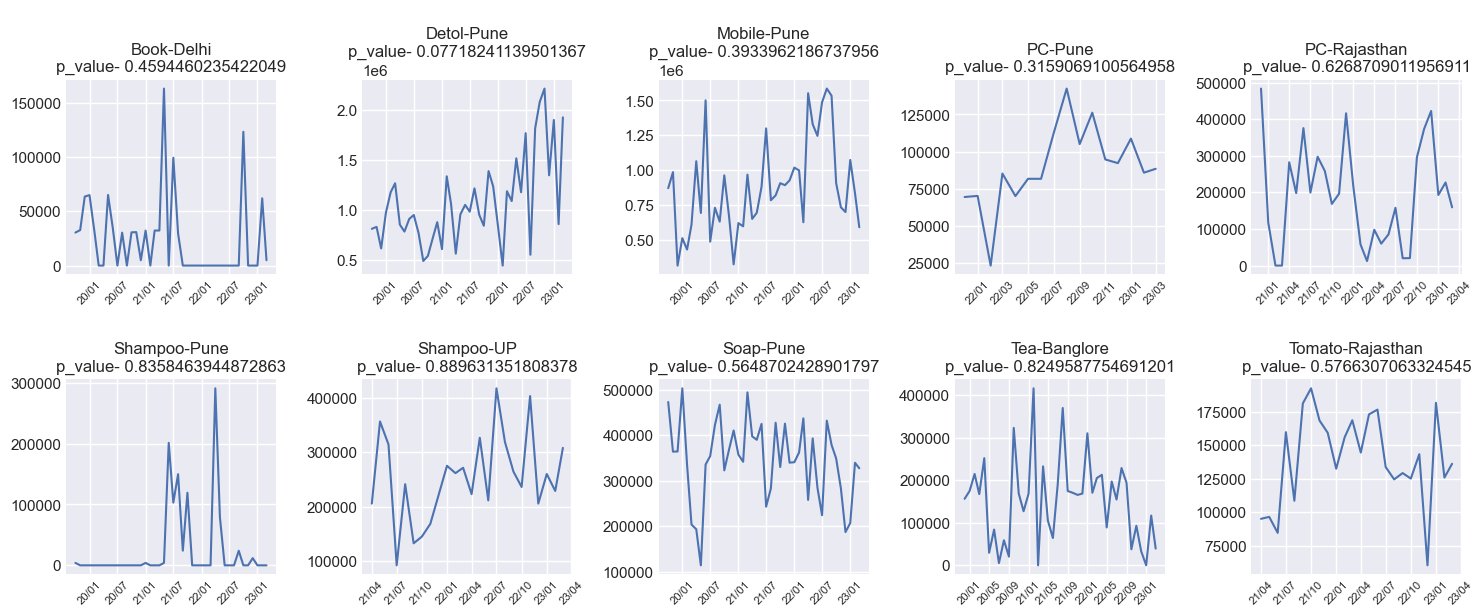

Dataframe is empty -  true_hdcty_data


In [107]:
if false_hdcty_data.empty:
    doc.add_paragraph("False Heteroskedasticity Plots")
    doc.add_paragraph(return_empty_df(false_hdcty_data))
else:
    doc.add_paragraph("False Heteroskedasticity max 10 grains")
    plot_manysubplot(data1 = false_hdcty_data, title='', title_df = false_hdcty_key_grain, title_filter_col = 'p_value',imagefile='False Heteroskedasticity.png')
doc.add_paragraph("\n\n")

if true_hdcty_data.empty:
    doc.add_paragraph("True Heteroskedasticity Plots")
    doc.add_paragraph(return_empty_df(true_hdcty_data))
else:
    doc.add_paragraph("True Heteroskedasticity max 10 grains")
    plot_manysubplot(data1 = true_hdcty_data, title='', title_df = true_hdcty_key_grain, title_filter_col = 'p_value',imagefile='True Heteroskedasticity.png')
doc.add_paragraph("\n\n")


### Remove leading zeros grains


In [108]:
def remove_upper_zeros(data):
#     global min_date
    data['is_start_date'] = 0 
    
    data.loc[data[sales].ne(0).groupby(data[product]).idxmax(),'is_start_date']=1
#     data.loc[data[sales].ne(0).idxmax(),'is_start_date']=1
#     doc.add_paragraph(data.head())
#     doc.add_paragraph("****************", "****************\n")
    return data[data[date].values >= data[data.is_start_date == 1][date].values]


In [109]:
%%time
def get_months_diff(data1):
    grp_data = data1.groupby([product])
    min_date= min(data1['new_date'])
    start_date_data = grp_data.apply(lambda x: remove_upper_zeros(x)).reset_index(drop=True)
    count_of_date_start = start_date_data[start_date_data['is_start_date'] ==1][date] == min(data[date])
    # not_start_date = np.invert(count_of_date_start)
    # doc.add_paragraph('{} product start from the min date which is {}'.format(sum(count_of_date_start),min_date.date()))
    # doc.add_paragraph('{} product start after min date which is {}'.format(sum(not_start_date),min_date.date()))
    ans_first = start_date_data.groupby(product).first().reset_index()

    abc = pd.to_datetime(min_date, format = '%Y-%m-%d')- pd.to_datetime(ans_first['new_date'], format = '%Y-%m-%d') 
    if frequency=='Monthly' :
        ans_first['original_months_diff'] = abs((abc.dt.days/30).astype(int))
        selected_data = data1[[product,date]].groupby(product).first().reset_index().rename(columns = {date:'orig_start_date'})
        ans_first = selected_data.merge(ans_first[[product,'is_start_date','original_months_diff',date]], on = product, how = 'inner')
        return ans_first[[product,'is_start_date','original_months_diff',date, 'orig_start_date']]

    elif frequency=='Weekly' :
        ans_first['original_week_diff'] = abs((abc.dt.days/7).astype(int))
        selected_data = data1[[product,date]].groupby(product).first().reset_index().rename(columns = {date:'orig_start_date'})
        ans_first = selected_data.merge(ans_first[[product,'is_start_date','original_week_diff',date]], on = product, how = 'inner')
        return ans_first[[product,'is_start_date','original_week_diff',date, 'orig_start_date']]

    elif frequency=='Daily' :
        ans_first['original_day_diff'] = abs((abc.dt.days).astype(int))
        selected_data = data1[[product,date]].groupby(product).first().reset_index().rename(columns = {date:'orig_start_date'})
        ans_first = selected_data.merge(ans_first[[product,'is_start_date','original_day_diff',date]], on = product, how = 'inner')
        return ans_first[[product,'is_start_date','original_day_diff',date, 'orig_start_date']]

    
get_date_diff = get_months_diff(data_with_date_feature)
get_date_diff.head(2)




CPU times: user 31.1 ms, sys: 4.53 ms, total: 35.6 ms
Wall time: 36.7 ms


product  is_start_date  original_months_diff    Date  orig_start_date
0  Book-Delhi              1                     0  201910           201910
1  Detol-Pune              1                     0  201910           201910

In [110]:
# get which starts from 
if any(get_date_diff[date]) != any(get_date_diff['orig_start_date']):
    
    doc.add_heading(f"{count_number}.Leading Zeros \n", 1)
    doc.add_paragraph("Number of grains starts from zero ")
    if frequency == 'Monthly' :
        zero_start_grains = get_date_diff[get_date_diff[date] != any(get_date_diff['orig_start_date'])][product]
        doc.add_paragraph(zero_start_grains)
    elif frequency == 'Weekly' :
        zero_start_grains = get_date_diff[get_date_diff[date] != any(get_date_diff['orig_start_date'])][product]
        doc.add_paragraph(zero_start_grains)
else:
    doc.add_heading(f"{count_number}.Leading Zeros \n", 1)
    doc.add_paragraph("No grain found which date start from zero sales")
count_number += 1
    
    

## TS Feature extraction

In [111]:
from tsfeatures import tsfeatures
from tsfeatures import acf_features, stl_features
def get_trend_seasonality(data, data_with_count):
    # filter grains which contains less than 3 data points (tsfeature wont work with less than 3)
    data = data[data['product'].isin(list(data_with_count[data_with_count['total_date_count'] >= 3]['product']))]
    data_req = data[['new_date',sales,product]]
    panel = data_req.rename(columns = {'new_date' :'ds' , sales : 'y', product :'unique_id' })
    panel['ds'] = pd.to_datetime(panel['ds'], format='%Y-%m-%d')
    panel['y']= panel.y.astype(float)
    panel.unique_id = panel.unique_id.astype('|S')
    doc.add_paragraph(f'Data types for tsfeatures columns')
    doc.add_paragraph(f'{panel.dtypes}')
    tren_sea_feature = tsfeatures(panel,features=[stl_features], freq = 12, dict_freqs={'M' : 12})
    acf_feature = tsfeatures(panel, features=[acf_features],freq = 12)
    tren_sea_feature = tren_sea_feature.reset_index()
    acf_feature = acf_feature.reset_index()
    tren_sea_feature['unique_id'] = acf_feature.unique_id.str.decode('utf-8')
    acf_feature['unique_id'] = acf_feature.unique_id.str.decode('utf-8')
    #get catetories in trend and seasonity feature
#     tren_sea_feature['trend_line'] = False
    def get_trend(x):
        if any(x['trend'] > 0.4):
            x['trend_line'] = True
        else :
            x['trend_line'] = False
        return x
    def get_seasonlity(x):
        if any(x['seasonal_strength'] > 0.75):
            x['seasonlity_line'] = True
        else :
            x['seasonlity_line'] = False
        return x
    tren_sea_feature = tren_sea_feature.groupby(['unique_id']).apply(lambda x : get_trend(x))
    tren_sea_feature = tren_sea_feature.groupby(['unique_id']).apply(lambda x : round(get_seasonlity(x),3))

    return tren_sea_feature,acf_feature, tren_sea_feature[['unique_id', 'trend','seasonal_strength', 'trend_line', 'seasonlity_line']]


In [112]:
doc.add_heading(f"{count_number}.Trend and Seasonlity \n", 1)
stl_features, acf_features, treand_sea_feature = get_trend_seasonality(data_with_date_feature, data_with_count)
stl_features.head(2)
count_number += 1


index   unique_id  nperiods  seasonal_period    trend    spike  linearity  \
0      0  Book-Delhi         1               12 0.291000 0.000000  -1.178000   
1      1  Detol-Pune         1               12 0.767000 0.000000   3.797000   

   curvature    e_acf1  e_acf10  seasonal_strength  peak  trough  trend_line  \
0   0.646000 -0.146000 0.466000           0.541000     8       1       False   
1   2.292000 -0.284000 0.223000           0.732000     2       5        True   

   seasonlity_line  
0            False  
1            False

In [113]:
def get_top_10_trend_seasaonlity(stl_features,treshold_seasonality, treshold_trend):
#     stl_features = stl_features.reset_index()
#     stl_features[product] = stl_features.unique_id.str.decode('utf-8')
    top_season = stl_features[stl_features['seasonal_strength'] > treshold_seasonality]
    top_trend = stl_features[stl_features['trend'] > treshold_trend]
    list_of_grain = [x for x in list(top_season['unique_id'])]
    doc.add_paragraph('Grains above {} seasonale point are {}'.format(treshold_seasonality, len(list_of_grain)))
    list_of_grain_trend = [x for x in list(top_trend['unique_id'])]
    doc.add_paragraph('Grains above {} trend point are {}'.format(treshold_trend, len(list_of_grain_trend)))
    return list_of_grain, list_of_grain_trend

In [114]:
    
high_seasanlity_grains, high_trend_grains = get_top_10_trend_seasaonlity(stl_features,seasoanlity_threshold,trend_threshold)


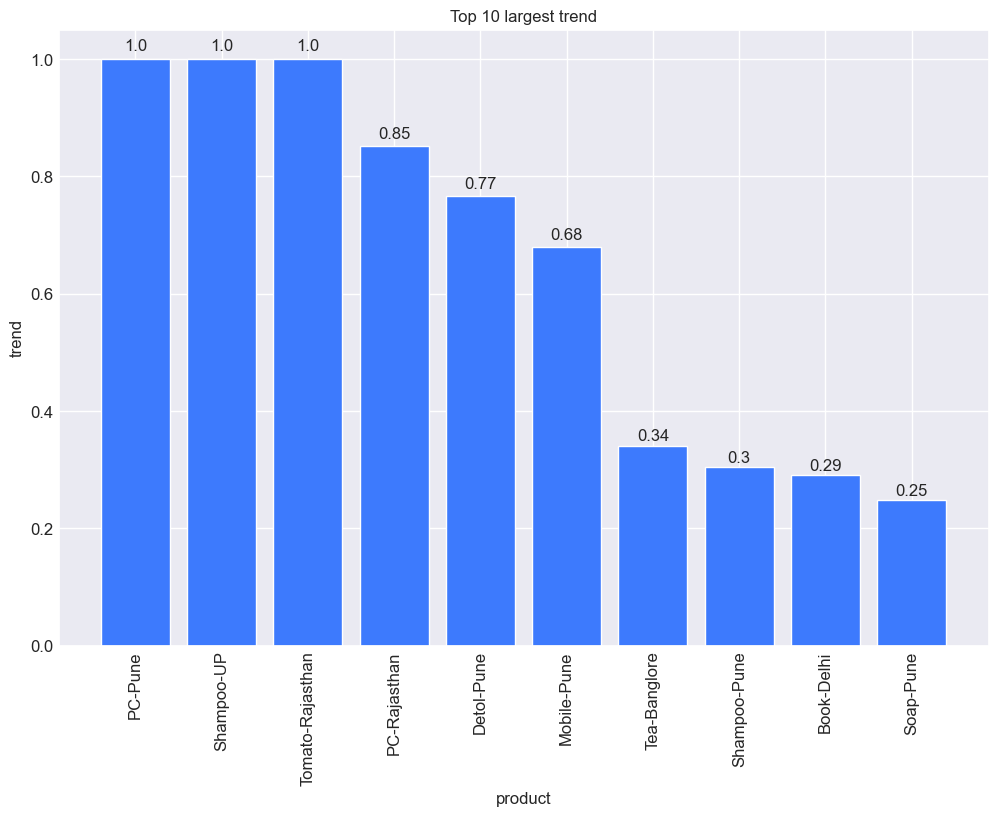

<Figure size 1200x800 with 0 Axes>

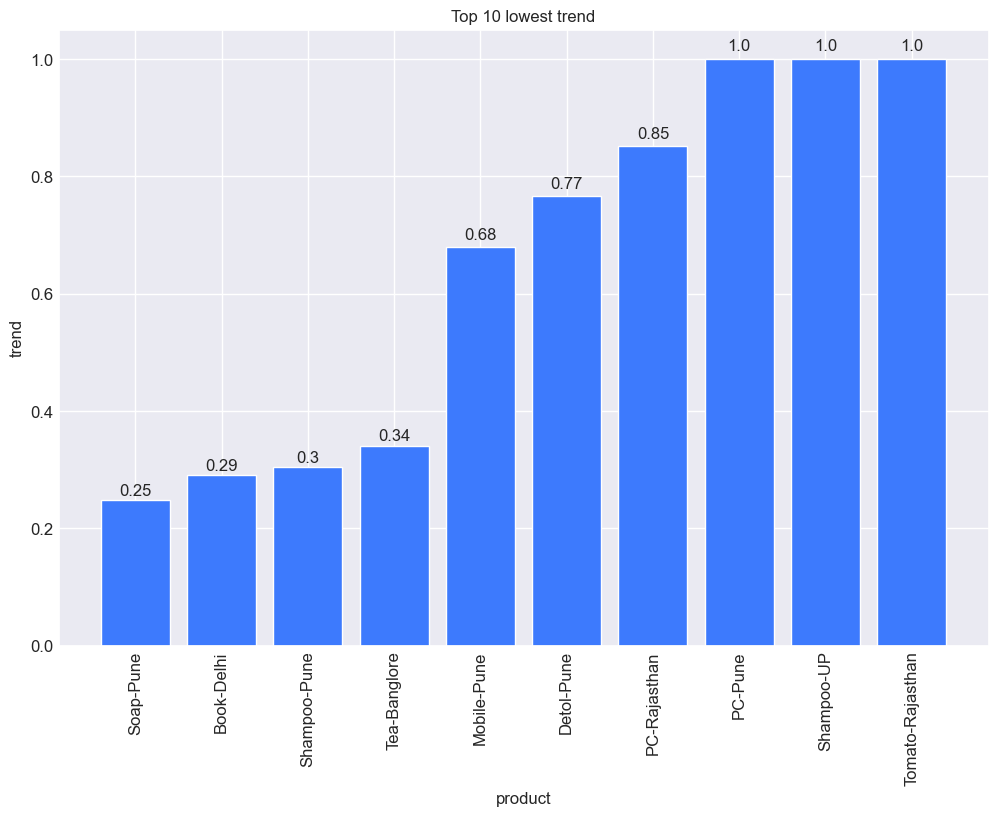

<Figure size 1200x800 with 0 Axes>

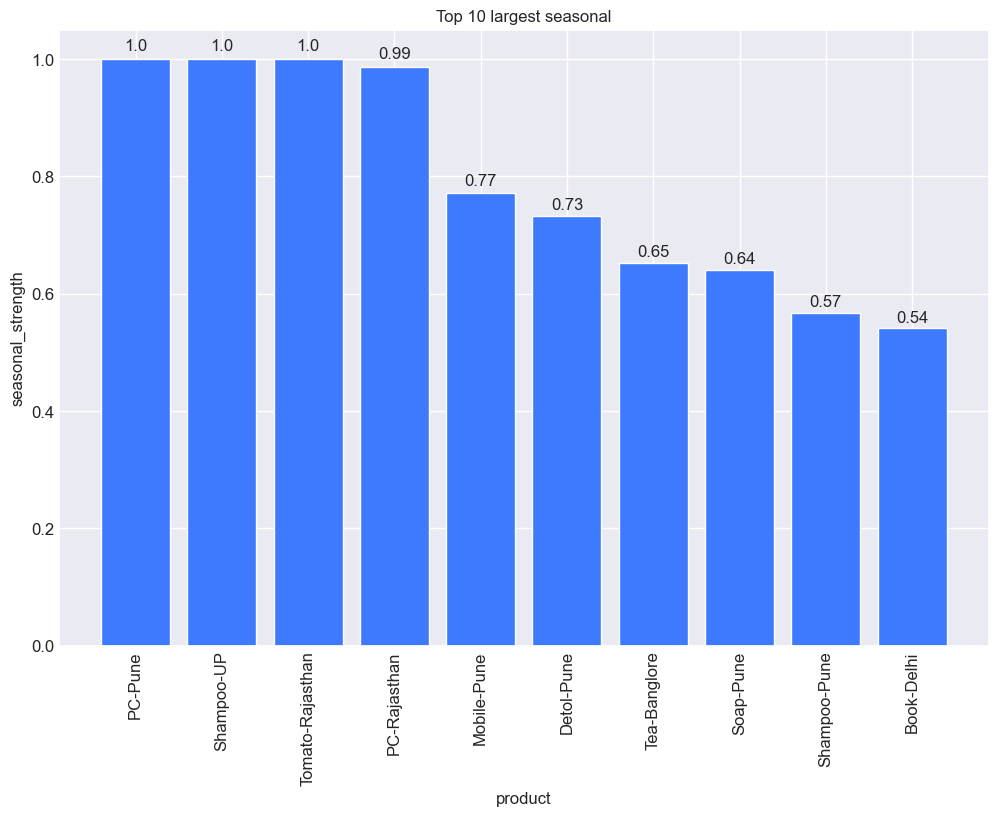

<Figure size 1200x800 with 0 Axes>

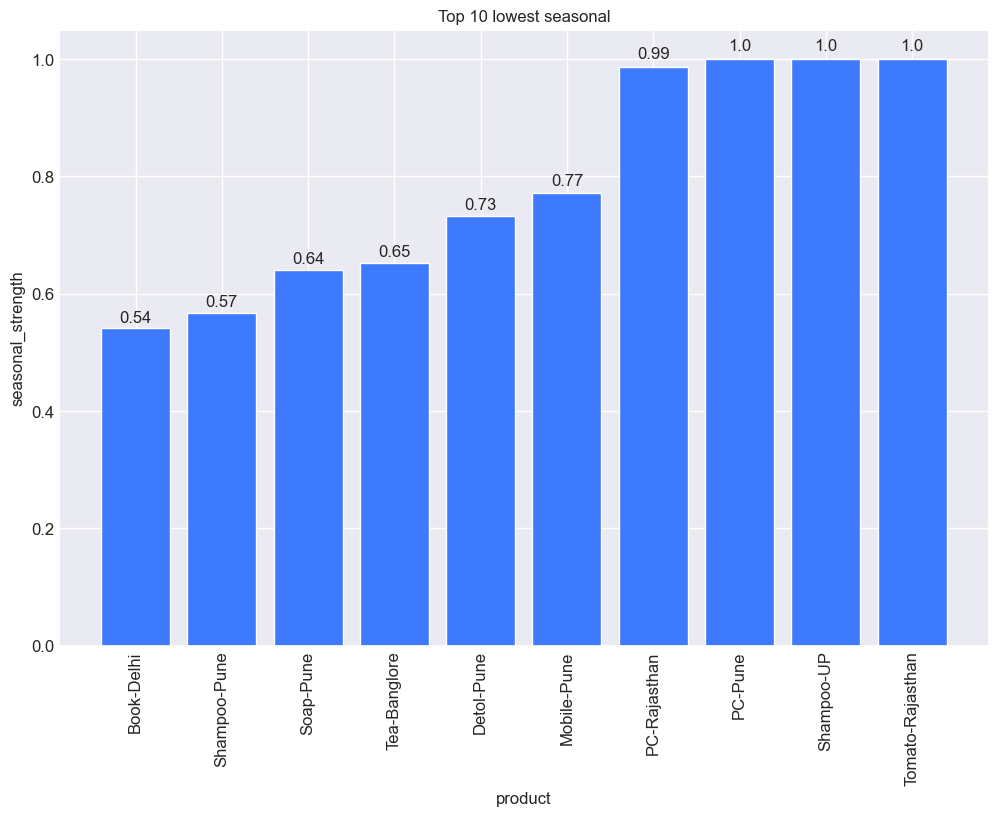

In [115]:
def get_top_10_trend_seasaonlity(stl_features):
#     stl_features = stl_features.reset_index()
#     stl_features[product] = stl_features.unique_id.str.decode('utf-8')
    stl_features[product] = stl_features['unique_id']
    low_10_data_trend = stl_features.nlargest(10, columns = 'trend').reset_index()
    get_user_defined_plot(low_10_data_trend,title = 'Top 10 largest trend',ylabel='trend',lift_text=0.03,imagefile='Top 10 largest trend.png')
    high_10_data_trend = stl_features.nsmallest(10, columns = 'trend').reset_index()
    plt.figure()
    get_user_defined_plot(high_10_data_trend,title = 'Top 10 lowest trend',ylabel='trend',lift_text=0.0001,round_digit=4,imagefile='Top 10 lowest trend.png')
    low_10_data = stl_features.nlargest(10, columns = 'seasonal_strength').reset_index()
    plt.figure()
    get_user_defined_plot(low_10_data,title = 'Top 10 largest seasonal',ylabel='seasonal_strength',lift_text=0.03,imagefile='Top 10 largest seasonal.png')
    high_10_data = stl_features.nsmallest(10, columns = 'seasonal_strength').reset_index()
    plt.figure()
    get_user_defined_plot(high_10_data,title = 'Top 10 lowest seasonal',ylabel='seasonal_strength',lift_text=0.01,imagefile='Top 10 lowest seasonal.png')
get_top_10_trend_seasaonlity(stl_features)




In [116]:
def get_time_series_plot(stl_features,imagefile='image.png'):
    stl_features = stl_features.reset_index()
    stl_features[product] = stl_features.unique_id.str.decode('utf-8')
    stl_features[product] = stl_features['unique_id']
#     stl_features.drop(['unique_id'], axis = 1, inplace = True)
    get_devide_in_bins(
        stl_features,
        self_divide=True,
        what_bins='trend',
        bin_points=[0,0.4,0.8,1],
        chart='Trend',imagefile='TrendvsGrains.png')
    plt.figure()
    get_devide_in_bins(
        stl_features,
        self_divide=True,
        what_bins='seasonal_strength',
        bin_points=[0,0.4,0.8,1],
        chart='Seasonality',imagefile='SeasonalityvsGrains.png')
#     pic = plt.savefig(path + imagefile, bbox_inches='tight')
#     doc.add_picture(path + imagefile, width = Inches(6))

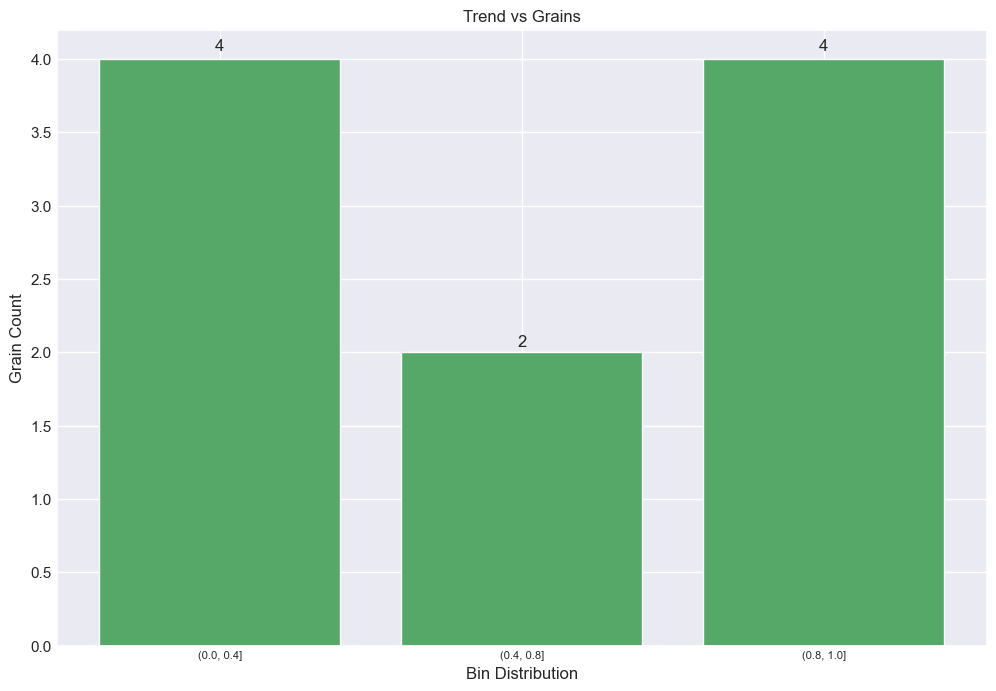

<Figure size 1200x700 with 0 Axes>

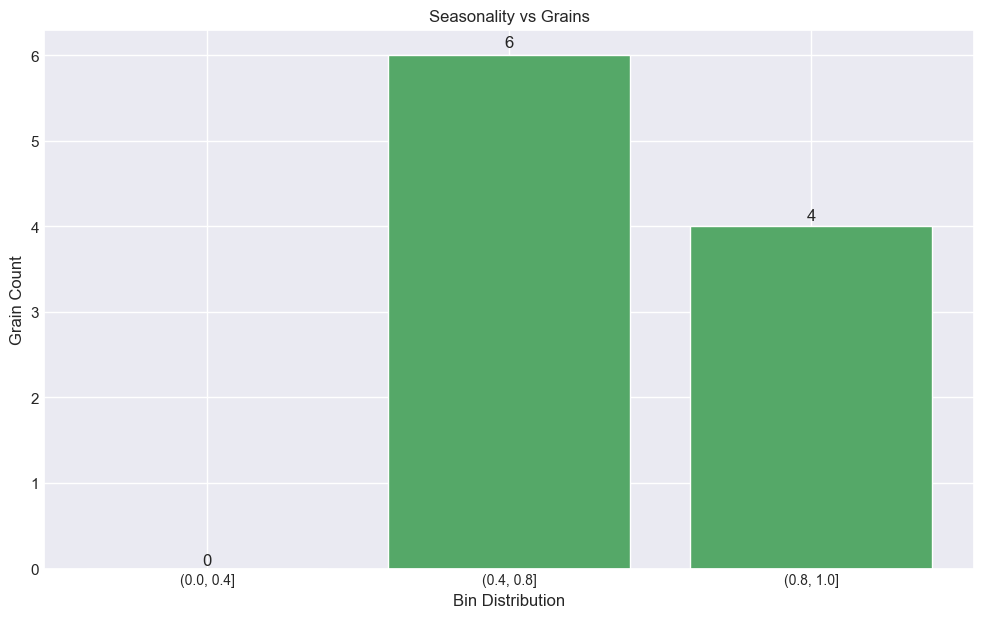

In [117]:
get_time_series_plot(stl_features,imagefile='image.png')

In [118]:
doc.add_paragraph("Trend line plots")

false_treand_data, false_treand_grains, false_treand_key_grain  = get_category(data1,  
                                                                category_data = treand_sea_feature, 
                                                                filter_col = 'trend_line', filter_condtion= False, 
                                                                measure_filter_col = 'trend')
true_treand_data, true_treand_grains, true_treand_key_grain  = get_category(data1,  
                                                                category_data = treand_sea_feature, 
                                                                filter_col = 'trend_line', filter_condtion= True, 
                                                                measure_filter_col = 'trend')

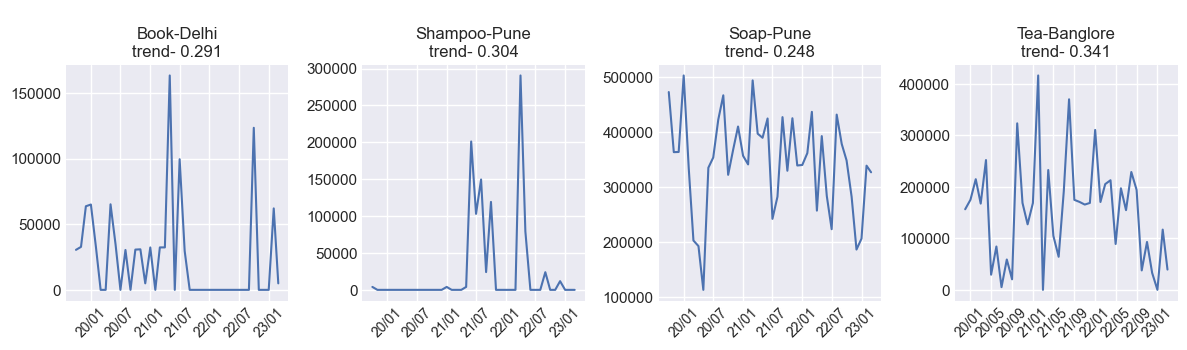

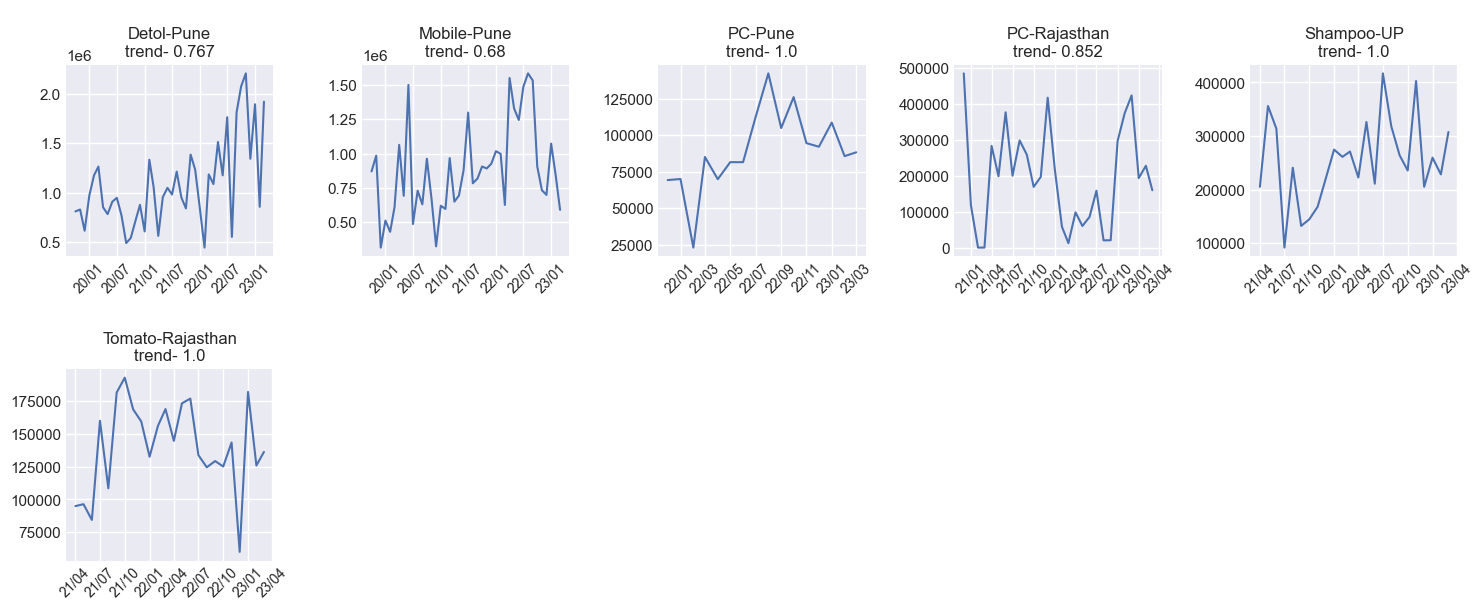

In [119]:
doc.add_paragraph('<--Low Trend-->')
plot_manysubplot(data1 = false_treand_data, title='', title_df = false_treand_key_grain, title_filter_col = 'trend',imagefile='Low Trend Subplots.png')
doc.add_paragraph('<--High Trend-->')
plot_manysubplot(data1 = true_treand_data, title='', title_df = true_treand_key_grain, title_filter_col = 'trend',imagefile='High Trend Subplots.png')


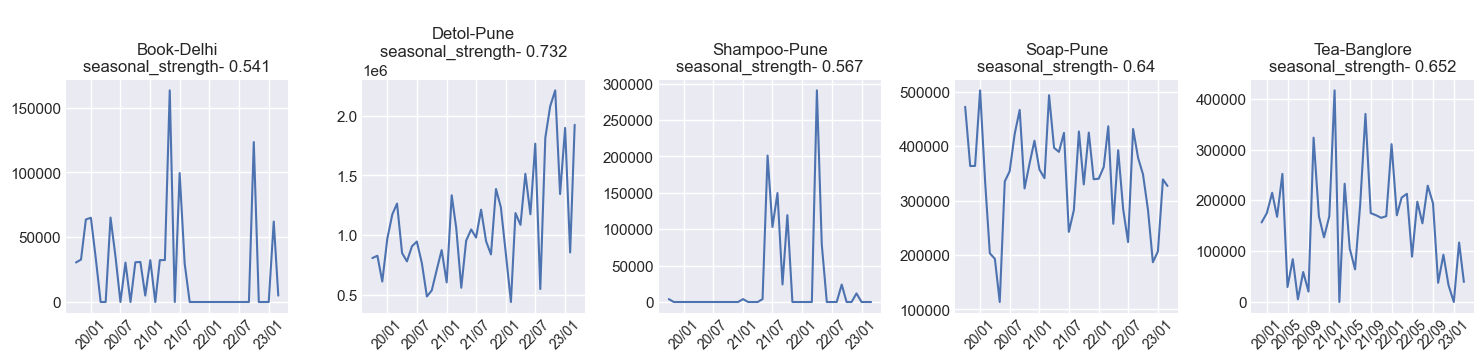

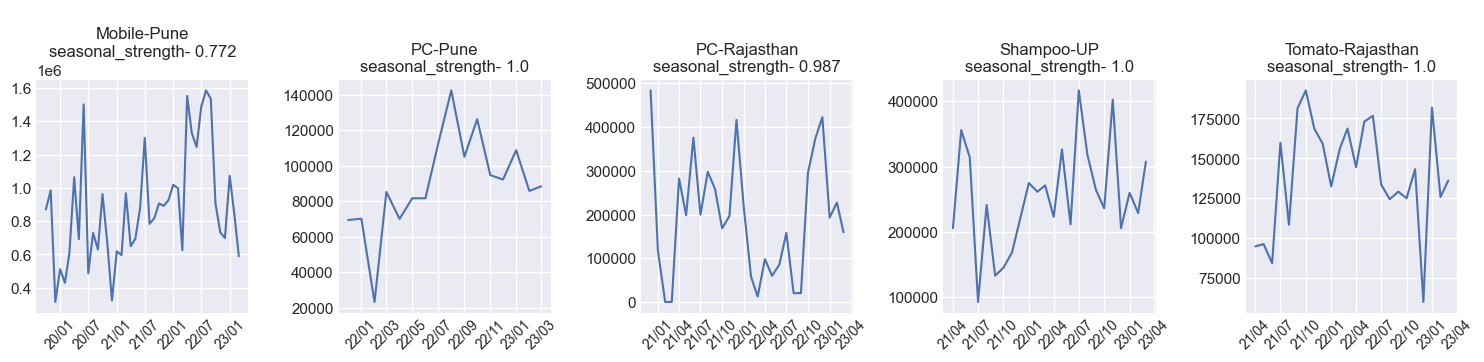

In [120]:
false_seasonal_data, false_seasonal_grains, false_seasonal_key_grain  = get_category(data1,  
                                                                category_data = treand_sea_feature, 
                                                                filter_col = 'seasonlity_line', filter_condtion= False, 
                                                                measure_filter_col = 'seasonal_strength')
true_seasonal_data, true_seasonal_grains, true_seasonal_key_grain  = get_category(data1,  
                                                                category_data = treand_sea_feature, 
                                                                filter_col = 'seasonlity_line', filter_condtion= True, 
                                                                measure_filter_col = 'seasonal_strength')
doc.add_paragraph('<--Low Seasonality-->')
plot_manysubplot(data1 = false_seasonal_data, title='', title_df = false_seasonal_key_grain, title_filter_col = 'seasonal_strength',
                 imagefile='Low Seasonality Subplots.png')
doc.add_paragraph('<--High Seasonality-->')
plot_manysubplot(data1 = true_seasonal_data, title='', title_df = true_seasonal_key_grain, title_filter_col = 'seasonal_strength',
                 imagefile='High Seasonality Subplots.png')



### Get acf and pacf features  with lag

In [121]:
from tsfeatures import acf, pacf
import numpy as np
def get_acf_pacf(x):
    try:
        d = {}
#         acf_data = acf(x[sales])
#         doc.add_paragraph(acf_data)
        x['randNumCol'] = 0.000001 * np.random.randint(0, 50, size=len(x))
        x[sales] = x[sales] + x['randNumCol']
        acf_data = acf(x[sales])
#         doc.add_paragraph(x[sales])
#         pacf_data = pacf(x[sales])
        max_acf = max(acf_data[1:])
#         max_pacf = max(pacf_data[1:])
        index_max_acf = np.where(acf_data == max_acf)[0][0]
#         index_max_pacf = np.where(pacf_data == max_pacf)[0][0]
        x['max_acf'],x['lag_acf'] = max_acf,index_max_acf
        return x[['product', 'lag_acf','max_acf']]
    except IndexError:
        doc.add_paragraph('Index Error')

# one_data = train[train[product] == '1-1']
data2 = data1[data1['product'].isin(list(data_with_count[data_with_count['total_date_count'] >= 3]['product']))]
doc.add_heading(f"{count_number}.ACF and PACF Feature \n", 1)

acf_features_only = data2.groupby(product).apply(lambda x : get_acf_pacf(x)).drop_duplicates().reset_index(drop = True)
acf_features_only.head()
count_number +=1

product  lag_acf  max_acf
0    Book-Delhi        2 0.179594
1    Detol-Pune        2 0.418713
2   Mobile-Pune        1 0.382605
3       PC-Pune        1 0.440526
4  PC-Rajasthan        1 0.332766

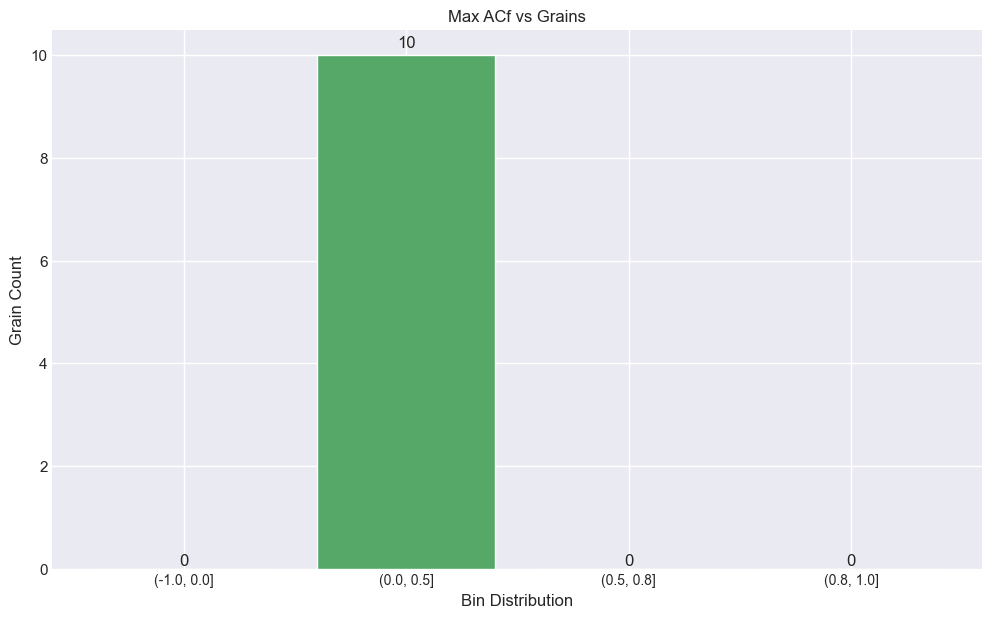

In [122]:
get_devide_in_bins(
        acf_features_only,
        self_divide=True,
        what_bins='max_acf',
        bin_points=[-1,0,0.5,0.8,1],
        chart='Max ACf',imagefile='Max ACf.png')

### Do cluster and get similar pattern

In [123]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
def get_similar_pattern(stl_features):
    doc.add_heading(f"{count_number}.Clustering and Pattern similarity",1)
    # standardizing the data
    stl_features = stl_features.fillna(10000000)
    stl_features.drop(product, axis = 1,inplace=True)
    stl_features.set_index(['unique_id'],inplace=True)
    stl_features = stl_features.astype(float)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(stl_features)
    kmeans = KMeans(n_clusters=n_cluster,init='k-means++')
    kmeans.fit(data_scaled)
    clustered_grains = pd.DataFrame(stl_features.index.astype(str),
                                    pd.Series(kmeans.predict(data_scaled))).reset_index().rename(columns={'index':'cluster'})
    return clustered_grains, kmeans.inertia_


In [124]:
cluster_df, inertia = get_similar_pattern(stl_features)
count_number += 1

cluster_df.head(2)
# cluster_df = pd.DataFrame(data = [all_products, cluster.cluster]).T
# cluster_df

cluster   unique_id
0        1  Book-Delhi
1        4  Detol-Pune

### doc.add_paragraph chart of all 5 clusters (show only 10 if more than 10 exists)

In [125]:
# select only high volumn grains 
# def get_category(data, category_data = zscore_data, filter_col = '', filter_condtion = '',measure_filter_col = None):
#     category_data.rename(columns={'unique_id' : product},inplace=True)
#     selected_data = data[data[product].isin(list(category_data[category_data[filter_col] == filter_condtion][product]))].reset_index(drop=True)
#     selected_grains = list(selected_data[product].drop_duplicates())

#     if measure_filter_col is not None:
#         key_grain = category_data[category_data[filter_col] == filter_condtion][[product, measure_filter_col]]
#         doc.add_paragraph(key_grain.head(2))
#     if len(selected_grains) < 10:
#         selected_grains = selected_grains[:len(selected_grains)]
#     else:
#         selected_grains = selected_grains[:10]
#         selected_data = data[data[product].isin(selected_grains)].reset_index(drop=True)

#     return selected_data, selected_grains, key_grain



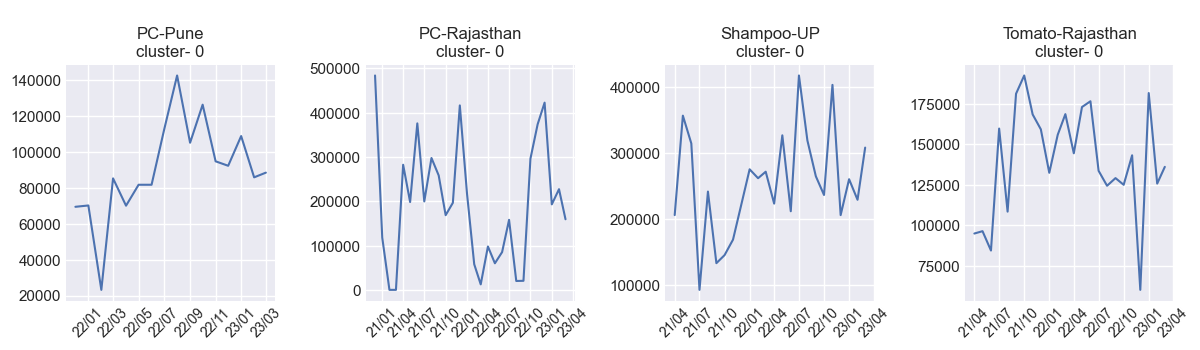

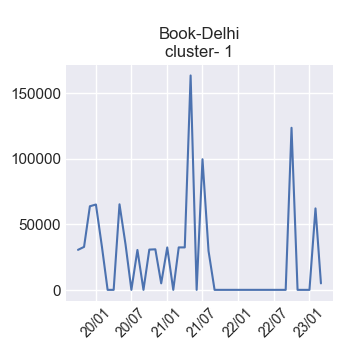

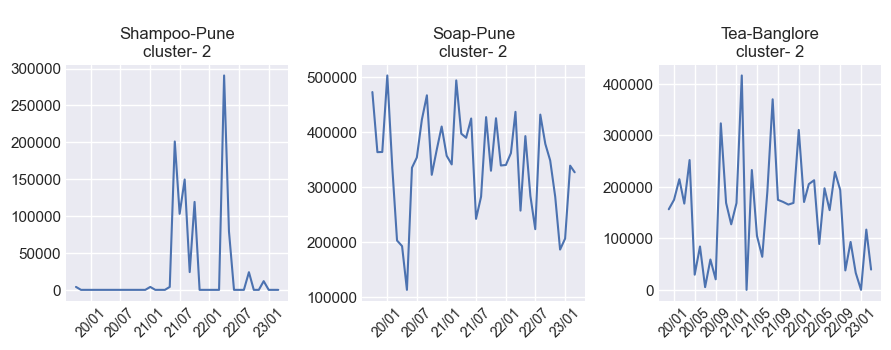

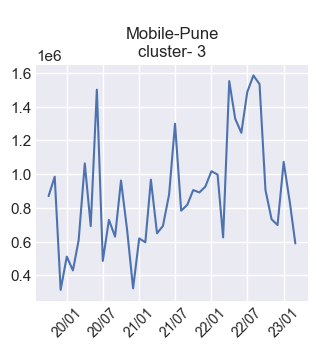

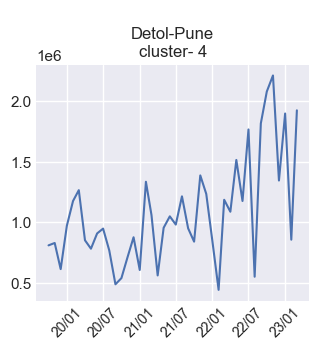

In [126]:
for i in range(n_cluster):
    doc.add_paragraph(f'Cluster-{i}')
    # 'cluster_data%s'% i , 
#     doc.add_paragraph(locals()['cluster_data_{0}'.format(i)])
    locals()['cluster_data_{0}'.format(i)], locals()['cluster_hdcty_grains_{0}'.format(i)], locals()['cluster_hdcty_grains_{0}'.format(i)] = \
    get_category(data1,  
                                                                category_data = cluster_df, 
                                                                filter_col = 'cluster', filter_condtion= i, 
                                                                measure_filter_col = 'cluster')
    plot_manysubplot(data1 = locals()['cluster_data_{0}'.format(i)], title='', title_df =  locals()['cluster_hdcty_grains_{0}'.format(i)], title_filter_col = 'cluster', 
                     imagefile='cluster_data_'+ str(i) + '.png')



### Get Entropy

In [127]:
count_filtered_data = data1[data1['product'].isin(list(data_with_count[data_with_count['total_date_count'] >= 3]['product']))]



In statistics, an approximate entropy (ApEn) is a technique used to quantify the amount of regularity and the unpredictability of fluctuations over time-series data.[1]

For example, there are two series of data:

series 1: (10,20,10,20,10,20,10,20,10,20,10,20...), which alternates 10 and 20.
series 2: (10,10,20,10,20,20,20,10,10,20,10,20,20...), which has either a value of 10 or 20, chosen randomly, each with probability 1/2.

In [128]:
from tsfeatures import entropy
def get_entropy(x):
    x = entropy(x[sales],freq= frequency)
    return x
# one_data = train[train[product] == '1-1']

entropy_features = count_filtered_data.groupby(product).apply(lambda x : get_entropy(x))
# doc.add_paragraph(entropy_features)
def get_entrophy_modified(entropy_features):
    doc.add_heading(f"{count_number}.Entropy",1)
    entropy_features = entropy_features.reset_index().rename(columns = {0: 'entropy'})
    entropy_features[['_','entropy']] = entropy_features.entropy.astype(str).str.split(":",expand=True)
    entropy_features.entropy = entropy_features.entropy.str.extract("(\d+\.\d+)",expand = True)
    entropy_features.drop(['_'],axis = 1,inplace = True)
    entropy_features.entropy = entropy_features.entropy.astype(float)
    entropy_features['entropy_flag'] = np.where(entropy_features['entropy'] <= 0.5,'False','True')
    entropy_features = entropy_features.dropna()
    return entropy_features

In [129]:
entropy_features = get_entrophy_modified(entropy_features)
count_number += 1


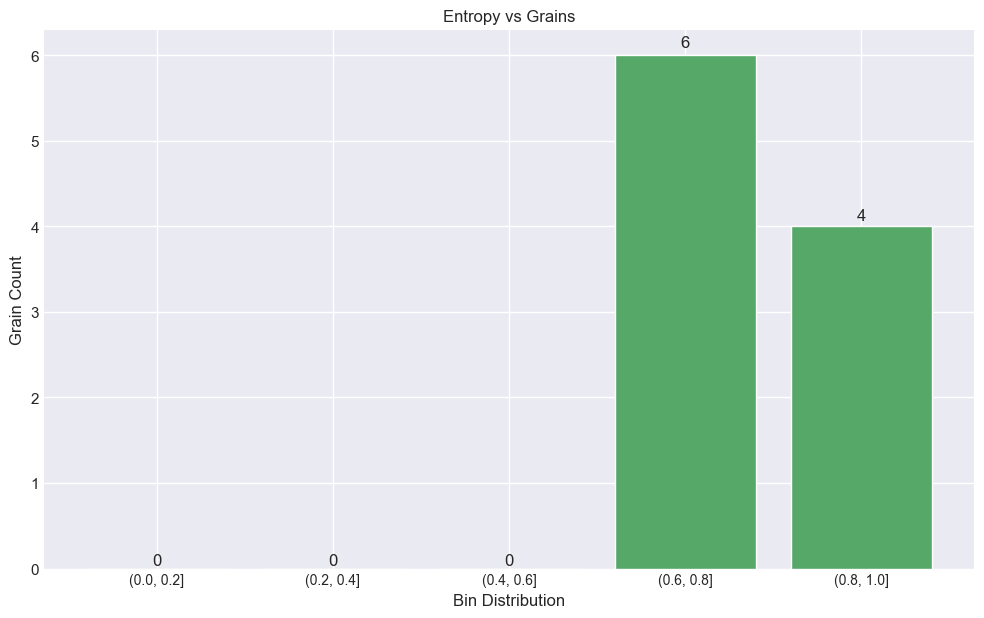

In [130]:
get_devide_in_bins(entropy_features, self_divide=True, what_bins='entropy', bin_points=[0, 0.2, 0.4, 0.6, 0.8, 1] ,chart='Entropy',imagefile='entropy.png')


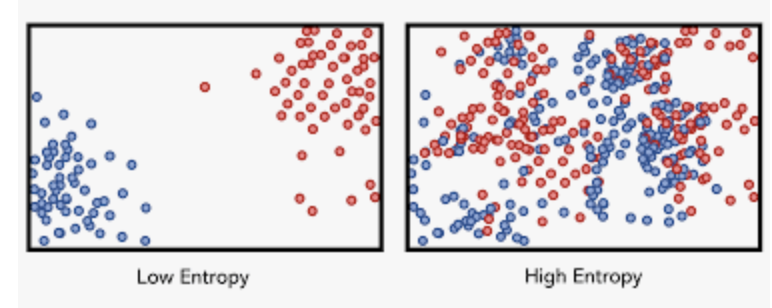

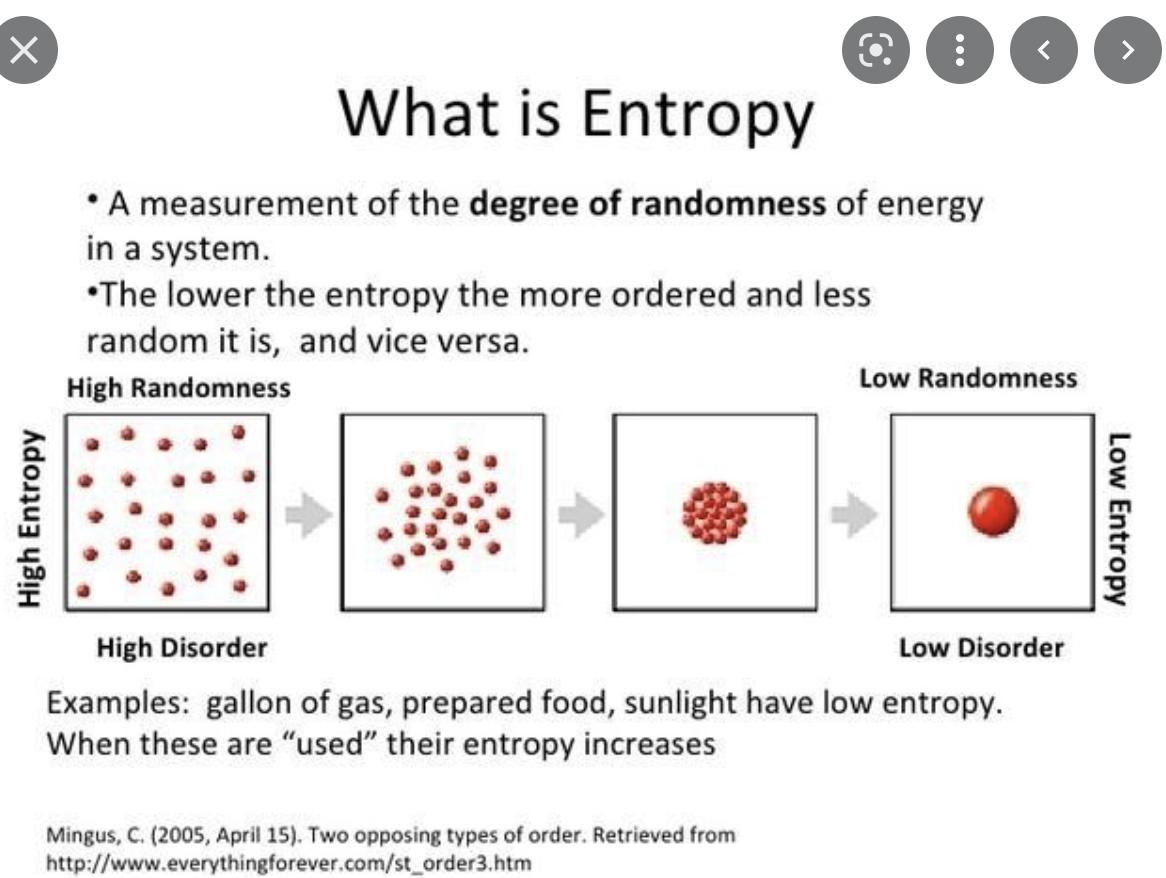

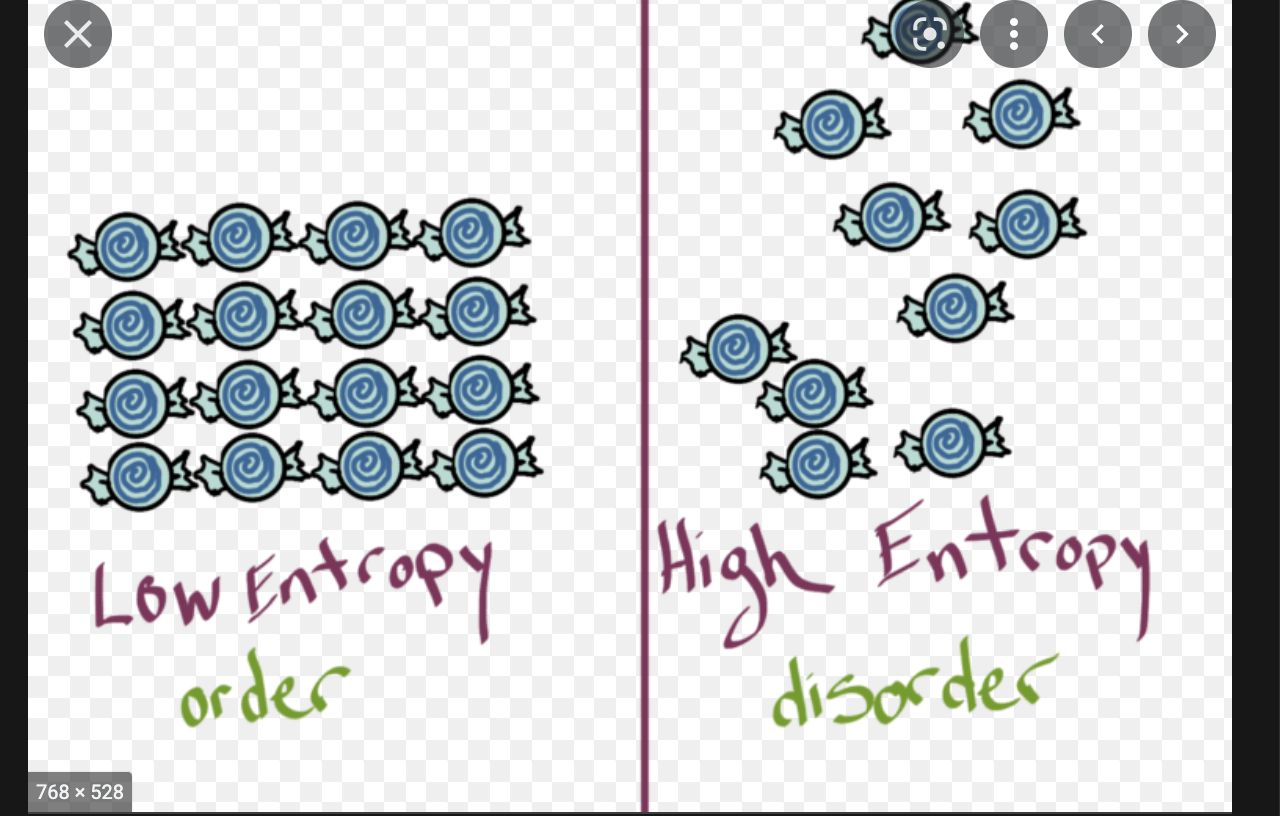

Dataframe is empty -  low_entropy_data


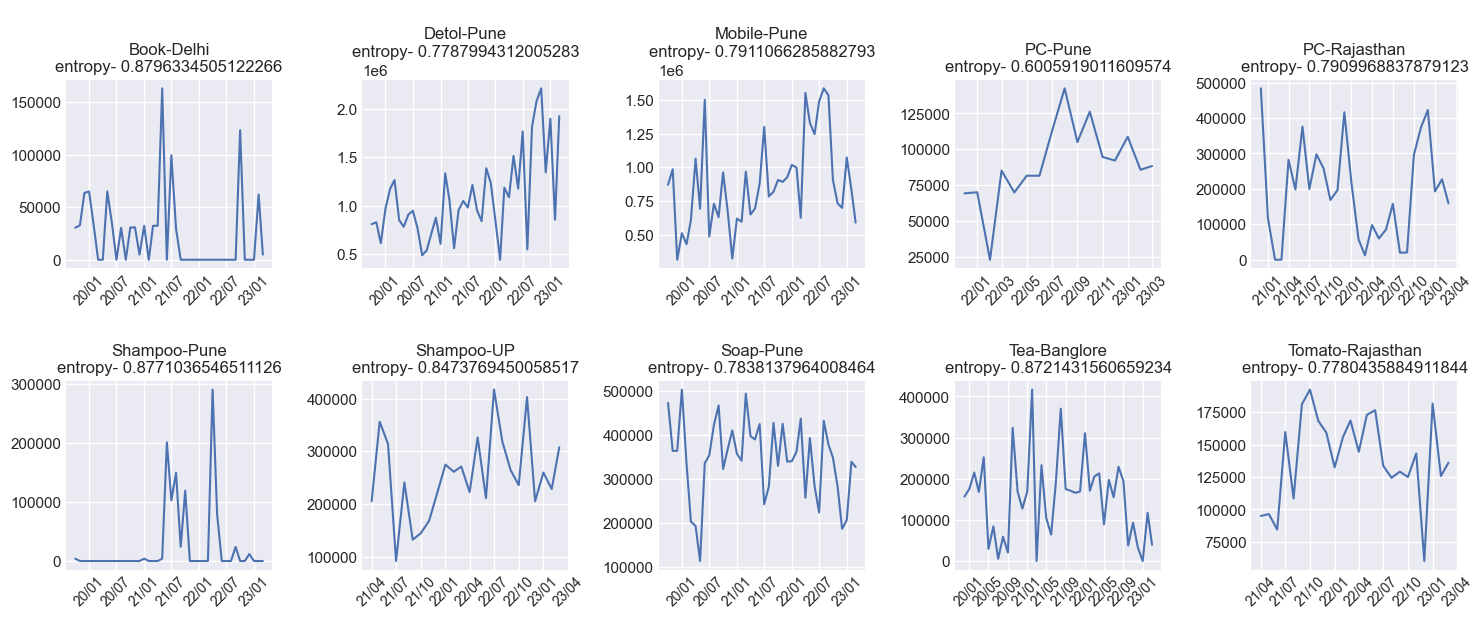

In [131]:
doc.add_paragraph("<----Low Entropy Plots--->")
low_entropy_data, low_entropy_grains, low_entropy_key_grain = get_category(data1,  
                                                                category_data = entropy_features, 
                                                                filter_col = 'entropy_flag', filter_condtion= 'False', 
                                                                measure_filter_col = 'entropy')

high_entropy_data, high_entropy_grains, high_entropy_key_grain = get_category(data1,  
                                                                category_data = entropy_features, 
                                                                filter_col = 'entropy_flag', filter_condtion= 'True', 
                                                                measure_filter_col = 'entropy')

if low_entropy_data.empty:
    doc.add_paragraph(f'{return_empty_df(low_entropy_data)}')
else: 
    plot_manysubplot(data1 = low_entropy_data, title='', title_df = low_entropy_key_grain , title_filter_col = 'entropy',imagefile='Low Entropy Plots.png')
doc.add_paragraph("<----High Entropy Plots---->")
if high_entropy_data.empty:
    doc.add_paragraph(f'{return_empty_df(high_entropy_data)}')
else: 
    plot_manysubplot(data1 = high_entropy_data, title='', title_df = high_entropy_key_grain , title_filter_col = 'entropy',imagefile='High Entropy Plots.png')


### Long term trend using MV

In [132]:
def long_term_moving_avg(data):
    if frequency == 'Monthly':
        data['rolling_sales'] = data[sales].rolling(window=12).mean()
    elif frequency == 'Weekly':
        data['rolling_sales'] = data[sales].rolling(window=21).mean()
    elif frequency == 'Daily':
        data['rolling_sales'] = data[sales].rolling(window=365).mean()
                 
    data.loc[data['rolling_sales'].isna(), 'rolling_sales'] = data[sales]
    data['rolling_median'] = data[sales].median()
    data.drop([date], axis = 1, inplace=True)
    if any(data['rolling_median'] > data['rolling_sales']):
        data['is_trend'] = 'Single/No trend' 
    else:
        data['is_trend'] = 'Trend Change'
    return data[[product,'is_trend']]

In [133]:
doc.add_heading(f"{count_number}.Trend Line \n", 1)
trend_data = data1.groupby([product]).apply(lambda x : long_term_moving_avg(x)).drop_duplicates().reset_index(drop=True)
trend_data.head()
count_number += 1



product         is_trend
0    Book-Delhi     Trend Change
1    Detol-Pune  Single/No trend
2   Mobile-Pune  Single/No trend
3       PC-Pune  Single/No trend
4  PC-Rajasthan  Single/No trend

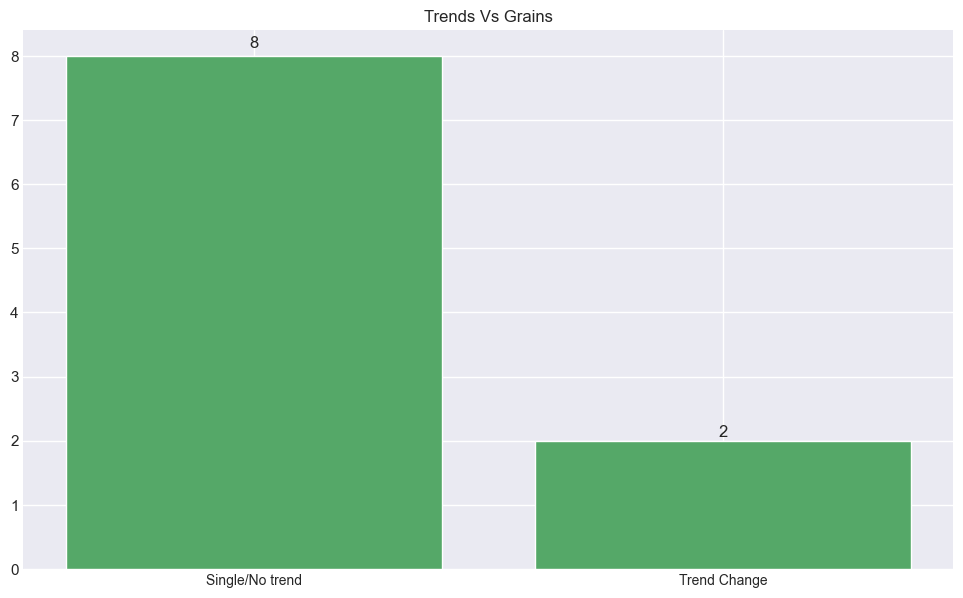

In [134]:
plot_bar(trend_data,'is_trend', product, title = 'Trends Vs Grains',imagefile='single_noTrend Vs Grains.png')



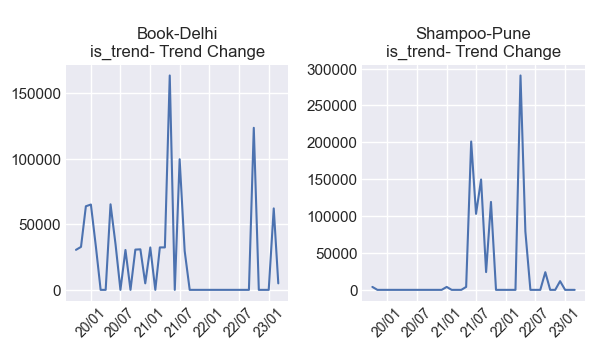

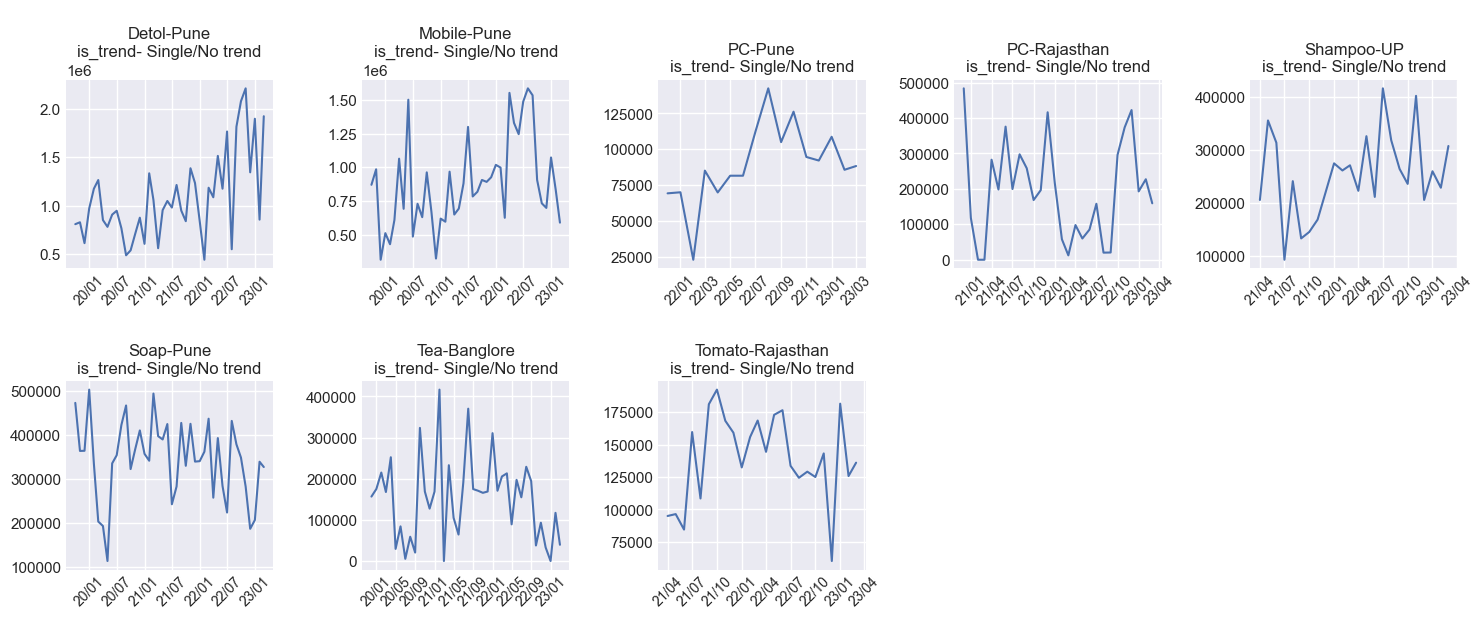

In [135]:
trend_change_data, trend_change_grains, trend_change_key_grain = get_category(data1,  
                                                                category_data = trend_data, 
                                                                filter_col = 'is_trend', filter_condtion= 'Trend Change', 
                                                                measure_filter_col = None)

high_entropy_data, high_entropy_grains, high_entropy_key_grain = get_category(data1,  
                                                                category_data = trend_data, 
                                                                filter_col = 'is_trend', filter_condtion= 'Single/No trend', 
                                                                measure_filter_col = None)

plot_manysubplot(data1 = trend_change_data, title='', title_df = trend_change_key_grain , title_filter_col = 'is_trend',imagefile='trendchange.png')
plot_manysubplot(data1 = high_entropy_data, title='', title_df = high_entropy_key_grain , title_filter_col = 'is_trend',imagefile='noOrSingleTrend.png')


### Ducky fullar test (Stationary or not)

In [136]:
from statsmodels.tsa.stattools import adfuller
def ADF_test(x):
    indexedDataset = x[sales].fillna(method='ffill')
    try :
        result = adfuller(indexedDataset)
        x['ducky_results'] = round(result[1],5)
        if result[1] < 0.05:
            x['result'] = False
#         doc.add_paragraph('p values less than 0.5, reject null hypo -',result[1])
            return x[[product,'ducky_results','result']]
        else:
            x['result'] = True
#         doc.add_paragraph('p values less not 0.5, accept null hypo -',result[1])
            return  x[[product, 'ducky_results', 'result']]
    except ValueError:
        x['ducky_results'] = -1
        x['result'] = False
        doc.add_paragraph("Ducky results -1 represent CND due to constant time series.")
        return x[[product,'ducky_results','result']]

In [137]:
count_filtered_data = data1[data1['product'].isin(list(data_with_count[data_with_count['total_date_count'] >=5]['product']))]
doc.add_heading(f"{count_number}.Stationary Test(Ducky Fullar Test)",1)
fuller_data = count_filtered_data.groupby([product]).apply(lambda x: ADF_test(x)).drop_duplicates().reset_index(drop=True)
fuller_data.head()
count_number += 1




product  ducky_results  result
0    Book-Delhi       0.000000   False
1    Detol-Pune       0.926350    True
2   Mobile-Pune       0.770730    True
3       PC-Pune       0.215710    True
4  PC-Rajasthan       0.012650   False

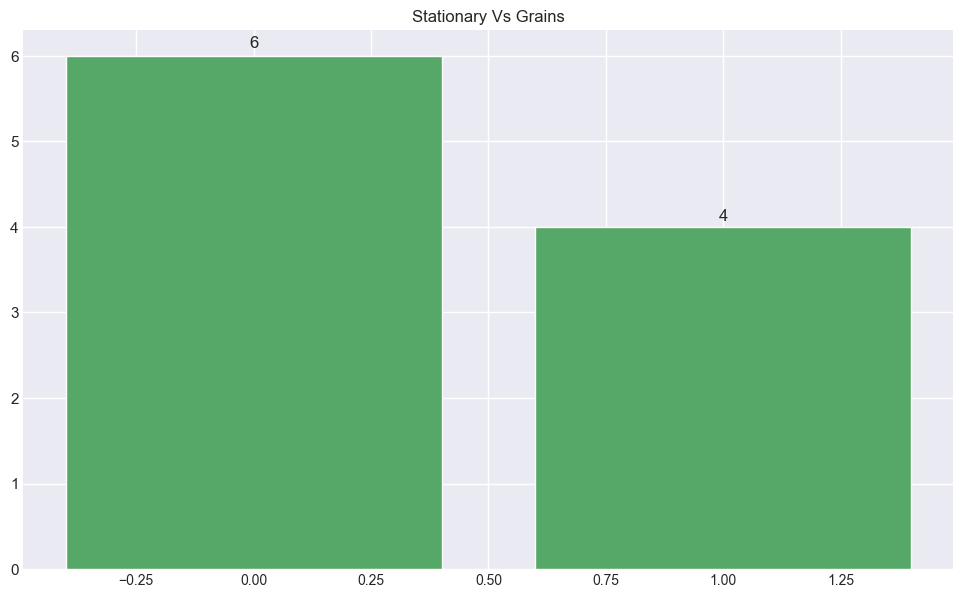

In [138]:
# get_user_defined_plot()

plot_bar(fuller_data, 'result', product, title = 'Stationary Vs Grains',imagefile = 'Stationary Vs Grains.png')


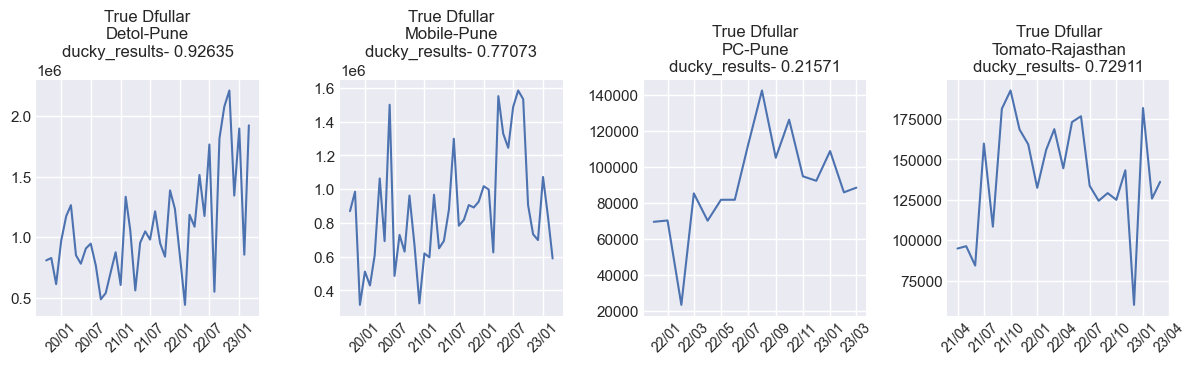

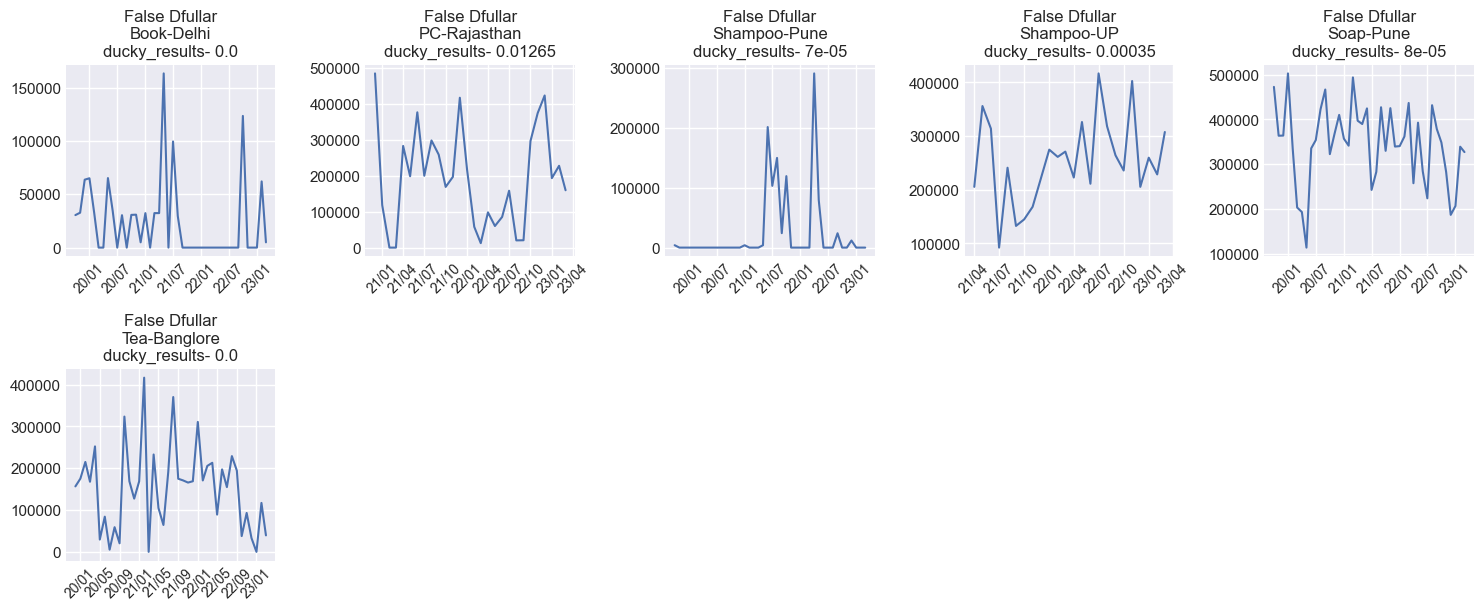

In [139]:
true_dfullar_data, true_dfullar_grains, true_dfullar_key_grain = get_category(data1,  
                                                                category_data = fuller_data, 
                                                                filter_col = 'result', filter_condtion= True, 
                                                                measure_filter_col = 'ducky_results')

false_dfullar_data, false_dfullar_grains, false_dfullar_key_grain = get_category(data1,  
                                                                category_data = fuller_data, 
                                                                filter_col = 'result', filter_condtion= False, 
                                                                measure_filter_col = 'ducky_results')


plot_manysubplot(data1 = true_dfullar_data, title='True Dfullar', title_df = true_dfullar_key_grain , title_filter_col = 'ducky_results',imagefile='True Dfullar.png')
plot_manysubplot(data1 = false_dfullar_data, title='False Dfullar', title_df = false_dfullar_key_grain , title_filter_col = 'ducky_results',imagefile='False Dfullar.png')




### Get Level shift

Level shifts in time series are situations where at particular time steps, there is a shift in the nominal values of the process from one level to another level. Between two consecutive changes in levels, the process may behave like a standard Autoregressive Moving Average (ARMA) process.

Two examples of level shifts:

Day trading stocks that vary from close of trade on one day to start of trade on the next
Temperature or humidity sensors on shop floors which record level shifts between the end of one machining operation, for instance, to the start of the next one
What this means in practice is that a few values periodically (or aperiodically) tend to be shifted away from the process mean, resulting in outlier values. Level shift analysis is generally a part of time series analysis using models like ARIMA.

Further reading: https://cran.r-project.org/web/packages/tsoutliers/tsoutliers.pdf - this package called “tsoutliers” in R has functions for detecting outliers and level shifts in data.


In [140]:
def max_level_shift(data, width):
    max_level_shift = []
    if frequency == 'Monthly':
        data['rolling_sales'] = data[sales].rolling(window=12).mean()
    elif frequency == 'Weekly':
        data['rolling_sales'] = data[sales].rolling(window=21).mean()
    elif frequency == 'Daily':
        data['rolling_sales'] = data[sales].rolling(window=182).mean()
        
    num_list = list(data.rolling_sales)
    try:
        for idx in range(0, len(num_list)):
            if num_list[idx+width]-num_list[idx] != pd.isna:
                max_level_shift.append(abs(num_list[idx+width]-num_list[idx]))
    except IndexError:
        stop = 'null'
    l = [x for x in max_level_shift if ~np.isnan(x)]
    if l ==[]:
        data['max_level_shift'] = 0
        data['time_level_shift'] = 0
        data = data.drop_duplicates()
    else:
        data['max_level_shift'] = max(l)
        data['time_level_shift'] = max_level_shift.index(max(l))
        data = data.drop_duplicates()
    return data[[product,'max_level_shift','time_level_shift']]

In [141]:
doc.add_heading(f"{count_number}.Level Shift \n", 1)

level_shift_data = data.groupby([product]).apply(lambda x : max_level_shift(x,12))
level_shift_data.head(4)
count_number += 1


product  max_level_shift  time_level_shift
0  Book-Delhi     37995.000000                22
1  Book-Delhi     37995.000000                22
2  Book-Delhi     37995.000000                22
3  Book-Delhi     37995.000000                22

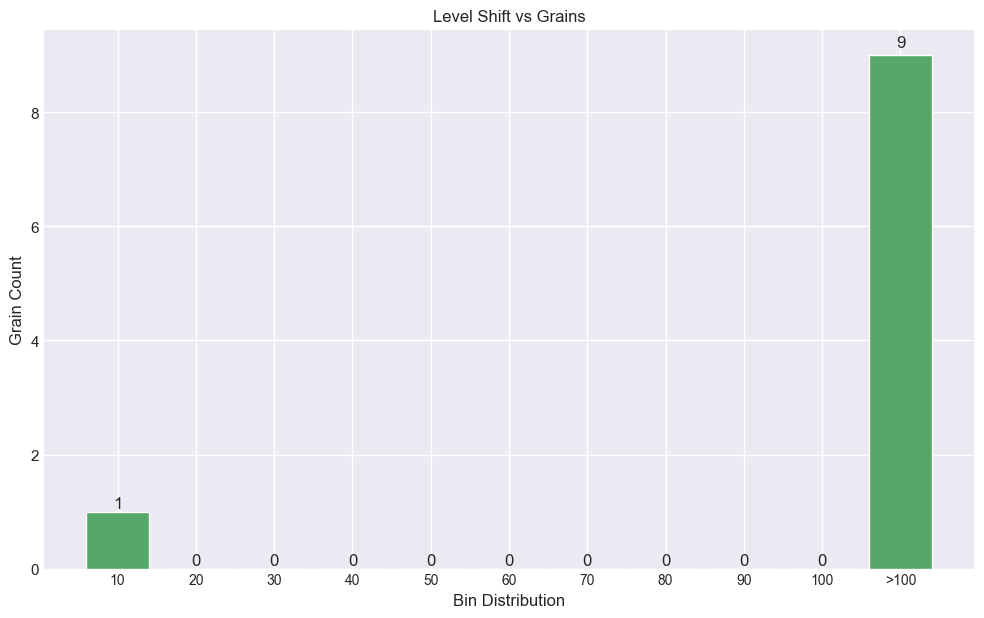

In [142]:
level_shift_data = level_shift_data.drop_duplicates()
get_devide_in_bins(level_shift_data,self_divide=True, what_bins='max_level_shift', 
                number_of_bins=10, chart='Level Shift',imagefile = 'Level Shift.png')


# last 1 year outlier

In [143]:
# last_range_outlier = 12

In [144]:
import datetime
from dateutil.relativedelta import *
def get_last_12_months(frequency):
    if frequency == 'Monthly':
        last_range_outlier = 12
        curr_date = (datetime.datetime.today() + relativedelta(months=-1))
        last_12_months = []
        for i in range(last_range_outlier):
            curr_date += datetime.timedelta()
            use_date = curr_date+relativedelta(months=-i)
            last_12_months.append(use_date.strftime('%Y%m'))
    elif frequency == 'Weekly':
        last_range_outlier = 52
        curr_date = (datetime.datetime.today() + relativedelta(weeks=-1))
        last_12_months = []
        for i in range(last_range_outlier):
            curr_date += datetime.timedelta()
            use_date = curr_date+relativedelta(weeks=-i)
            last_12_months.append(use_date.strftime('%Y%W'))
    elif frequency == 'Daily':
        last_range_outlier = 90
        curr_date = (datetime.datetime.today() + relativedelta(days=-1))
        last_12_months = []
        for i in range(last_range_outlier):
            curr_date += datetime.timedelta()
            use_date = curr_date+relativedelta(months=-i)
            last_12_months.append(use_date.strftime('%Y%m%d'))
    last_12_months = list(map(int,last_12_months))
    return last_12_months
last_12_months = get_last_12_months(frequency = frequency)
last_12_months

[202307,
 202306,
 202305,
 202304,
 202303,
 202302,
 202301,
 202212,
 202211,
 202210,
 202209,
 202208]

In [145]:
list_of_grain_outliers = []
import datetime
from scipy import stats
from dateutil.relativedelta import *
def outlier(x):
    z = np.abs(stats.zscore(x[sales]))
    z = stats.zscore(x[sales]).reset_index(drop=True)
    x = x.reset_index(drop = True)
#     doc.add_paragraph(x)
#     doc.add_paragraph(pd.Series(z > 2)| pd.Series(z < -2))
#     doc.add_paragraph(x[pd.Series(z > 2)| pd.Series(z < -2)][date])
    outlier_months = list(x[pd.Series(z > 2)| pd.Series(z < -2)][date])
    if len(outlier_months) == 0:
        x['outlier_count'] = 0
        x['outlier_date'] = 'No Date'
        x['isoutlier'] = False
    else:
        x['outlier_count'] = len(outlier_months)
        x['outlier_date'] = str(list(outlier_months))
        x['isoutlier'] = True
    return x[[product, 'outlier_count', 'outlier_date','isoutlier']]

In [146]:
z_score_data_last1year = count_filtered_data.groupby([product]).apply(lambda x : outlier(x))
z_score_data_last1year.head(2)

product  outlier_count              outlier_date  isoutlier
product                                                                     
Book-Delhi 0  Book-Delhi              3  [202105, 202107, 202210]       True
           1  Book-Delhi              3  [202105, 202107, 202210]       True

In [147]:
def get_group_first(data):
    doc.add_heading(f"{count_number}.Outlier in last 1 year")
    data_first = data.groupby([product]).first()
    return data_first

z_score_data_last1year = z_score_data_last1year.reset_index(drop=True)

zscore_last1year_data = get_group_first(z_score_data_last1year)
zscore_last1year_data = zscore_last1year_data.reset_index()
zscore_last1year_data.head(2)
count_number += 1


product  outlier_count              outlier_date  isoutlier
0  Book-Delhi              3  [202105, 202107, 202210]       True
1  Detol-Pune              2          [202210, 202211]       True

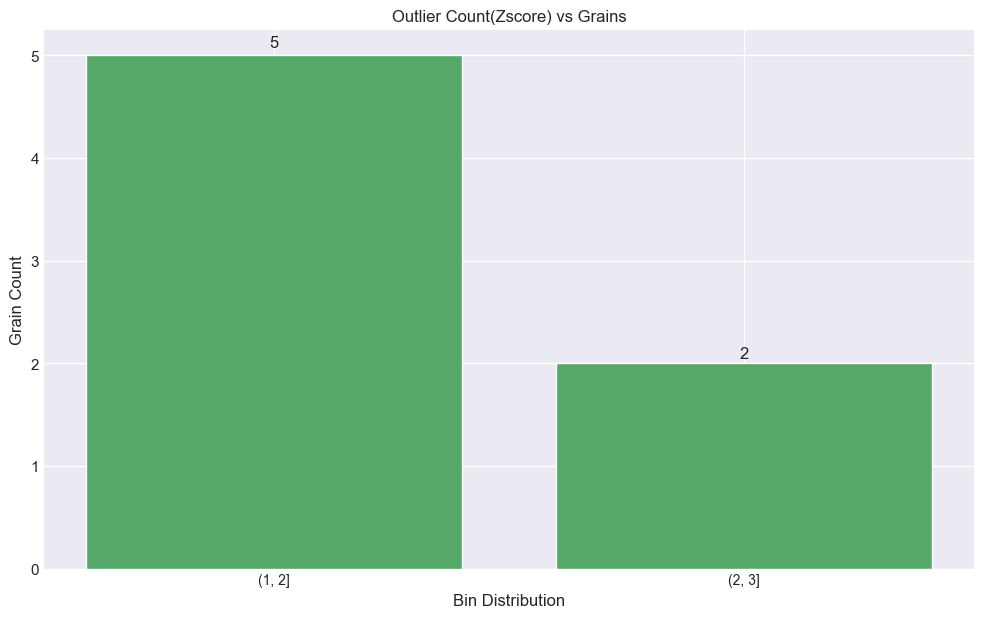

In [167]:
get_devide_in_bins(zscore_last1year_data,self_divide = True,what_bins = 'outlier_count',
                   bin_points=[min(zscore_last1year_data.outlier_count),int((max(zscore_last1year_data.outlier_count)/4) + 1),int((max(zscore_last1year_data.outlier_count)/2) + 1),max(zscore_last1year_data.outlier_count)],
                   chart = 'Outlier Count(Zscore)',imagefile = 'Outlier Count_Zscore_.png')


<Figure size 1500x1500 with 0 Axes>

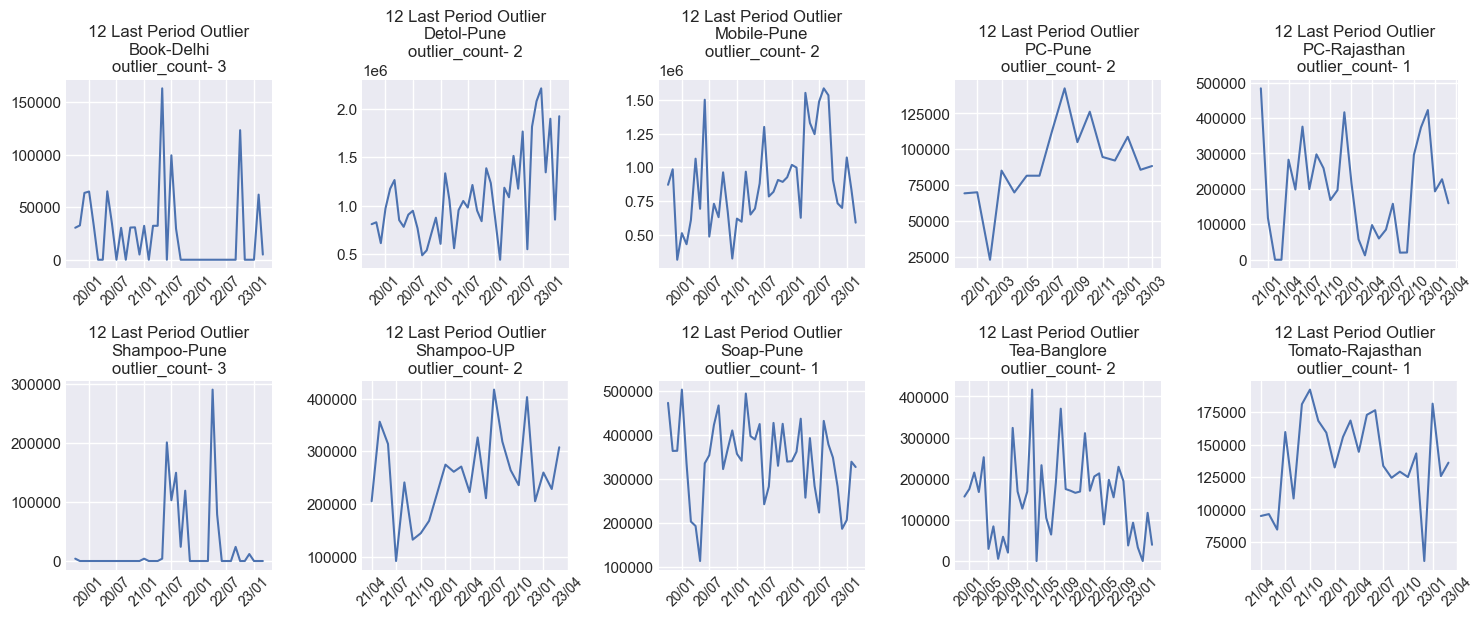

In [168]:
false_outlier_last_data, false_outlier_last_grains, false_outlier_last_key_grain = get_category(data1,  
                                                                category_data = zscore_last1year_data, 
                                                                filter_col = 'isoutlier', filter_condtion= False, 
                                                                measure_filter_col = 'outlier_count')

                                                           

true_outlier_last_data, true_outlier_last_grains, true_outlier_last_key_grain = get_category(data1,  
                                                                category_data = zscore_last1year_data, 
                                                                filter_col = 'isoutlier', filter_condtion= True, 
                                                                measure_filter_col = 'outlier_count')

                                                           

    
plot_manysubplot(data1 = false_outlier_last_data, title= str(last_range_outlier) + ' Last Period Outlier', title_df = false_outlier_last_key_grain , title_filter_col = 'outlier_count',imagefile = 'false_outlier_last_data.png')
plot_manysubplot(data1 = true_outlier_last_data, title= str(last_range_outlier) + ' Last Period Outlier', title_df = true_outlier_last_key_grain , title_filter_col = 'outlier_count', imagefile='true_outlier_last_data.png')




# Percent of zeros

In [169]:
def percent_of_zeros(x):
    zeros = 0
    if any(x[sales] == zeros):
        data_zeros = x[x[sales] == zeros][sales]
        data_zeros_count = len(data_zeros)
    else:
        data_zeros_count = 0
    x['count_zeros'] = data_zeros_count
    x['data_points_size'] = x.shape[0]
    x['zeros_percent'] = round((x['count_zeros']/x['data_points_size']) * 100,2)
    if any(x['zeros_percent'] > 50):
        x['zero_percent_flag'] = True
    else:
        x['zero_percent_flag'] = False

    x = x[[product, 'count_zeros','data_points_size', 'zeros_percent', 'zero_percent_flag']]
    return x


In [170]:
doc.add_heading(f"{count_number}.Number of Zeros",1)
zeroes_data = count_filtered_data.groupby([product]).apply(lambda x : percent_of_zeros(x)).drop_duplicates().reset_index(drop = True)
zeroes_data.head(2)
count_number += 1


product  count_zeros  data_points_size  zeros_percent  zero_percent_flag
0  Book-Delhi           22                42      52.380000               True
1  Detol-Pune            0                42       0.000000              False

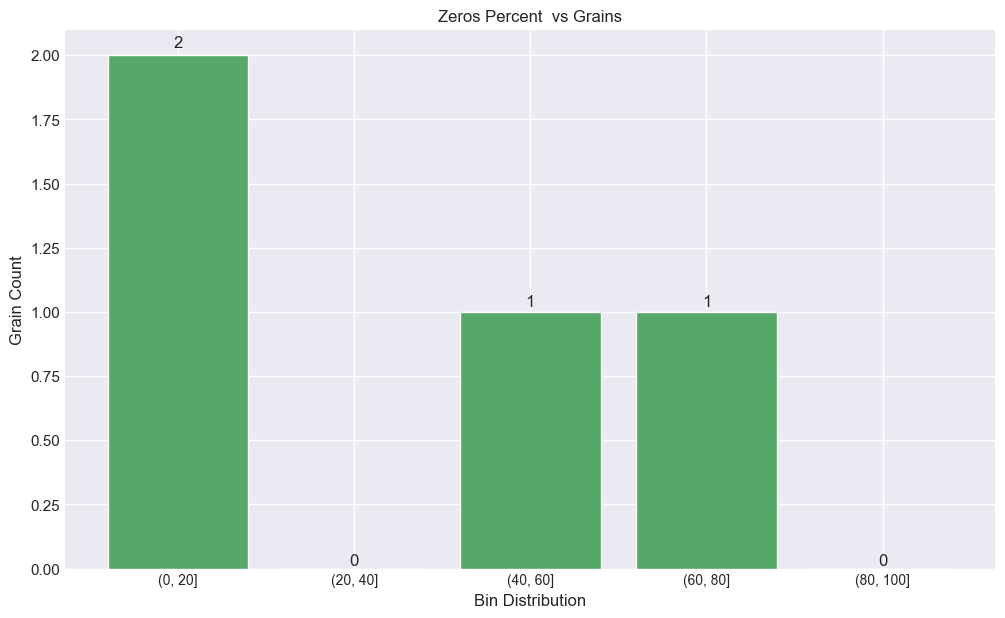

In [171]:
get_devide_in_bins(zeroes_data,self_divide=True,what_bins='zeros_percent',chart='Zeros Percent ',bin_points=[0,20,40,60,80,100],imagefile='Zeros Percent.png')


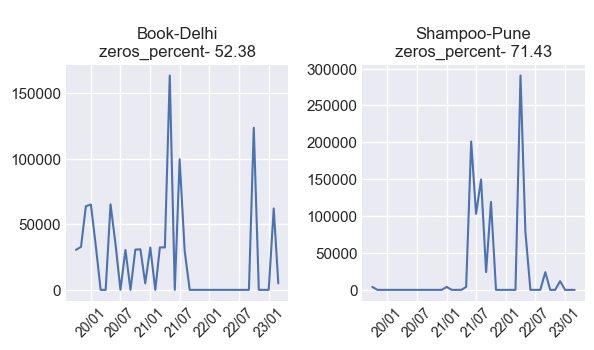

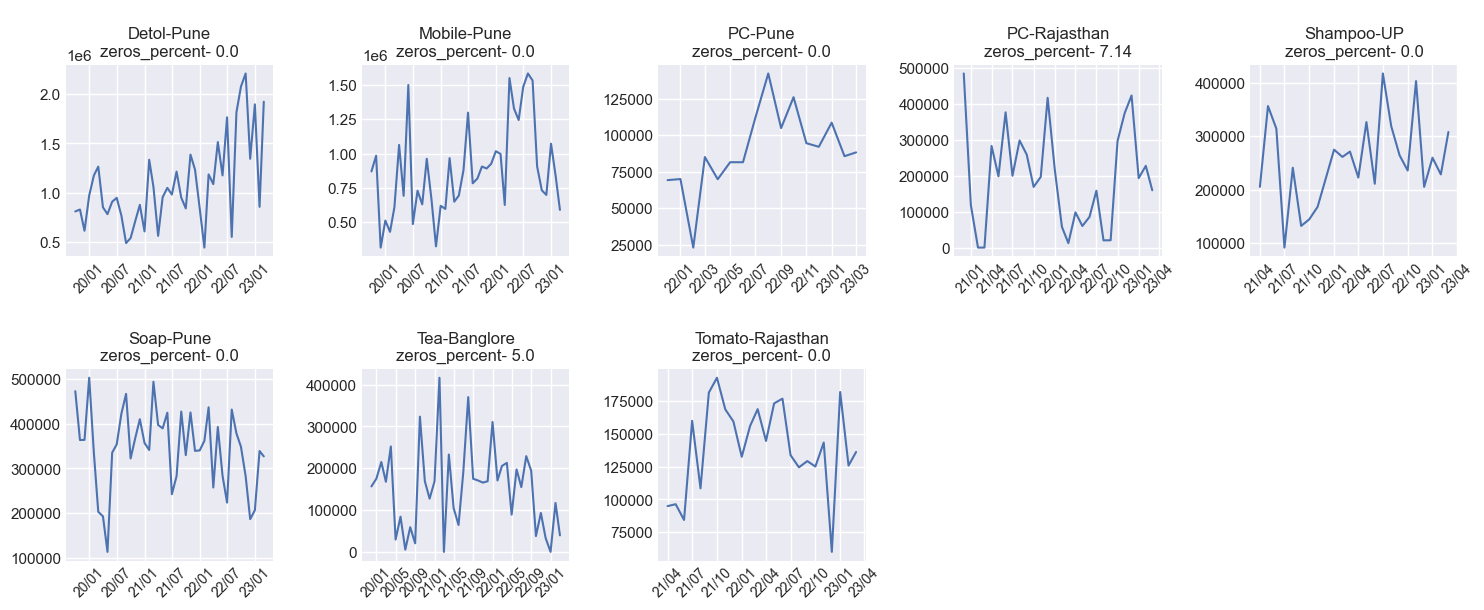

In [172]:
true_zeros_data, true_zeros_grains, true_zeros_key_grain = get_category(data1,  
                                                                category_data = zeroes_data, 
                                                                filter_col = 'zero_percent_flag', filter_condtion= True, 
                                                                measure_filter_col = 'zeros_percent')
if true_zeros_data.empty:
    doc.add_paragraph(f'{return_empty_df(true_zeros_data)}')
else: 
    doc.add_paragraph(f'Zeros Examples')
    plot_manysubplot(data1 = true_zeros_data, title= '', title_df = true_zeros_key_grain , title_filter_col = 'zeros_percent',imagefile='true_zeros_data.png')

false_zeros_data, false_zeros_grains, false_zeros_key_grain = get_category(data1,  
                                                                category_data = zeroes_data, 
                                                                filter_col = 'zero_percent_flag', filter_condtion= False, 
                                                                measure_filter_col = 'zeros_percent')
if false_zeros_data.empty:
    doc.add_paragraph(f'{return_empty_df(false_zeros_data)}')
else: 
    doc.add_paragraph(f'No Zeros Examples')

    plot_manysubplot(data1 = false_zeros_data, title= '', title_df = false_zeros_key_grain , title_filter_col = 'zeros_percent',imagefile='false_zeros_data.png')



In [173]:
sales_mean = data.groupby([product])[sales].agg(sales_mean = 'mean')
sales_mean['binned'] = pd.cut(sales_mean['sales_mean'], [0,1000,10000,1000000, np.inf])
sales_mean.binned.value_counts()


(10000.0, 1000000.0]    9
(1000000.0, inf]        1
(0.0, 1000.0]           0
(1000.0, 10000.0]       0
Name: binned, dtype: int64

## Repeatitative values

In [174]:
def get_repetitative_count_as_1(data_, repeate_count=5):
    doc.add_heading(f"{count_number}.Repeatitative 1 value", 1)
#     data_ = data.copy()
    g = data_[sales].ne(data_[sales].shift()).cumsum()
 
    counts = data_.groupby([product,g])[sales].transform('size')
    print(counts)
    data_['consecutive_one_count'] = np.where(data_[sales].eq(1), counts, 0)
    def count_1(x):
        if any(x['consecutive_one_count'] > repeate_count) :
            x['consecutive_one_count'] = repeate_count
            x['flag_repeat_1'] = True
        else :
            x['consecutive_one_count'] = 0
            x['flag_repeat_1'] = False
        return x
    data_1 = data_.groupby([product]).apply(lambda x : count_1(x))
    return data_1[[product,'consecutive_one_count','flag_repeat_1']].drop_duplicates().reset_index(drop  = True)
    



In [175]:
get_count_as_1 = get_repetitative_count_as_1(data)
get_count_as_1.head(2)
count_number += 1


0      1
1      1
2      1
3      1
4      1
      ..
337    1
338    1
339    1
340    1
341    1
Name: Quantity, Length: 342, dtype: int64


product  consecutive_one_count  flag_repeat_1
0  Book-Delhi                      0          False
1  Detol-Pune                      0          False

In [176]:
~get_count_as_1['consecutive_one_count'].any()

True

In [177]:
if ~get_count_as_1['consecutive_one_count'].any():
    doc.add_paragraph("There is no grain having consecuting count as 1")
else:
    get_devide_in_bins(get_count_as_1,self_divide=True,what_bins='consecutive_one_count',
                   chart='Repeatitave 1 values', bin_points=[0,10,20,30,40,50],label=['0-10','10-20','20-30','30-40','>50'],imagefile='consecutive_one_count.png')



In [178]:
const1_data, const1_zeros_grains, const1_zeros_key_grain = get_category(data1,  
                                                                category_data = get_count_as_1, 
                                                                filter_col = 'flag_repeat_1', filter_condtion= True, 
                                                                measure_filter_col = 'consecutive_one_count')
if const1_data.empty:
    pass
else:
    plot_manysubplot(data1 = const1_data, title= '', title_df = const1_zeros_key_grain , title_filter_col = 'consecutive_one_count',imagefile='consecutive_one_count.png')



In [179]:
def get_repetitative_count_as_0(data_, repeate_count=3):
    doc.add_heading(f"{count_number}.Repeatitative 0 value", 1)
    g = data_[sales].ne(data_[sales].shift()).cumsum()
    counts = data_.groupby([product,g])[sales].transform('size')
    data_['consecutive_zero_count'] = np.where(data_[sales].eq(0), counts, 0)
    def count_0(x):
        if any(x['consecutive_zero_count'] > repeate_count) :
            x['consecutive_zero_count'] = repeate_count
            x['flag_repeat_0'] = True
        else :
            x['consecutive_zero_count'] = 0
            x['flag_repeat_0'] = False
        return x
    data_1 = data_.groupby([product]).apply(lambda x : count_0(x))
    return data_1[[product,'consecutive_zero_count','flag_repeat_0']].drop_duplicates().reset_index(drop  = True)
    


In [180]:

get_count_as_0 = get_repetitative_count_as_0(data,repeate_count = 2)
get_count_as_0.head(2)
count_number += 1


product  consecutive_zero_count  flag_repeat_0
0  Book-Delhi                       2           True
1  Detol-Pune                       0          False

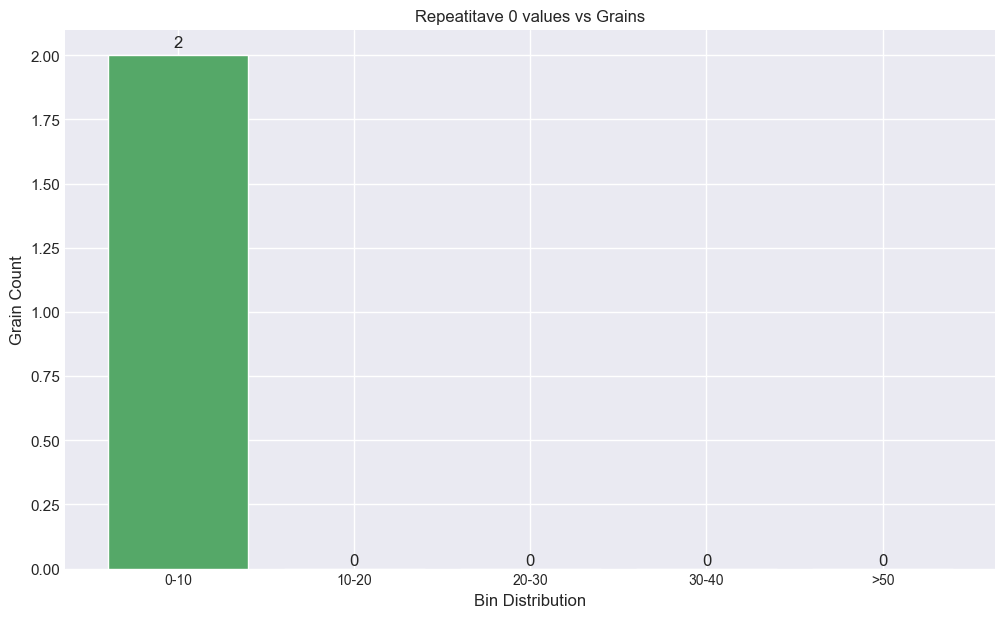

In [181]:
if len(get_count_as_0) > 0:
    get_devide_in_bins(get_count_as_0,self_divide=True,what_bins='consecutive_zero_count',
                   chart='Repeatitave 0 values', bin_points=[0,10,20,30,40,50],label=['0-10','10-20','20-30','30-40','>50'],imagefile='consecutive_zero_count.png')
    
    

In [182]:
const0_data, const0_zeros_grains, const0_zeros_key_grain = get_category(data1,  
                                                                category_data = get_count_as_0, 
                                                                filter_col = 'flag_repeat_0', filter_condtion= False, 
                                                                measure_filter_col = 'consecutive_zero_count')
if const1_data.empty:
    doc.add_paragraph("There is no grain having consecuting count as 0")
else:
    plot_manysubplot(data1 = const0_data, title= '', title_df = const0_zeros_key_grain , title_filter_col = 'consecutive_zero_count',imagefile='consecutive_zero_count_subplot.png')


### Flat sales

In [183]:
def get_flat_sales(data):
    doc.add_heading(f"{count_number}.Flat Sales", 1)

    std_data = data.groupby([product])[sales].std().reset_index()
    std_data = std_data.rename(columns={sales: 'sales_std_flat'})
    std_full_data = pd.merge(data, std_data, on=[product], how='inner')
    if any(std_full_data['sales_std_flat'] >= 2):
        doc.add_paragraph(f'No flat grains found and variablity present in sales')
        std_full_data['variation'] = 'High Variation'
    elif any(std_full_data['sales_std_flat'] == 0):
        std_full_data['variation'] = 'Low Variation'
    else:
        doc.add_paragraph("Middle variation grains")
        std_full_data['variation'] = 'Mid variation'
    return std_full_data[[product, 'variation','sales_std_flat']].drop_duplicates()
    
flat_sales_data = get_flat_sales(data)
flat_sales_data.head(2)
count_number += 1


product       variation  sales_std_flat
0   Book-Delhi  High Variation    36781.977879
42  Detol-Pune  High Variation   443470.434579

In [184]:
try:
    flat_sales_data.head()
except AttributeError:
    doc.add_paragraph("Datafram is empty")

product       variation  sales_std_flat
0      Book-Delhi  High Variation    36781.977879
42     Detol-Pune  High Variation   443470.434579
84    Mobile-Pune  High Variation   334538.072759
126       PC-Pune  High Variation    27122.676692
142  PC-Rajasthan  High Variation   138878.843469

### Plot

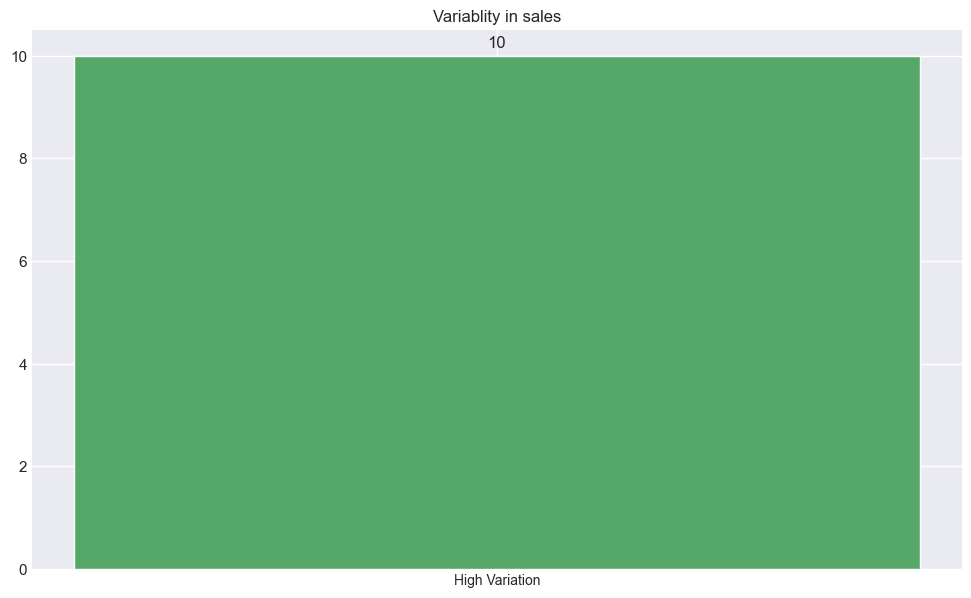

In [185]:
plot_bar(flat_sales_data,'variation','product',title = 'Variablity in sales',imagefile='Variablity in sales.png')

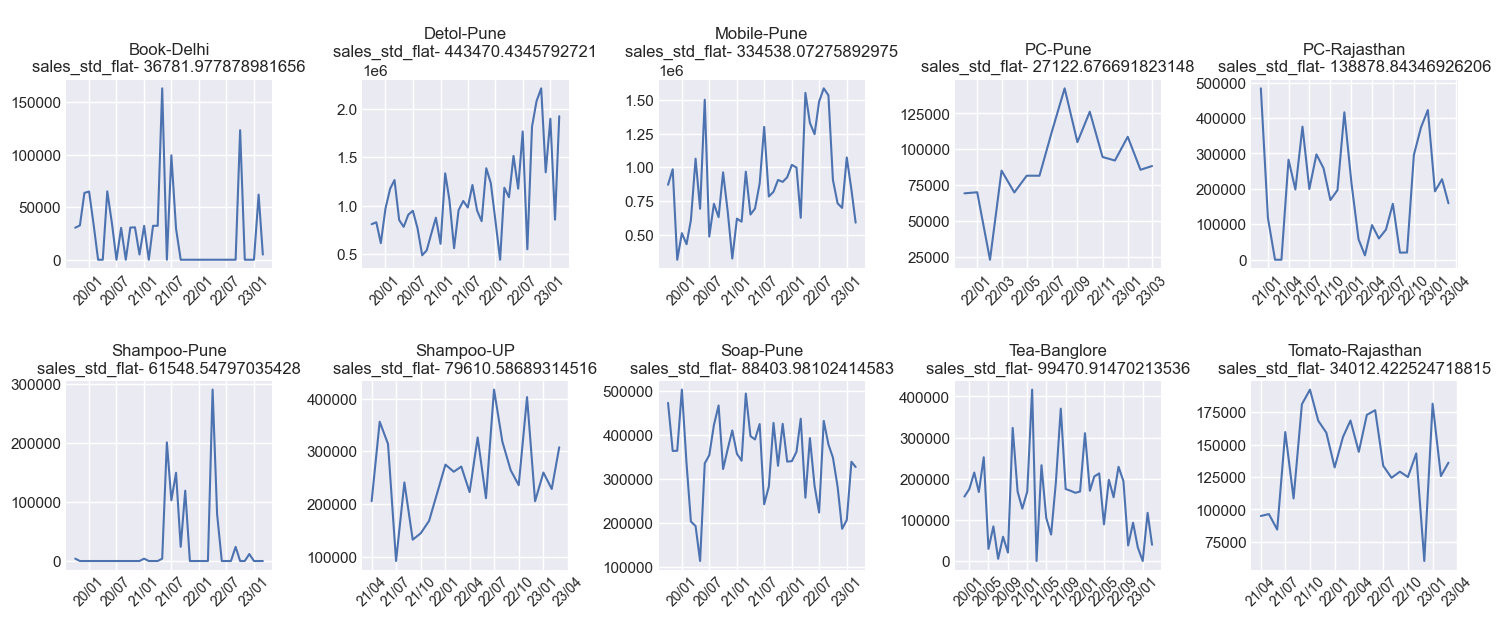

In [186]:
flat_data, flat_grains, flatkey_grain = get_category(data1,  
                                                                category_data = flat_sales_data, 
                                                                filter_col = 'variation', filter_condtion= 'High Variation', 
                                                                measure_filter_col = 'sales_std_flat')
if flat_data.empty:
    doc.add_paragraph("-->  There are no flat sales grains found")
else:
    plot_manysubplot(data1 = flat_data, title= '', title_df = flatkey_grain , title_filter_col = 'sales_std_flat',imagefile='flatkey_grain.png')


midflat_data, midflat_grains, midflatkey_grain = get_category(data1,  
                                                                category_data = flat_sales_data, 
                                                                filter_col = 'variation', filter_condtion= 'Mid Variation', 
                                                                measure_filter_col = 'sales_std_flat')
if midflat_data.empty:
    doc.add_paragraph("Mid Variation Sales Data is empty\n")
else:
    plot_manysubplot(data1 = midflat_data, title= '', title_df = midflatkey_grain , title_filter_col = 'sales_std_flat',imagefile='Mid Variation.png')


    
lowflat_data, lowflat_grains, lowflatkey_grain = get_category(data1,  
                                                                category_data = flat_sales_data, 
                                                                filter_col = 'variation', filter_condtion= 'Low Variation', 
                                                                measure_filter_col = 'sales_std_flat')
if lowflat_data.empty:
    doc.add_paragraph("\nLow Variation Sales Data is Empty\n")
else:
    plot_manysubplot(data1 = lowflat_data, title= '', title_df = lowflatkey_grain , title_filter_col = 'sales_std_flat',imagefile='Low Variation.png')


    

In [187]:
def get_end_of_complilation (start_time):
    end_time = time.time()
    doc.add_paragraph(f'Time taken (in Mins) - {round((end_time-start_time)/60)}')
    doc.save(path+ customer_name + EDAfilename)


### 3M Moving Avg 

In [192]:
 data1.groupby([product])[sales].rolling(window=3).mean().reset_index(drop=True)

0               NaN
1               NaN
2      42296.666667
3      53806.666667
4      53766.666667
           ...     
337   132510.000000
338   109503.333333
339   128393.333333
340   122563.333333
341   147886.666667
Name: Quantity, Length: 342, dtype: float64

In [193]:
def calculate_3mmv(data1):
    if frequency == 'Monthly':
        data1['MV'] = data1.groupby([product])[sales].rolling(window=3).mean().reset_index(drop=True)
    elif frequency == 'Weekly':
        data1['MV'] = data1.groupby([product])[sales].rolling(window=12).mean().reset_index(drop=True)
    elif frequency == 'Daily':
        data1['MV'] = data1.groupby([product])[sales].rolling(window=90).mean().reset_index(drop=True)
    data1['MV'] = np.where(data1['MV'].isnull(), data1[sales], data1['MV']) ## Filling NA value getting by rolling
    return data1[[product, sales, date,'MV']]
data_moving_avg = calculate_3mmv(sales_data)
data_moving_avg.head(2)

product  Quantity    Date            MV
300  Book-Delhi     30480  201910 238626.666667
301  Book-Delhi     32730  201911 170466.666667

In [194]:
lag_value = 3
# lastdate_accuracy = '202130'

In [195]:
def get_date(last_sale_date,lag_value):

    if frequency == 'Monthly' :
        lastdate_dt = datetime.datetime.strptime(last_sale_date, '%Y-%m-%d')
        lastdate_dt = datetime.datetime.strftime(lastdate_dt,  '%Y%W')
        lastdate_tf = datetime.datetime.strptime(str(lastdate), '%Y%m')
        start_date = lastdate_tf+relativedelta(months=lag_value)
        start_date_tf = datetime.datetime.strftime(start_date,  '%Y%m')
    elif frequency == 'Weekly' :
        lastdate_dt = datetime.datetime.strptime(last_sale_date, '%Y-%m-%d')
        start_date = lastdate_dt-relativedelta(weeks=lag_value)
        start_date_tf = datetime.datetime.strftime(start_date,  '%Y%W')
    elif frequency == 'Daily' :
        lastdate_tf = datetime.datetime.strptime(str(lastdate), '%Y%m%d')
        start_date = lastdate_tf+relativedelta(days=lag_value)
        start_date_tf = datetime.datetime.strftime(start_date,  '%Y%m%d')
    return start_date_tf

start_date_tf = get_date(last_sale_date,lag_value)


In [196]:
start_date_tf

'202303'

In [197]:
def get_wmape(data):
    data['abs_err'] = abs(data[sales] - data['MV'])
    data = data.groupby([date]).agg({'abs_err':'sum', sales: 'sum'}).rename(columns = 
                                                                            {'abs_err' : 'sum_abs_err', 
                                                                             sales : 'sum_sales' }).reset_index()
    data['error_wmape'] = 100 * round((data['sum_abs_err']/data['sum_sales']),3)
    return data

In [198]:
def get_wbias(data):
    data['err'] = data[sales] - data['MV']
    data = data.groupby([date]).agg({'err':'sum', sales: 'sum'}).rename(columns = 
                                                                            {'err' : 'sum_err', 
                                                                             sales : 'sum_sales' }).reset_index()
    data['error_bias'] = 100 * round((data['sum_err']/data['sum_sales']),3)
    return data

In [199]:
def find_accuracy(data,lastdate,lag_value):
    doc.add_heading(f"{count_number}.WMAPE and WBIAS")
    end_date = get_date(last_sale_date=lastdate, lag_value=1)
    start_date= get_date(last_sale_date=lastdate, lag_value=lag_value)
    print(f'Start date - {start_date} and End Date - {end_date}')
    selected_data = data[(data[date].map(str) >= start_date) & (data[date].map(str) <= end_date)]
    wmape_result, wbias_result = get_wmape(selected_data), get_wbias(selected_data)
    doc.add_paragraph(f'wmape results-{wmape_result}')
    doc.add_paragraph('\n')
    doc.add_paragraph(f'wbias results-{wbias_result}')
    return wmape_result, wbias_result

In [200]:

wmape_result,wbias_result = find_accuracy(data_moving_avg,lastdate = last_sale_date,lag_value = 3)
wmape_result
count_number += 1

Start date - 202303 and End Date - 202301


Empty DataFrame
Columns: [Date, sum_abs_err, sum_sales, error_wmape]
Index: []

In [201]:
get_end_of_complilation(start_time)

### Demand Pattern

Smooth demand (ADI < 1.32 and CV² < 0.49). The demand is very regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level. 

Intermittent demand (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher.

Erratic demand (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky.

Lumpy demand (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable.

Formula : ADI = Total number of data points/total number of non zero data points

CV = Std deviation / avg value

In [202]:
def get_demand_pattern(sales_cov_segment,zeroes_data ):
    ADI_CV_merge = sales_cov_segment.merge(zeroes_data, on = 'product', how = 'inner')
    ADI_CV_merge['CV2'] = ADI_CV_merge['COV'] * ADI_CV_merge['COV']
    ADI_CV_merge['demand_pattern'] = 'Undefined'
    ADI_CV_merge['ADI'] = round(ADI_CV_merge['data_points_size']/(ADI_CV_merge['data_points_size'] - ADI_CV_merge['count_zeros']),3)
    if any(ADI_CV_merge ['ADI'] < 1.32 ) and  any(ADI_CV_merge ['CV2'] < 0.49 )  :
        ADI_CV_merge['demand_pattern'] = 'Smooth'
    elif any(ADI_CV_merge ['ADI'] >= 1.32 ) and  any(ADI_CV_merge ['CV2'] < 0.49 )  :
        ADI_CV_merge['demand_pattern'] = 'Intermittent'
    elif any(ADI_CV_merge ['ADI'] < 1.32 ) and  any(ADI_CV_merge ['CV2'] >= 0.49 )  :
        ADI_CV_merge['demand_pattern'] = 'Erratic'    
    elif any(ADI_CV_merge ['ADI'] >= 1.32 ) and  any(ADI_CV_merge ['CV2'] >= 0.49 )  :
        ADI_CV_merge['demand_pattern'] = 'Lumpy' 
    return ADI_CV_merge[[product,'CV2','ADI','demand_pattern']]
ADI_CV_data = get_demand_pattern(sales_cov_segment, zeroes_data)
ADI_CV_data.head()

product      CV2      ADI demand_pattern
0    Book-Delhi 2.381727 2.100000         Smooth
1    Detol-Pune 0.168507 1.000000         Smooth
2   Mobile-Pune 0.144036 1.000000         Smooth
3       PC-Pune 0.091244 1.000000         Smooth
4  PC-Rajasthan 0.519560 1.077000         Smooth

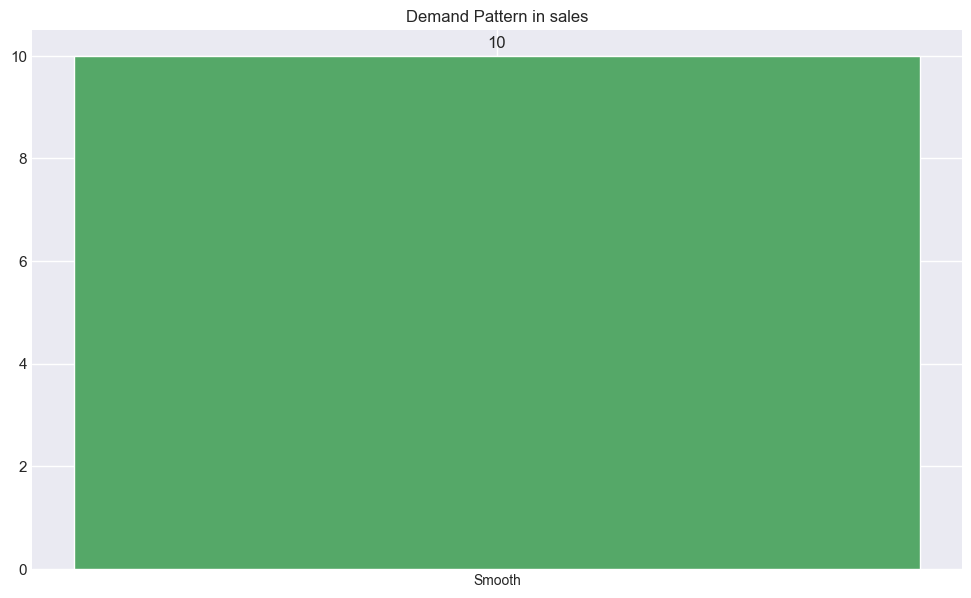

In [203]:
plot_bar(ADI_CV_data,'demand_pattern','product',title = 'Demand Pattern in sales',imagefile='demand_pattern.png')

### Forecasting Intermittent

If the percentage of zero exceeds 30% the time series will be considered as intermittent time series

# Concate into single CSV

In [204]:
# import pandas as pd
doc.add_paragraph("Combine into single CSV..\n")
doc.add_paragraph(path + customer_name + '_GrainWiseEDA_Results.csv')
from functools import reduce
data_frames = [skewed_data, zscore_data,data_abcxyz,sales_cov_segment, data_with_hetrodacity,negative_sales,get_date_diff,stl_features,acf_features_only,cluster_df,
              entropy_features,trend_data,fuller_data,level_shift_data,zeroes_data,zscore_last1year_data,get_count_as_1, get_count_as_0,flat_sales_data]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=[product],how='left'), data_frames).drop_duplicates()
df_merged.head(5)
df_merged.to_csv(os.path.join(path, customer_name + '_GrainWiseEDA_Results.csv'), index=False)
              


product  skew_number      skewness      z_outlier  flag_oulier  \
0    Book-Delhi     2.104000  right_skewed  Upper Outlier         True   
1    Detol-Pune     0.917000        Normal     No outlier        False   
2   Mobile-Pune     0.608000        Normal     No outlier        False   
3       PC-Pune    -0.402000        Normal     No outlier        False   
4  PC-Rajasthan     0.380000        Normal     No outlier        False   

   no_of_outlier  total_date_count data_points_flag  Contribution  Cumulative  \
0              1                42                X      0.008255  100.000000   
1              0                42                X      0.374197   37.419720   
2              0                42                X      0.305320   67.951710   
3              0                16                Z      0.011848   98.337447   
4              0                28                Y      0.044491   94.384436   

   ... zero_percent_flag outlier_count              outlier_date  isoutlier  \
0  ...              True             3  [202105, 202107, 202210]       True   
1  ...             False             2          [202210, 202211]       True   
2  ...             False             2          [202204, 202208]       True   
3  ...             False             2          [202202, 202208]       True   
4  ...             False             1                  [202012]       True   

   consecutive_one_count flag_repeat_1 consecutive_zero_count  flag_repeat_0  \
0                      0         False                      2           True   
1                      0         False                      0          False   
2                      0         False                      0          False   
3                      0         False                      0          False   
4                      0         False                      0          False   

        variation sales_std_flat  
0  High Variation   36781.977879  
1  High Variation  443470.434579  
2  High Variation  334538.072759  
3  High Variation   27122.676692  
4  High Variation  138878.843469  

[5 rows x 62 columns]

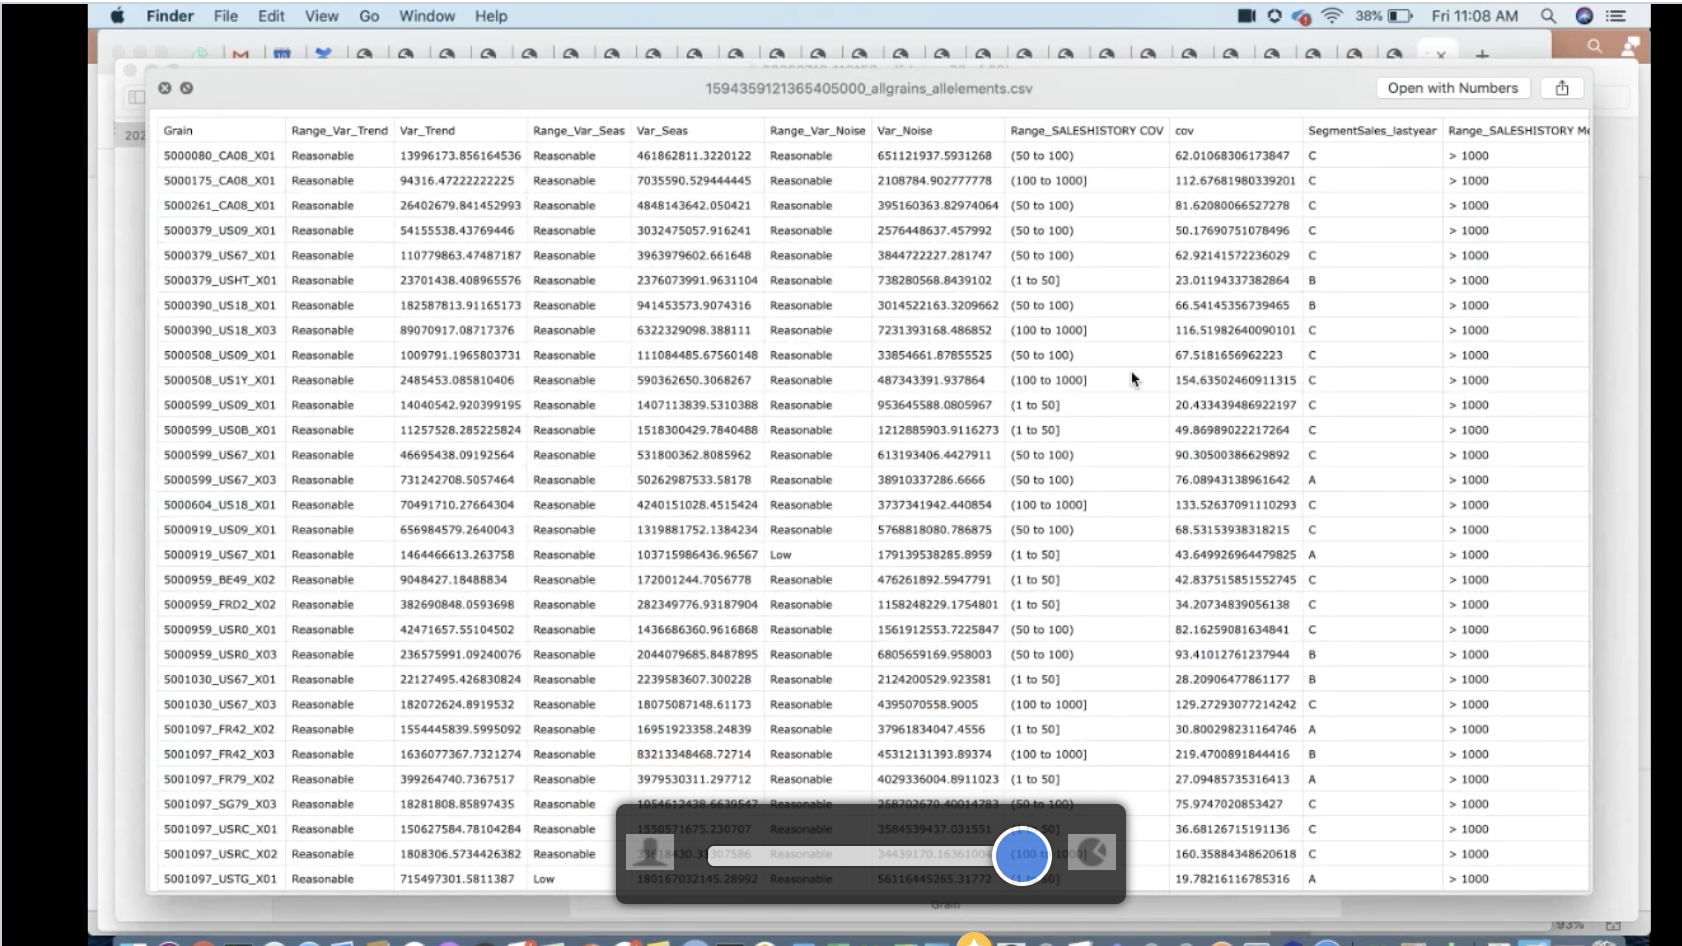

In [205]:
doc.add_paragraph("Done")
get_end_of_complilation (start_time)
doc.save(path+ customer_name + EDAfilename)
          